This notebook loads the data from trajectory_analysis_script.py for whichever data set is needed. The point is to look at the density of the tracks/localizations per area of the cell.

In [1]:
from src.databases.trajectory_analysis_script import *
from scipy.interpolate import griddata
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
import pandas as pd
import os
import numpy as np
from src.helpers.plotting_functions import *
from src.helpers.import_functions import *
from src.helpers.Analysis_functions import *
from src.helpers.diff_mw import *
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib as mpl
from src.helpers.scalebars import *
from src.helpers.Convert_csv_mat import *
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import stats, ndimage
import csv  
from sklearn.cluster import OPTICS
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
from sklearn.cluster import DBSCAN
from cgitb import small
import src.helpers.smallestenclosingcircle as smallestenclosingcircle
import math
import src.helpers.guassian_fit as gaussian_fit
import src.helpers.fbm_utility as fbm_utility
import src.helpers.simulate_foci as simulate_foci
import src.helpers.simulate_cells as simulate_cells

import matplotlib.patches as mpatches
import pickle

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_10076/2452328035.py:34: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
globals = {"olympus_pixel_size":130,"confocal_pixel_size":79}

Determine the integrated intensities of the spots found in experimental conditions

In [ ]:
#random testing
paths = ['/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/new_days/20190527/rpoc_ez/Analysis',
         '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/new_days/20190527/ll_ez/Analysis',
         '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/new_days/20190527/ll_m9/Analysis',
         '/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/15/rp_ez_hex5/Analysis']
names = ['rpoc_ez','ll_ez','ll_m9','rp_ez_hex5']
num_points_path = []
integrated_intensity_path = []

for path in paths:
    #find all files in path that end with spots.csv
    files = [f for f in os.listdir(path) if f.endswith('spots.csv')]
    #read the files with loadtext
    data = [np.loadtxt(os.path.join(path,f),delimiter=',',skiprows=1) for f in files]
    num_points = np.zeros(len(data))
    integrated_intensity = []
    for i in range(len(data)):
        num_points[i] = len(data[i])
        integrated_intensity.append(data[i][:,4])
    num_points_path.append(num_points)
    integrated_intensity_all = np.concatenate(integrated_intensity)
    integrated_intensity_path.append(integrated_intensity_all)
#plot the integrated intensity
for i in range(len(integrated_intensity_path)):
    plt.hist(integrated_intensity_path[i],bins=50,alpha = 0.5,density=True,label=names[i])
plt.xlim(4000,9000)
plt.xlabel('Integrated Intensity')
plt.ylabel('Probability Density')
plt.title('Integrated Intensity of Spots')
plt.legend()
plt.show()

#plot the CDF of the integrated intensity
for i in range(len(integrated_intensity_path)):
    plt.hist(integrated_intensity_path[i],bins=50,alpha = 0.5,density=True,label=names[i],cumulative=True,histtype='step')
plt.xlim(4000,9000)
plt.xlabel('Integrated Intensity')
plt.ylabel('Cumulative Probability Density')
plt.title('Integrated Intensity of Spots CDF')
plt.legend()
plt.show()

#do the KS test on the first 2 paths and print out which names are being compared
print("KS test between {} and {}: {}".format(names[0],names[1],stats.ks_2samp(integrated_intensity_path[0],integrated_intensity_path[1],method='asymp')))
print("KS test between {} and {}: {}".format(names[0],names[2],stats.ks_2samp(integrated_intensity_path[0],integrated_intensity_path[2],method='asymp')))
print("KS test between {} and {}: {}".format(names[1],names[2],stats.ks_2samp(integrated_intensity_path[1],integrated_intensity_path[2])))
print("KS test between {} and {}: {}".format(names[0],names[3],stats.ks_2samp(integrated_intensity_path[0],integrated_intensity_path[3])))
print("KS test between {} and {}: {}".format(names[1],names[3],stats.ks_2samp(integrated_intensity_path[1],integrated_intensity_path[3])))
print("KS test between {} and {}: {}".format(names[2],names[3],stats.ks_2samp(integrated_intensity_path[2],integrated_intensity_path[3])))

#compare the rpoc_ez to itself
print("KS test between {} and {}: {}".format(names[0],names[0],stats.ks_2samp(integrated_intensity_path[0],integrated_intensity_path[0])))
#print the length of the data
print("Length of rpoc_ez: {}".format(len(integrated_intensity_path[0])))
print("Length of ll_ez: {}".format(len(integrated_intensity_path[1])))
print("Length of ll_m9: {}".format(len(integrated_intensity_path[2])))
print("Length of rp_ez_hex5: {}".format(len(integrated_intensity_path[3])))


#test the poisition dependence 

###conclustion is that the integrated intensities are the same for all 3 paths. So the intensity of each single localization looks identical to others. 



DO the intensity check on simulated images

In [ ]:
paths = ["/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/h_0.2_track_200_diff_001_at_100100/Analysis/",
         "/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/h_0.35_track_200_diff_001_random/Analysis/",
         "/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/h_0.35_track_200_diff_1_random/Analysis/",
         "/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/h_0.2_track_100_diff_01_random/Analysis/",
         "/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/testing/Analysis/"
         ]
names = ['h_0.2_track_200_diff_001_at_100100','h_0.35_track_200_diff_001_random','h_0.35_track_200_diff_1_random','h_0.2_track_100_diff_01_random','testing']
num_points_path = []
integrated_intensity_path = []

for path in paths:
    #find all files in path that end with spots.csv
    files = [f for f in os.listdir(path) if f.endswith('spots.csv')]
    #read the files with pandas
    data = [pd.read_csv(os.path.join(path,f),delimiter=',') for f in files]
    num_points_path.append([len(each["TOTAL_INTENSITY_CH1"][3:]) for each in data])
    integrated_intensity_path.append([each["TOTAL_INTENSITY_CH1"][3:] for each in data])
#plot the integrated intensity
for i in range(len(integrated_intensity_path)):
    plt.hist(np.array(integrated_intensity_path[i][0],dtype=float),bins=20,alpha = 0.5,density=True,label=names[i])
#plt.xlim(4000,9000)
plt.xlabel('Integrated Intensity')
plt.ylabel('Probability Density')
plt.title('Integrated Intensity of Spots')
plt.legend()
plt.show()

#plot the CDF of the integrated intensity
for i in range(len(integrated_intensity_path)):
    plt.hist(np.array(integrated_intensity_path[i][0],dtype=float),bins=20,alpha = 0.5,density=True,label=names[i],cumulative=True,histtype='step')
#plt.xlim(4000,9000)
plt.xlabel('Integrated Intensity')
plt.ylabel('Cumulative Probability Density')
plt.title('Integrated Intensity of Spots CDF')
plt.legend()
plt.show()



In [ ]:
paths = ["/Users/baljyot/Desktop/Steph_Bead_Data/tracked_data/"
         ]
names = ["Steph's Beads"]
num_points_path = []
integrated_intensity_path = []

for path in paths:
    #find all files in path that end with spots.csv
    files = [f for f in os.listdir(path) if f.endswith('spots.csv')]
    #read the files with pandas
    data = [pd.read_csv(os.path.join(path,f),delimiter=',') for f in files]
    num_points_path.append([len(each["TOTAL_INTENSITY_CH1"][3:]) for each in data])
    integrated_intensity_path.append([each["TOTAL_INTENSITY_CH1"][3:] for each in data])
#plot the integrated intensity
for i in range(len(integrated_intensity_path)):
    plt.hist(np.array(integrated_intensity_path[i][0],dtype=float),bins=20,alpha = 0.5,density=True,label=names[i])
#plt.xlim(4000,9000)
plt.xlabel('Integrated Intensity')
plt.ylabel('Probability Density')
plt.title('Integrated Intensity of Spots')
plt.legend()
plt.show()

#plot the CDF of the integrated intensity
for i in range(len(integrated_intensity_path)):
    plt.hist(np.array(integrated_intensity_path[i][0],dtype=float),bins=20,alpha = 0.5,density=True,label=names[i],cumulative=True,histtype='step')
#plt.xlim(4000,9000)
plt.xlabel('Integrated Intensity')
plt.ylabel('Cumulative Probability Density')
plt.title('Integrated Intensity of Spots CDF')
plt.legend()
plt.show()

In [ ]:
%matplotlib widget


The following makes a "true" simulation of tracks and then subsamples them to determine how many subsamples one needs to recapture the total set

In [ ]:
tracks = 500

cell_parms = {
    "diffusion_coefficients":np.array(list(0.1*np.ones(100)) + list(1*np.ones(300)) + list(0.01*np.ones(100))),
    "initials":np.random.uniform(100,130,(tracks,2)),
    "num_tracks":tracks,
    "track_type":"fbm",
    "hursts":np.array(list(0.2*np.ones(100)) + list(0.35*np.ones(300)) + list(0.35*np.ones(100))),
    "dims":(200,200),
    "movie_frames":500
}      

#sim_params
sim_params = {
    "track_length_mean":15,
    "track_distribution":"exponential",
    "exposure_time":20,#ms same as frame_time
    "base_noise":140,
    "point_intensity":20,
    "psf_sigma":0.82,
    "frame_time":20,#ms
    "pixel_size":globals["olympus_pixel_size"],
    "axial_function":"ones", #"ones" or "exponential"
}
samples = [20,40,60,80,100,120,140,160,180,200,300,400]
cell_sim = simulate_cells.Simulate_cells(cell_parms,sim_params)
samples,full_sim = cell_sim.sample_cells(subsample_sizes = samples)


In [ ]:
#save the data for the full simulation

simulate_cells.make_directory_structure("/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/subsampling_sim/h_0.2(100).0.35(300).0.35(100)_track_500_diff_1(300).1(100).01(100)_random(100_130)/","test_seg",full_sim["map"],"mean",1,
                                        data=full_sim,parameters={"cell_parms":cell_parms,"sim_params":sim_params})
sample_lengths = [20,40,60,80,100,120,140,160,180,200,300,400]
#for each sample size, save the data
for i in range(len(samples)):
    simulate_cells.make_directory_structure("/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/subsampling_sim/h_0.2(100).0.35(300).0.35(100)_track_500_diff_1(300).1(100).01(100)_random(100_130)/subsamples/{0}_samples/".format(sample_lengths[i]),"test_seg",samples[i]["map"],"mean",1,
                                        data=samples[i])

In [ ]:

base_dir = "/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/subsampling_sim/h_0.2(150).0.35(350)_track_500_diff_1(350).1(150)_random(100_130)"
#for the sampling sim find read the data for the full simulation
full_sim_tracks = open_pickle_data(base_dir)
#for each sample size, load the true data
#in the directory find the directory labeled "subsamples" which stores the data for each sample size with names like "20_samples"
#use the open_pickle_data function to load the data for each sample size

sample_files = os.listdir(base_dir+"/subsamples/")
#remove the .DS_Store file
sample_files.remove(".DS_Store")

#add these names to the path to get the full path to the data
sample_paths = [base_dir +"/subsamples/{0}".format(i) for i in sample_files]
#load the data for each sample size
sample_data_tracks = [open_pickle_data(i) for i in sample_paths]
#now read the extracted data for each sample size
sample_data = [read_data(i)["ALL"] for i in sample_paths]
#do msd_calc on the full simulation data
full_sim_msd = msd_calc(full_sim_tracks,plot=False,save=False)
#repeat for each sample size
sample_data_msd = [msd_calc(i,plot=False,save=False) for i in sample_data]

sample_data_track_msd = [msd_calc(i,plot=False,save=False) for i in sample_data_tracks]



In [ ]:
#plot the histograms of the msd for the full_sim and each sample size
fig,ax = plt.subplots()
ax.hist(np.log10(np.array(list(full_sim_msd["track_diffusion"].values()))*(1000./20.)*(130**2)*1e-6),bins=20,alpha=0.5,density=True)
ax.set_ylabel("Density")
ax.set_xlabel("log10(diffusion coefficient (um^2/s))")
ax.set_title("Diffusion Coefficient for full simulation \n (h=0.5,track=500 (150 for low, 350 for high)")
#make all the plots have the same x axis limits
ax.set_xlim(-3,1)
plt.show()

#plot the histograms of the msd of each sample size
for i in range(len(sample_data_msd)):
    fig,ax = plt.subplots()
    ax.hist(np.log10(np.array(list(sample_data_msd[i]["track_diffusion"].values()))*(1000./20.)*(130**2)*1e-6),bins=20,alpha=0.5,density=True,label = "extracted")
    ax.set_ylabel("Density")
    ax.set_xlabel("log10(diffusion coefficient (um^2/s))")
    ax.set_title("Histogram of diffusion coefficient for sample size {0}".format(len(sample_data_msd[i]["tavg_t1_msd"].keys())))
    #make all the plots have the same x axis limits
    ax.set_xlim(-3,1)
    #plt.show()

    ax.hist(np.log10(np.array(list(sample_data_track_msd[i]["track_diffusion"].values()))*(1000./20.)*(130**2)*1e-6),bins=20,alpha=0.5,density=True,label = "true")
    #ax.set_ylabel("Density")
    #ax.set_xlabel("log10(diffusion coefficient (um^2/s))")
    #ax.set_title("True Histogram of diffusion coefficient for sample size {0}".format(len(sample_data_track_msd[i]["tavg_t1_msd"].keys())))
    #make all the plots have the same x axis limits
    #ax.set_xlim(-3,1)
    ax.legend()
    plt.show()


#plot the cdf of the msd for the full simulation and each sample size as a line plot
fig,ax = plt.subplots()
for i in sample_data_msd:
    ax.plot(np.sort(np.log10(np.array(list(i["track_diffusion"].values()))*(1000./20.)*(130**2)*1e-6)),np.linspace(0,1,len(i["track_diffusion"].keys()))*(1000./20.)*(130**2)*1e-6,label="sample size {0}".format(len(i["track_diffusion"].keys())))
ax.plot(np.sort(np.log10(np.array(list(full_sim_msd["track_diffusion"].values()))*(1000./20.)*(130**2)*1e-6)),np.linspace(0,1,len(full_sim_msd["track_diffusion"].keys()))*(1000./20.)*(130**2)*1e-6,label="full sim")
ax.set_ylabel("CDF")
ax.set_xlabel("log10(Diffusion Coefficient (um^2/s))")
ax.set_title("CDF of diffusion coefficient \n (h=0.5,track=500 (150 for low, 350 for high)")
#sort the legend by sample size (ascending)
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[-3:]))
ax.legend(handles, labels)
plt.show()

#for each sample find the KS test statistic and p value when comparing to the full simulation
ks_stats = []
for i in sample_data_msd:
    ks_stats.append(stats.ks_2samp(list(i["track_diffusion"].values()),list(full_sim_msd["track_diffusion"].values())))
#plot the KS test statistic and p value for each sample size
fig,ax = plt.subplots()
ax.scatter([len(i["track_diffusion"].keys()) for i in sample_data_msd],np.array(ks_stats)[:,1],label="p value")
ax.set_ylabel("p value")
ax.set_xlabel("sample size")
ax.set_title("KS test p value for each sample size \n (h=0.5,track=500 (150 for low, 350 for high)")
#plot a horizontal line at the p value of 0.05
ax.axhline(y=0.05, color='r', linestyle='--')
#make the ys axis log scale
ax.set_yscale("log")
ax.legend()
plt.show()





In [ ]:
#plot the histograms of the msd for the full_sim and each sample size
fig,ax = plt.subplots()
ax.hist(list(full_sim_msd["track_alpha"].values()),bins=50,alpha=0.5,density=True)
ax.set_ylabel("Density")
ax.set_xlabel("alpha per track")
ax.set_title("Alphas for full simulation \n (h=0.5,track=500 (150 for low, 350 for high)")
#make all the plots have the same x axis limits
ax.set_xlim(-2,2)
plt.show()

#plot the histograms of the msd of each sample size
for i in sample_data_msd:
    fig,ax = plt.subplots()
    ax.hist(np.array(list(i["track_alpha"].values())),bins=50,alpha=0.5,density=True)
    ax.set_ylabel("Density")
    ax.set_xlabel("alpha per track")
    ax.set_title("Histogram of alphas for sample size {0}".format(len(i["tavg_t1_msd"].keys())))
    #make all the plots have the same x axis limits
    ax.set_xlim(-2,2)

    plt.show()




In [ ]:
max_x = 175
min_x = 25
max_y = 175
min_y = 25

#find combinations of [x,y] values that are unique
x = np.arange(min_x,max_x+1)
y = np.arange(min_y,max_y+1)
x,y = np.meshgrid(x,y)
x = x.flatten()
y = y.flatten()
xy = np.array([x,y]).T
xy = np.unique(xy,axis=0)

#randomly select 100 of these combinations
xy = xy[np.random.choice(len(xy),300,replace=False)]
#make sure xy is an array
xy = np.array(xy)
#make the x and y values floats
xy = xy.astype(float)
print(xy)




Testing the cell creating with the condensate definitions for initials

In [ ]:
initial_dict = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([2.5]),
    "diffusion_coefficient": np.array([1e-4]),
    "hurst_exponent": np.array([0.2])  
}
cell_parms = {
    "diffusion_coefficients":np.array(list(0.1*np.ones(100)) + list(0.01*np.ones(100))),
    "initials": initial_dict,
    "num_tracks":200,
    "track_type":"fbm",
    "hursts":np.array(list(0.2*np.ones(100)) + list(0.35*np.ones(100))),
    "dims":(200,200),
    "movie_frames":500,
    "cell_space":np.array([85,115])
}     
global_sim_params = {
    "track_length_mean":10,
    "track_distribution":"exponential",
    "exposure_time":20,#ms same as frame_time
    "base_noise":140,
    "point_intensity":20,
    "psf_sigma":0.82,
    "frame_time":20,#ms
    "pixel_size":globals["olympus_pixel_size"],
    "axial_function":"exponential",
    "density_dif": 5
}

cell_sim = simulate_cells.Simulate_cells(cell_parms,global_sim_params)
a = cell_sim.get_cell()

In [ ]:
#save the sim data
simulate_cells.make_directory_structure("/Volumes/Baljyot_HD/Sim_Data/sim_data_condensate_axial/h_0.2(100)0.35(100)_track_200_diff_0.1(100)0.01(100)_condensate_100-100_r_2.5/","test_seg",a["map"],"mean",1,
                                        data=a,parameters={"cell_parms":cell_parms,"sim_params":global_sim_params})

Testing the simulations

In [ ]:
#cell parameters
cell_parms = {
    "diffusion_coefficients":1*np.ones(100),
    "initials":np.random.uniform(50,150,(100,2)),#np.ones((100,2))*np.array([100,100]),#xy,#np.ones((10,2))*np.array([100,100]),#np.random.uniform(50,150,(200,2)),
    "num_tracks":100,
    "track_type":"fbm",
    "hursts":0.2*np.ones(100),
    "dims":(200,200),
    "movie_frames":500
}      

#sim_params
sim_params = {
    "track_length_mean":15,
    "track_distribution":"constant",
    "exposure_time":20,#ms same as frame_time
    "base_noise":140,
    "point_intensity":20,
    "psf_sigma":0.82,
    "frame_time":20,#ms
    "pixel_size":globals["olympus_pixel_size"],
    "axial_function":"exponential"
}
cell_sim = simulate_cells.Simulate_cells(cell_parms,sim_params)
a = cell_sim.get_cell()


In [ ]:
#save the sim data
simulate_cells.make_directory_structure("/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/testing1/","test_seg",a["map"],"mean",1,
                                        data=a,parameters={"cell_parms":cell_parms,"sim_params":sim_params})

Find all simulated maps saved:
1) open the true simulated data
2) open and prepare the extracted data
3) compare them both
4) plot all of these on a scatter plot

In [ ]:
#define all the locations of the simulated maps
sim_maps = glob.glob("/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/**")
#remove the subsampling_sim directory
sim_maps = [i for i in sim_maps if "subsampling_sim" not in i]
#find the unique name of each directory
sim_names = [os.path.basename(os.path.normpath(i)) for i in sim_maps]

# sim_maps = [i for i in sim_maps if "h_0.5" not in i]
# sim_maps = [i for i in sim_maps if "h_0.2" not in i]
# sim_maps = [i for i in sim_maps if "h_0.35" not in i]
# sim_maps = [i for i in sim_maps if "diff_1" not in i]
# sim_maps = [i for i in sim_maps if "diff_001" not in i]
# sim_maps = [i for i in sim_maps if "random" not in i]
#sim_maps = [i for i in sim_maps if "500" not in i]
sim_maps = [i for i in sim_maps if "h_0_" not in i]
sim_maps = [i for i in sim_maps if "track_5_" not in i]
sim_maps = [i for i in sim_maps if "track_10_" not in i]
sim_maps = [i for i in sim_maps if "len499" not in i]
sim_maps = [i for i in sim_maps if "testing" not in i]
# sim_maps = [i for i in sim_maps if "h_0.2_track_200_diff_01_at_100100" not in i]

# sim_names = [i for i in sim_maps if "h_0.35" not in i]
# sim_names = [i for i in sim_maps if "h_0.2" not in i]
# sim_names = [i for i in sim_maps if "h_0.5" not in i]
# sim_names = [i for i in sim_names if "diff_1" not in i]
# sim_names = [i for i in sim_names if "diff_001" not in i]
# sim_names = [i for i in sim_names if "random" not in i]
#sim_names = [i for i in sim_names if "500" not in i]
sim_names = [i for i in sim_names if "h_0_" not in i]
sim_names = [i for i in sim_names if "track_5_" not in i]
sim_names = [i for i in sim_names if "track_10_" not in i]
sim_names = [i for i in sim_names if "len499" not in i]
sim_names = [i for i in sim_names if "testing" not in i]
# sim_names = [i for i in sim_names if "h_0.2_track_200_diff_01_at_100100" not in i]
#define 3 symbols for each of the 3 different types of simulations
symbols = ["x","o","^"]#for hurst=0.2,0.35,0.5
#make a list of marker symbols for each simulation name.
#assign the same symbol to the simulations with the same hurst value
sim_markers = []
for i in sim_names:
    if "h_0.2" in i:
        sim_markers.append(symbols[0])
    elif "h_0.35" in i:
        sim_markers.append(symbols[1])
    elif "h_0.5" in i:
        sim_markers.append(symbols[2])
    else:
        print("Error: Unknown hurst value")
        print(i)
        #sim_markers.append("x")
        break

#make a list of colors for each simulation name.
sim_colors = []
for i in sim_names:
    if "track_100" in i:
        sim_colors.append("red")
    if "track_200" in i:
        sim_colors.append("blue")
    if "track_500" in i:
        sim_colors.append("green")
print(sim_names)
print(sim_colors)
print(sim_markers)

In [ ]:
sim_names = ['/Volumes/Baljyot_HD/Sim_Data/sim_data_condensate_axial/h_0.2(100)0.35(100)_track_200_diff_0.1(100)0.01(100)_condensate_100-100_r_2.5/']
sim_names

define some useful functions

In [3]:
#def open the pickeled data
def open_pickle_data(path,which="tracks"):
    with open(path+"/Track_dump.pkl", 'rb') as f:
        data = pickle.load(f)
    true_tracks = cell_sim._convert_track_dict_msd(data[which])
    return true_tracks

def msd_calc(track_dic,h=None,tau_lim=None,tick_space=2,save=False,cd=None,data_type=None,plot=True,msd_fit_lim=3):
    '''Docstring for msd_calc, this is just a fancy wrapper for the MSD_Tracks function in the Analysis_functions module that also does some plotting
    Not very useful for anything other than plotting the MSD curves for a set of tracks.
    MSD calculations can be done using this but it is obtuse and not recommended. See MSD_Tracks for a better way to do this.

    Parameters:
    -----------
    track_dic: dictionary
        dictionary of tracks with the keys being the track number and the values being the track
    h: float
        True husrt value for the simulation, if None this does not get plotted
    tau_lim: int
        The maximum tau value to plot, if None then this is set to the maximum tau value. Only used if plot is True
    tick_space: int
        The spacing between the ticks on the x axis, only used if plot is True
    save: bool
        If True then the plot is saved to the specified directory
    cd: str
        The directory to save the plot to, only used if save is True
    data_type: str
        The type of data that is being plotted, only used if save is True. This is the name of the folder that the plot is saved to
    plot: bool
        If True then the plot is plotted
    msd_fit_lim: int
        The number of points to fit the line to for the alpha value
    

    Returns:
    --------
    Dict containing:
    fit_ens: array
        The fit parameters for the ensemble of tracks
    track_alpha: dict
        The alpha values for each track
    tavg_t1_msd: dict
        The time averaged msd for tau = 1
    track_msds: dict
        The msd curves for each track
    track_alpha_linear_fit: dict
        The linear fit parameters for each track
    track_diffusion: dict
        The diffusion coefficient for each track using a polynomial fit
    track_diffusion_linear_fit: dict
        The diffusion coefficient for each track using a linear fit
    
    

    '''
    #if save is True and cd is None then raise an error
    if save:
        if cd is None:
            raise ValueError("cd must be specified if save is True")
        if data_type is None:
            raise ValueError("data_type must be specified if save is True")

    msd_dict,ens_displacements = MSD_Tracks(track_dic,permutation=True,return_type="both",verbose=True)
    msd = msd_dict["msd_curves"]
    disp_per_track = msd_dict["displacements"]
    #update the disp_per_track dictionary to have the msd curve per track
    track_msds = {}
    for i,j in disp_per_track.items():
        track_msds[i] = msd_avgerage_utility(j)

    #fit a line to the msd curves for the first n of the points and find the r2 value
    try:
        fit_ens = np.polyfit(np.log(list(msd.keys())[:msd_fit_lim]),np.log(list(msd.values())[:msd_fit_lim]),1,cov=True)
        slope_error = np.sqrt(fit_ens[1])

    except:
        fit_ens = None
        slope_error = None

    track_alphas = {}
    track_alphas_linear_fit = {}
    tavg_t1_msds = {}
    track_diffusion = {}
    track_diffusion_linear_fit = {}
    # for each track plot the msd_curve 
    for i,j in track_msds.items():
        #make sure the length of the track is greater than 3 so that the fit can be done
        if len(j.keys())<3:
            continue
        #set the alpha to be 0.1 so that the lines are transparent
        #if plot:
        #    plt.plot(j.keys(),j.values(),alpha=0.1)
        #fit a line to the msd curves for the first 3 of the points and find the r2 value
        fit,pcov = curve_fit(fit_MSD_Linear,np.log(list(j.keys())[:msd_fit_lim]),np.log(list(j.values())[:msd_fit_lim]),p0=[1,1])
        #repeat this with fitting the msd to a the function fit_MSD from Analysis_functions using curve_fit
        fit_curve,pcov = curve_fit(fit_MSD,list(j.keys())[:msd_fit_lim],list(j.values())[:msd_fit_lim],p0=[1,1])
        #plot the fitted line
        #if plot and fit_curve[1]<0:
        #     plt.plot(list(j.keys())[:msd_fit_lim],fit_MSD(list(j.keys())[:msd_fit_lim],fit_curve[0],fit_curve[1]),alpha=0.1)
        #     plt.plot(j.keys(),j.values(),alpha=0.1)
        # plt.show()
        if plot:
            plt.plot(list(j.keys()),list(j.values()),alpha=0.1)
        #add the slope of the fitted line to the track_alphas dictionary
        track_alphas_linear_fit[i] = fit[1]
        track_alphas[i] = fit_curve[1]
        #add the msd at tau=1 to the tavg_t1_msds dictionary, divide by 4 to get the correct value t is by default 1 since its tau=1
        tavg_t1_msds[i] = j[1]/4.
        track_diffusion[i] = fit_curve[0]/4.
        track_diffusion_linear_fit[i] = np.exp(fit[0])/4.
        
    if plot:
        #plot the msd curves and the fitted line
        plt.plot(list(msd.keys()),list(msd.values()),label="MSD_ensemble",linewidth=3,alpha=1,zorder=1)
        if fit_ens != None:
            plt.plot(list(msd.keys()),np.exp(fit_ens[0][1])*np.array(list(msd.keys()))**fit_ens[0][0],label="fit_ensemble",linewidth=3,alpha=1,zorder=2)

        plt.xscale("log")
        plt.yscale("log")
        #label the plot
        plt.xlabel("lag time (au)")
        plt.ylabel("MSD (au)")
        plt.legend()
        #annotate the plot with the slope of the fitted line with 2 decimal places (label the slope as alpha in greek)
        #add the error in the slope as well
        plt.annotate(r"$\alpha$ = {:.2f} $\pm$ {:.2f}".format(fit_ens[0][0],slope_error[0][0]),xy=(0.05,0.7),xycoords="axes fraction",fontweight="bold",fontsize=16)
        #annotate the true alpha value (hurst*2)
        if h != None:
            plt.annotate(r"True $\alpha$ = {:.2f}".format(h*2),xy=(0.05,0.6),xycoords="axes fraction",fontweight="bold",fontsize=16)
        if save == True:
            plt.savefig(cd+"/{0}_MSD_plot.png".format(data_type))
        plt.show()

        #on a new figure plot the histogram of the slopes of the fitted lines
        plt.clf()
        plt.hist(list(track_alphas.values()),bins=10)
        #plot a vertical line at the mean of the track_alphas
        plt.axvline(np.mean(list(track_alphas.values())),color="red",label="mean")
        #annotate the plot with the mean of the track_alphas
        plt.annotate(r"$\alpha$ = {:.2f}".format(np.mean(list(track_alphas.values()))),xy=(0.05,0.7),xycoords="axes fraction",fontweight="bold",fontsize=16)
        plt.xlabel(r"$\alpha$")
        plt.ylabel("count")
        if save == True:
            plt.savefig(cd+"/{0}_alpha_hist.png".format(data_type))
        plt.show()

        #repeat the above for the track_alphas_linear_fit
        plt.clf()
        plt.hist(list(track_alphas_linear_fit.values()),bins=10)
        plt.axvline(np.mean(list(track_alphas_linear_fit.values())),color="red",label="mean")
        plt.annotate(r"$\alpha$ = {:.2f}".format(np.mean(list(track_alphas_linear_fit.values()))),xy=(0.05,0.7),xycoords="axes fraction",fontweight="bold",fontsize=16)
        plt.xlabel(r"$\alpha$")
        plt.ylabel("count")
        if save == True:
            plt.savefig(cd+"/{0}_alpha_hist_linear_fit.png".format(data_type))
        plt.show()

    #the following plots the pdf of the displacements for each tau, right now it sometimes creates infinite loops so it is commented out TODO: fix this
    # if plot:
    #     #make a figure and axes
    #     fig,ax = plt.subplots()

    #     #get a collection of N different colours where N is the number of taus
    #     colors = plt.cm.jet(np.linspace(0,1,len(ens_displacements.keys())))

    # #make a histogram of the displacements for each tau from ens_displacements
    # for i,j in ens_displacements.items():
    #     #if the tau is greater than the tau_lim then skip it
    #     if (tau_lim != None):
    #         if i > tau_lim:
    #             continue
    #     if plot:
    #         #make the histogram normalized and transparent
    #         ax.hist(np.ndarray.flatten(np.array(j)),bins=50,alpha=0.1,color=colors[i-1],density=True)#,stacked=True,weights=np.ones(len(np.ndarray.flatten(np.array(j))))/len(np.ndarray.flatten(np.array(j))))
    #     #fit a gaussian to the histogram
    #     mu,sigma = norm.fit(np.ndarray.flatten(np.array(j)))
    #     if plot:
    #         #plot the gaussian
    #         x = np.linspace(np.min(np.ndarray.flatten(np.array(j))),np.max(np.ndarray.flatten(np.array(j))),100)
    #         ax.plot(x,norm.pdf(x,mu,sigma),linewidth=1,color=colors[i-1])
    # if plot:
    #     #label the plot, in greek the delta_x is P_delta_x
    #     ax.set_xlabel(r"$\Delta r$ (au)")
    #     ax.set_ylabel(r"$P_{\Delta r}$ ($au^{-1}$)")

    #     #rather than a legend, make a colorbar with the colors corresponding to the taus
    #     cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.jet),ticks=np.linspace(0,1,len(ens_displacements.keys())),ax=ax)
    #     cbar.ax.set_yticklabels(list(ens_displacements.keys()))
    #     for label in cbar.ax.yaxis.get_ticklabels()[1::tick_space]:
    #         label.set_visible(False)
    #     cbar.set_label("tau (au)")


    #     #make the title
    #     ax.set_title("PDF of displacements for each tau (van Hove correlation)")
    #     ax.set_ylim(0,1.5)
    #     if save == True:
    #         plt.savefig(cd+"/{0}_PDF_plot.png".format(data_type))
    #     plt.show()
    return {"fit_ens":fit_ens, 
            "track_alpha":track_alphas, 
            "tavg_t1_msd":tavg_t1_msds, 
            "track_msds":track_msds, 
            "track_alpha_linear_fit":track_alphas_linear_fit,
            "track_diffusion":track_diffusion,
            "track_diffusion_linear_fit":track_diffusion_linear_fit}
#load the extracted data
def read_data(wd):
    
    rp_ez= run_analysis(wd=wd,
                    t_string="test_seg",sim=True)
                    
    rp_ez.read_parameters(minimum_percent_per_drop_in = 0.5, 
                        t_len_u = 500, 
                        t_len_l=1, 
                        minimum_tracks_per_drop = 3,
                        frame_step=500,
                        frame_total=500)

    rp_ez.get_blob_parameters(threshold=1e-2,
                            overlap=0,
                            detection_name='bp',
                            min_sigma=1/np.sqrt(2),
                            max_sigma=6/np.sqrt(2),
                            num_sigma=500,median = False)

    rp_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                        "plot_fit":False,
                                        "fitting_image":"Original",
                                        "radius_func":identity,
                                        "residual_func":residuals_gaus2d,
                                        "sigma_range":2,
                                        "centroid_range":0.5,
                                        "height_range":2})
    tem = rp_ez.run_flow_sim(wd,"test_seg")
    track_dict = rp_ez._convert_to_track_dict_bulk()
    return track_dict



Determine the localization error using trackmate fitting (sim a long track at the same point and look at the differences in the x,y positions)

In [ ]:
rp_ez= run_analysis(wd='/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/h_0_track_1_diff_0_at_100100(len499)',
                t_string="test_seg",sim=True)
                
rp_ez.read_parameters(minimum_percent_per_drop_in = 0.5, 
                    t_len_u = 500, 
                    t_len_l=1, 
                    minimum_tracks_per_drop = 3,
                    frame_step=500,
                    frame_total=500)

rp_ez.get_blob_parameters(threshold=1e-2,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=6/np.sqrt(2),
                        num_sigma=500,median = False)

rp_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":2,
                                    "centroid_range":0.5,
                                    "height_range":2})
tem = rp_ez.run_flow_sim('/Users/baljyot/Documents/2022-2023/PhD_Thesis/sim_data/h_0_track_1_diff_0_at_100100(len499)',"test_seg")
track_dict = rp_ez._convert_to_track_dict_bulk()
tracks = track_dict["ALL"]
#true xy
true_xy = np.array([100,100])
#collect all the xys 
xys = []
for i,j in tracks.items():
    track_xy = np.stack([j[:,0],j[:,1]],axis=1)
    xys+=list(track_xy)
diff_x = np.zeros(len(xys))
diff_y = np.zeros(len(xys))
diff_r = np.zeros(len(xys))
for i in range(len(xys)):
    #find the difference in true xy and the xy
    diff = true_xy - xys[i]
    diff_x[i] = diff[0]
    diff_y[i] = diff[1]
    diff_r[i] = np.sqrt(diff[0]**2 + diff[1]**2)
#plot the histogram of diff_x, diff_y
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(diff_x,bins=30,label="diff_x")
ax[1].hist(diff_y,bins=30,label="diff_y")
#make the legend
ax[0].legend()
ax[1].legend()
#put the x and y labels
ax[0].set_xlabel("diff_x (pixels)")
ax[1].set_xlabel("diff_y (pixels)")
ax[0].set_ylabel("count")
ax[1].set_ylabel("count")
#make a title
ax[0].set_title("Histogram of diff_x")
ax[1].set_title("Histogram of diff_y")
plt.show()
#plot the histogram of diff_r
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(diff_r,bins=30,label="diff_r")
#make the legend
ax.legend()
#put the x and y labels
ax.set_xlabel("diff_r (pixels)")
ax.set_ylabel("count")
#make a title
ax.set_title("Histogram of diff_r")
plt.show()
#print the mean and std of diff_x, diff_y, diff_r after converting to nm using the olympus pixel size in global variables
print("mean of diff_x: ",np.mean(diff_x)*globals["olympus_pixel_size"],"nm")
print("std of diff_x: ",np.std(diff_x)*globals["olympus_pixel_size"],"nm")
print("mean of diff_y: ",np.mean(diff_y)*globals["olympus_pixel_size"],"nm")
print("std of diff_y: ",np.std(diff_y)*globals["olympus_pixel_size"],"nm")
print("mean of diff_r: ",np.mean(diff_r)*globals["olympus_pixel_size"],"nm")
print("std of diff_r: ",np.std(diff_r)*globals["olympus_pixel_size"],"nm")




#find the msds
a = msd_calc(track_dict["ALL"],h=None,tau_lim=None,tick_space=2,plot=True,msd_fit_lim=30)
msds = np.array(list(a["track_diffusion"].values()))*(1000./20.)*(130**2)*1e-6
#print the msds
print("mean of msds: ",np.mean(msds))
print("msds: ",msds)


In [ ]:
rp_ez= run_analysis(wd=sim_names[0],
                t_string="test_seg",sim=True)
                
rp_ez.read_parameters(minimum_percent_per_drop_in = 0.5, 
                    t_len_u = 500, 
                    t_len_l=1, 
                    minimum_tracks_per_drop = 3,
                    frame_step=500,
                    frame_total=500)

rp_ez.get_blob_parameters(threshold=1e-2,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=6/np.sqrt(2),
                        num_sigma=500,median = False)

rp_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":2,
                                    "centroid_range":0.5,
                                    "height_range":2})
tem = rp_ez.run_flow_sim(sim_names[0],"test_seg")
track_dict = rp_ez._convert_to_track_dict_bulk()
a = msd_calc(track_dict["ALL"],h=None,tau_lim=None,tick_space=2,plot=True,msd_fit_lim=10)
msds = np.array(list(a["track_diffusion"].values()))
true_tracks = open_pickle_data(sim_names[0])
true_track_msd_calc = msd_calc(true_tracks,h=None,tau_lim=None,tick_space=2,plot=True,msd_fit_lim=10)
true_track_msds = np.array(list(true_track_msd_calc["track_diffusion"].values()))

#define the localization error in nm 
loc_err = [15]
#convert the localization error to um
loc_err = [i/1000. for i in loc_err]
loc_diff = find_static_localization_error_MSD(loc_err,2)
def convert_diff(n):
    m =n*(1000./20.)*(130**2)*1e-6
    return m
#plot the log10 of the msds as a histogram
fig,ax = plt.subplots()

ax.hist(np.log10(convert_diff(msds*4)),bins=50)

#label the lines with the nm version of the localization error
for i in range(len(loc_diff)):
    ax.axvline(np.log10(loc_diff[i]),color="red")
    ax.text(np.log10(loc_diff[i])+0.1,10,"{0}nm".format(int(loc_err[i]*1000.)),rotation=0,color="red")
ax.legend()
ax.set_xlabel("log10(msd)")
ax.set_ylabel("count")
ax.set_title("log10(msd) histogram")
plt.show()

fig,ax = plt.subplots()
ax.hist(np.log10((msds)*(1000./20.)*(130**2)*1e-6) - 0*np.log10((0.012**2)),bins=50)
for i in range(len(loc_diff)):
    ax.axvline(np.log10(loc_diff[i]/4),color="red")
    ax.text(np.log10(loc_diff[i]/4)+0.1,10,"{0}nm".format(int(loc_err[i]*1000.)),rotation=0,color="red")
ax.set_xlabel("log10(diffusion coefficient)")
ax.set_ylabel("count")
ax.set_title("log10(diffusion coefficient) histogram")
ax.set_xlim(-4,1)
plt.show()

fig,ax = plt.subplots()
ax.hist(np.log10((true_track_msds)*(1000./20.)*(130**2)*1e-6),bins=50)
for i in range(len(loc_diff)):
    ax.axvline(np.log10(loc_diff[i]/4),color="red")
    ax.text(np.log10(loc_diff[i]/4)+0.1,10,"{0}nm".format(int(loc_err[i]*1000.)),rotation=0,color="red")
ax.set_xlabel("True log10(diffusion coefficient)")
ax.set_ylabel("count")
ax.set_title("True log10(diffusion coefficient) histogram")
ax.set_xlim(-4,1)
plt.show()

true_msd_cal = np.log10((true_track_msds)*(1000./20.)*(130**2)*1e-6)
#find the KDE fo the true_msd_cal
kde = stats.gaussian_kde(true_msd_cal)
#find the x values for the KDE
x = np.linspace(-4,1,1000)
#find the y values for the KDE
y = kde(x)

#find the mean and std of the true_msd_cal and save them
true_msd_mean = np.mean(true_msd_cal)
true_msd_std = np.std(true_msd_cal)
#along with the data plot a gaussian with the mean and std of the true_msd_cal
fig,ax = plt.subplots()
ax.hist(true_msd_cal,bins=50,density=True,label = "True")
ax.plot(x,y,label = "KDE")
ax.plot(x,stats.norm.pdf(x,true_msd_mean,true_msd_std),label="Gaussian")
ax.set_xlabel("True log10(diffusion coefficient)")
ax.set_ylabel("count")
ax.set_title("True log10(diffusion coefficient) histogram")
ax.set_xlim(-4,1)
ax.legend()
plt.show()



In [ ]:

#for each sim_map open the true track data, and the extracted data
threshold=0.25
#make a figure 
plt.clf()
#make the figure large enough to fit the legend outside the plot, make it 3D 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
stored_data = np.zeros((len(sim_maps),3))

point_pair_errors = np.zeros((len(sim_maps)))
linking_errors = np.zeros((len(sim_maps)))

fit_diff_error = np.zeros((len(sim_maps)))
fit_alpha_error = np.zeros((len(sim_maps)))

#store the point density and the convex hull density
true_points_per_frame = []
extracted_points_per_frame = []

true_area_per_frame = []
extracted_area_per_frame = []

true_tavg_t1_msds = []
extracted_tavg_t1_msds = []

for i in range(len(sim_maps)):
    print("sim_names: {0}".format(sim_names[i]))
    true_tracks = open_pickle_data(sim_maps[i])
    extracted_tracks = read_data(sim_maps[i])["ALL"]
    #convert the true tracks and the extracted tracks to points per frame format
    true_tracks_frame = points_per_frame_convert(true_tracks)
    extracted_tracks_frame = points_per_frame_convert(extracted_tracks)
    #perform the point_error calculations for the true and extracted tracks
    percent_points_detected = point_error_detection(true_tracks_frame,extracted_tracks_frame,threshold=threshold)
    #find the number of points per frame 
    true_points_per_frame.append({frames:len(points) for frames,points in true_tracks_frame.items()})
    extracted_points_per_frame.append({frames:len(points) for frames,points in extracted_tracks_frame.items()})
    #find the area of the points using radius of gyration
    true_area_per_frame.append({frames: radius_of_gyration(points) if radius_of_gyration(points)!=None else 0 for frames,points in true_tracks_frame.items()})
    extracted_area_per_frame.append({frames: radius_of_gyration(points) if radius_of_gyration(points)!=None else 0 for frames,points in extracted_tracks_frame.items()})


    

    #find the point pairs for both 
    true_point_pairs = convert_point_pairs(true_tracks)
    extracted_point_pairs = convert_point_pairs(extracted_tracks)
    #perform the point_error calculations for the true and extracted tracks
    percent_point_pairs_detected,linking_ratio = point_pair_error_detection(true_point_pairs,extracted_point_pairs,threshold=threshold)
    #store the percent_point_pairs_detected
    point_pair_errors[i] = percent_point_pairs_detected
    linking_errors[i] = linking_ratio
    #for the true and extracted tracks do the msd calculations (only run this for new data that is being analysed for the first time)
    msd_true = msd_calc(true_tracks,h=None,tau_lim=40,tick_space=2,save=False,cd=sim_maps[i],data_type="True",plot=False,msd_fit_lim=3)
    msd_extracted = msd_calc(extracted_tracks,h=None,tau_lim=40,tick_space=2,save=False,cd=sim_maps[i],data_type="Extracted",plot=False,msd_fit_lim=3)
    #find the percent error between true and extracted alphas
    if msd_true["fit_ens"] != None:
        fit_alpha_error[i] = percent_error(msd_true["fit_ens"][0][0],msd_extracted["fit_ens"][0][0],abs=True)
        #find the percent error between true and extracted diffusion coefficients
        fit_diff_error[i] = msd_extracted["fit_ens"][0][1]/msd_true["fit_ens"][0][1]#percent_error(np.exp(msd_true["fit_ens"][0][1]),np.exp(msd_extracted["fit_ens"][0][1]),abs=True)
    #store the tavg_t1_msds
    true_tavg_t1_msds.append(msd_true["track_diffusion"])
    extracted_tavg_t1_msds.append(msd_extracted["track_diffusion"])

    track_match_dict = identity_track_matrix(true_tracks,extracted_tracks,threshold=threshold)
    mean_identiy = np.mean(track_match_dict["max_identity"])
    mean_abs_length_error = np.mean(np.abs(track_match_dict["length_error"]))

    #add the point (mean_identiy,mean_abs_length_error,percent_points_detected) to the plot with the label sim_names[i]
    print(sim_names[i])
    print(sim_markers[i])
    print(sim_colors[i])
    ax.scatter(mean_identiy,mean_abs_length_error,percent_points_detected,label=sim_names[i],marker=sim_markers[i],c=sim_colors[i])
    #store the data in a numpy array
    stored_data[i] = np.array([mean_identiy,mean_abs_length_error,percent_points_detected])
    
ax.set_xlabel("mean identity")
ax.set_ylabel("mean absolute length error")
ax.set_zlabel("percent of points detected")

ax.legend()


plt.show()






In [ ]:
#find the density from the true_area_per_frame and the the true_points_per_frame
#this is done for eahc sim_map
true_density_per_frame = []
for i in range(len(true_area_per_frame)):
    map_density = []
    for j in true_area_per_frame[i].keys():
        if true_area_per_frame[i][j]!=0:
            map_density.append(true_points_per_frame[i][j]/true_area_per_frame[i][j])
    true_density_per_frame.append(np.median(map_density))

#find the density from the extracted_area_per_frame and the the extracted_points_per_frame
#this is done for eahc sim_map
extracted_density_per_frame = []
for i in range(len(extracted_area_per_frame)):
    map_density = []
    for j in extracted_area_per_frame[i].keys():
        if extracted_area_per_frame[i][j]!=0:
            map_density.append(extracted_points_per_frame[i][j]/extracted_area_per_frame[i][j])
    extracted_density_per_frame.append(np.median(map_density))

print("true_density_per_frame: {0}".format(true_density_per_frame))
print("extracted_density_per_frame: {0}".format(extracted_density_per_frame))
print(sim_names)

#convert the true_density_per_frame and extracted_density_per_frame to numpy arrays and to nm^2 by dividing by 130^2
true_density_per_frame = np.array(true_density_per_frame)/0.017
extracted_density_per_frame = np.array(extracted_density_per_frame)/0.017
#find the ratio of the true_density_per_frame and extracted_density_per_frame
density_ratio = true_density_per_frame/extracted_density_per_frame
#in density_ratio, replace all the nan values with 1
density_ratio[np.isnan(density_ratio)] = -1
##for each sim, plot the p val of the KS test for the tavg_t1_msds for true and extracted as a function of the density
plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

p_val_ks = np.zeros(len(sim_maps))

for i in range(len(sim_maps)):
    p_val_ks[i] = stats.ks_2samp(list(true_tavg_t1_msds[i].values()),list(extracted_tavg_t1_msds[i].values()))[1]
    ax.scatter(true_density_per_frame[i],p_val_ks[i],label=sim_names[i],marker=sim_markers[i],c=sim_colors[i])

#annotate the last point
#ax.annotate(sim_names[-1],(true_density_per_frame[-1],stats.ks_2samp(list(true_tavg_t1_msds[-1].values()),list(extracted_tavg_t1_msds[-1].values()))[1]))
ax.set_xlabel("true density (points per nm^2))")
ax.set_ylabel("p value of KS test")
ax.set_xscale("log")
ax.set_yscale("log")
#plot a line at p=0.05
ax.plot([np.min(np.array(true_density_per_frame)),np.max(np.array(true_density_per_frame))],[0.05,0.05],c="black",linestyle="--")
#ax.legend()
plt.show()
print("true_density_per_frame: {0}".format(np.array(true_density_per_frame)))
#plot the ratio of the true density to the extracted density
plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(len(sim_maps)):
    print("true_density_per_frame: {0}, density_ratio: {1}".format(true_density_per_frame[i],density_ratio[i]))
    ax.scatter(true_density_per_frame[i],density_ratio[i],label=sim_names[i],marker=sim_markers[i],c=sim_colors[i])
#annotate the last point with the name of the sim and a custom text 
#ax.annotate(str(sim_names[-1]) + "\n Extracted density undefined \n Only one point to use",(true_density_per_frame[-1],density_ratio[-1]),xytext=(true_density_per_frame[-1]*0.1,density_ratio[-1]*1.5),arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_xlabel("true density (points per nm^2))")
ax.set_ylabel("ratio of true density to extracted density")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend()
plt.show()
print("true_density_per_frame: {0}".format(np.array(true_density_per_frame)))


In [ ]:
#make a colormap from true_density_per_frame
true_density_per_frame = np.array(true_density_per_frame)

colormap = cm.jet
normalize = mcolors.Normalize(vmin=np.min(np.log10(true_density_per_frame)), vmax=np.max(np.log10(true_density_per_frame)))
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)

In [ ]:
#plot the true_points_per_frame and the extracted_points_per_frame for a single sim_map defines as n
n=4


plt.clf()
#sort by the frame number before plotting
true_points_per_frame[n] = {k: v for k, v in sorted(true_points_per_frame[n].items(), key=lambda item: item[0])}
extracted_points_per_frame[n] = {k: v for k, v in sorted(extracted_points_per_frame[n].items(), key=lambda item: item[0])}
#plot using the marker shape defined in sim_markers

plt.plot(list(true_points_per_frame[n].keys()),list(true_points_per_frame[n].values()),label="True_{0}".format(sim_names[n]),marker=sim_markers[n],color=sim_colors[n])
plt.plot(list(extracted_points_per_frame[n].keys()),list(extracted_points_per_frame[n].values()),label="Extracted_{0}".format(sim_names[n]),marker=sim_markers[n],color=sim_colors[n])

plt.xlabel("Frame")
plt.ylabel("Number of points")
plt.legend()
plt.show()



In [ ]:
#plot the point_pair_errors as a function of the stored_data[:,2]
#label the points with the sim_names
plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(len(sim_maps)):
    ax.scatter(stored_data[i,2],point_pair_errors[i],color=s_map.to_rgba(np.log10(true_density_per_frame)[i]))#,label=sim_names[i],marker=sim_markers[i])
ax.set_xlabel("percent of points detected")
ax.set_ylabel("percent of point pairs detected")
#annotate the last point with the name of the sim and a custom text
#plot a 1:1 line for reference 
# ax.plot([40,100],[40,100],color="black", label = "1:1 line", linestyle = "--", linewidth = 1)
#make the axis the same aspact ratio
ax.set_aspect('equal', adjustable='box')
#make the limits of the axis the same  
ax.set_xlim(0,100)
ax.set_ylim(0,100)

#ax.legend()
plt.show()



In [ ]:

#plot the point_pair_errors as a function of the linking errors
#label the points with the sim_names
plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#make a colormap from true_density_per_frame
true_density_per_frame = np.array(true_density_per_frame)

colormap = cm.jet
normalize = mcolors.Normalize(vmin=np.min(np.log10(true_density_per_frame)), vmax=np.max(np.log10(true_density_per_frame)))
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)

for i in range(len(sim_maps)):
    print("linking_errors: {0}, point_pair_errors: {1}, true_density_per_frame: {2}, sim_names: {3}".format(linking_errors[i],point_pair_errors[i],true_density_per_frame[i],sim_names[i]))
    ax.scatter(linking_errors[i],point_pair_errors[i],label=sim_names[i],color=s_map.to_rgba(np.log10(true_density_per_frame)[i]),marker ='o',alpha=1)#,marker=sim_markers[i])

ax.set_xlabel("percent linking error")
ax.set_ylabel("percent of point pairs detected")

#plot two lines, one horizontal at 50% and one vertical at 50%
ax.plot([0,100],[50,50],color="black", linestyle = "--", linewidth = 1)
ax.plot([50,50],[0,100],color="black", linestyle = "--", linewidth = 1)

#in the first quadrant annotate a text with ("Good detection","Good linking")
ax.text(30,60,"Good detection\nGood linking",fontsize=12)
#in the left bottom quadrant annotate a text with ("Poor detection","Good linking")
ax.text(30,40,"Poor detection\nGood linking",fontsize=12)
#in the right top quadrant annotate a text with ("Good detection","Poor linking")
ax.text(70,60,"Good detection\nPoor linking",fontsize=12)
#in the right bottom quadrant annotate a text with ("Poor detection","Poor linking")
ax.text(70,40,"Poor detection\nPoor linking",fontsize=12)

ax.set_aspect('equal', adjustable='box')
#make the limits of the axis the same  
ax.set_xlim(0,100)
ax.set_ylim(0,100)

#ax.legend()
plt.show()

color_bars = s_map.to_rgba(np.log10(true_density_per_frame))
plt.figure(figsize=(9, 1.5))
img = plt.imshow(color_bars, cmap=cm.jet)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)

#make a new list ordered by true_density_per_frame and sim_names
#first sort the true_density_per_frame
true_density_per_frame = np.array(true_density_per_frame)
true_density_per_frame_sorted = np.sort(true_density_per_frame)
#then sort the sim_names
sim_names_sorted = [x for _,x in sorted(zip(true_density_per_frame,sim_names))]
for i in range(len(sim_names_sorted)):
    print("{0}: {1}".format(sim_names_sorted[i],true_density_per_frame_sorted[i]))
print("max: {0}".format(np.max(true_density_per_frame)))
print("min: {0}".format(np.min(true_density_per_frame)))

Density linking and identiy interpolation

In [ ]:
#testing for interpolation of x,y (linking_errors,point_pair_errors) values to z (true_density_per_frame)
#we will use the depricated scipy.interpolate.interp2d
from scipy import interpolate
f = interpolate.interp2d(linking_errors, point_pair_errors, true_density_per_frame, kind='quintic')
#test this out by plotting intropolated values on a grid of linking_errors and point_pair_errors from (0,50) in steps of 1
#make a grid of linking_errors and point_pair_errors
linking_errors_grid = np.arange(0,100,1)
point_pair_errors_grid = np.arange(0,100,1)
#evaluate the function on the grid
true_density_per_frame_grid = f(linking_errors_grid,point_pair_errors_grid)

#plot grid on a contour plot
plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
a1 = ax.contourf(linking_errors_grid,point_pair_errors_grid,true_density_per_frame_grid)
ax.set_xlabel("percent linking error")
ax.set_ylabel("percent of point pairs detected")
#plot two lines, one horizontal at 50% and one vertical at 50%
ax.plot([0,100],[50,50],color="black", linestyle = "--", linewidth = 1)
ax.plot([50,50],[0,100],color="black", linestyle = "--", linewidth = 1)
plt.colorbar(a1)
plt.show()


#conclusion: this doesn't work well, the contour plot is not smooth and the values are not correct. We need more data points to make this work.

In [ ]:
#plot the fit_diff_error vs the fit_alpha_error for all sim_names
plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(len(sim_maps)):
    ax.scatter(fit_diff_error[i],fit_alpha_error[i],label=sim_names[i],marker=sim_markers[i],c=sim_colors[i])
ax.set_xlabel("Ratio of extracted diffusion coefficient over true")
ax.set_ylabel("Percent error in alpha")
ax.set_xlim(0,5)
ax.set_ylim(0,100)
#ax.legend()
plt.show()


In [ ]:
#plot the hist of true_tavg_t1_msds and the hist of extracted_tavg_t1_msds for a single sim_map defines as n
n=0
print(sim_names)
plt.clf()
plt.hist(np.log10(list(true_tavg_t1_msds[n].values())),bins=15,label="True_{0}".format(sim_names[n]),alpha=0.5)
plt.hist(np.log10(list(extracted_tavg_t1_msds[n].values())),bins=15,label="Extracted_{0}".format(sim_names[n]),alpha=0.5)
plt.xlabel("MSD")
plt.ylabel("Number of points")
plt.legend()
plt.show()
#perform a KS test on the two distributions
print(stats.ks_2samp(list(true_tavg_t1_msds[n].values()),list(extracted_tavg_t1_msds[n].values())))
#perform a mann whitney test on the two distributions
print(stats.mannwhitneyu(list(true_tavg_t1_msds[n].values()),list(extracted_tavg_t1_msds[n].values())))
#perform a t test on the two distributions
print(stats.ttest_ind(list(true_tavg_t1_msds[n].values()),list(extracted_tavg_t1_msds[n].values())))

#find the difference in the mean of the two distributions
print(np.abs(np.mean(list(true_tavg_t1_msds[n].values()))-np.mean(list(extracted_tavg_t1_msds[n].values()))))
#covert from pixels^2 to nm^2 assuming 79 nm pixels
print(np.abs(np.mean(list(true_tavg_t1_msds[n].values()))-np.mean(list(extracted_tavg_t1_msds[n].values())))*79**2)
#sqrt to get in nm
print(np.sqrt(np.abs(np.mean(list(true_tavg_t1_msds[n].values()))-np.mean(list(extracted_tavg_t1_msds[n].values())))*79**2)/2)




#plot the cdf of true_tavg_t1_msds and the cdf of extracted_tavg_t1_msds for a single sim_map defines as n

plt.clf()
plt.plot(np.sort(list(true_tavg_t1_msds[n].values())),np.linspace(0,1,len(list(true_tavg_t1_msds[n].values()))),label="True_{0}".format(sim_names[n]))
plt.plot(np.sort(list(extracted_tavg_t1_msds[n].values())),np.linspace(0,1,len(list(extracted_tavg_t1_msds[n].values()))),label="Extracted_{0}".format(sim_names[n]))
plt.xlabel("MSD")
plt.ylabel("CDF")
plt.legend()
plt.show()

#create a box plot of a single sim_map defined as n
plt.clf()
plt.boxplot([list(true_tavg_t1_msds[n].values()),list(extracted_tavg_t1_msds[n].values())],labels=["True_{0}".format(sim_names[n]),"Extracted_{0}".format(sim_names[n])])
plt.ylabel("MSD")
plt.show()

#find the average distance between the cdf calculated above





In [ ]:
#for each sim, plot the p val of the KS test for the tavg_t1_msds for true and extracted
plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(len(sim_maps)):
    ax.scatter(i,stats.ks_2samp(list(true_tavg_t1_msds[i].values()),list(extracted_tavg_t1_msds[i].values()))[1],label=sim_names[i],marker=sim_markers[i],c=sim_colors[i])
ax.set_ylabel("p value to reject null hypothesis of same distribution \n (lower than 0.05 means different distributions)")
ax.set_xticks(range(len(sim_names)))
ax.set_xticklabels(range(len(sim_names)))
ax.set_yscale("log")
#make a horizontal line at 0.05
ax.plot([0,len(sim_names)],[0.05,0.05],color="black", linestyle = "--", linewidth = 1)
ax.set_title("KS test of true and extracted tavg_t1_msds")
ax.legend()
plt.show()


In the following we investigate the effects of different sample sizes in distributions when comparing KS p-vals

In the following we investigate the applicability of the KS test for distribution comparison

In [ ]:

#draw two samples from a normal distribution with mean N and standard deviation sigma, and samples of size K,L
N = 100
sigma = 10
K = 100
#let L range from 1 to 1000 in steps of 50
L = np.arange(10,100,5)
repeats = 20000
#for each L, draw L samples for one distribution and K samples for the other distribution for each repeat
sample_k = np.random.normal(N,sigma,K)

p_val_below_05 = np.zeros(len(L))
for i in range(len(L)):
    for j in range(repeats):
        sample_l = np.random.normal(N,sigma,L[i])
        p_val_below_05[i] += stats.ks_2samp(sample_k,sample_l)[1]<0.05
#divide by the number of repeats to get the probability


p_val_below_05 = p_val_below_05/repeats
plt.clf()
plt.plot(L,p_val_below_05,label = "Same distribution")

#repeat the above but with sample_k using N+10
sample_k = np.random.normal(N+10,sigma,K)
p_val_below_05 = np.zeros(len(L))
for i in range(len(L)):
    for j in range(repeats):
        sample_l = np.random.normal(N,sigma,L[i])
        p_val_below_05[i] += stats.ks_2samp(sample_k,sample_l)[1]<0.05
#divide by the number of repeats to get the probability
p_val_below_05 = p_val_below_05/repeats
plt.plot(L,p_val_below_05,label = "Different distribution")
plt.legend()





plt.xlabel("Number of samples in second distribution")
plt.ylabel("Probability of p value below 0.05")
plt.show()




    


In the following we test how many simulated track of varying sizes we need to accurately estimate the alpha/diffusion values when fitting the tavg msd with a line.

In [ ]:
import scipy.stats as st
h = 0.2
diff = 0.01
inital = np.array([100,100])
mean_n = [4,5,6,7,8,9,10]#np.array(list(np.arange(4,20,4)))
dims = (200,200)
repeats = [200]#np.arange(50,250,50)

#hacky 
def cell_params_util(track_num):
    cell_parms = {
        "diffusion_coefficients":diff*np.ones(track_num),
        "initials":np.ones((track_num,2))*inital,#np.random.uniform(50,150,(200,2)),
        "num_tracks":track_num,
        "track_type":"fbm",
        "hursts":h*np.ones(track_num),
        "dims":dims,
        "movie_frames":500
    }
    return cell_parms


def sim_params_util(track_num):
    sim_params = {
        "track_length_mean":track_num,
        "track_distribution":"constant",
        "exposure_time":20,#ms same as frame_time
        "base_noise":140,
        "point_intensity":20,
        "psf_sigma":0.82,
        "frame_time":20,#ms
        "pixel_size":globals["confocal_pixel_size"],
    }
    return sim_params


error_alpha_all = np.zeros((len(mean_n),len(repeats)))
error_diff_all = np.zeros((len(mean_n),len(repeats)))

mean_alpha_all = np.zeros(len(mean_n))
mean_diff_all = np.zeros(len(mean_n))
interval_alpha_all = np.zeros((len(mean_n)))
interval_diff_all = np.zeros((len(mean_n)))

for i in range(len(mean_n)):
    error_alpha_per_mean_n = np.zeros(len(repeats))
    error_diff_per_mean_n = np.zeros(len(repeats))
    for j in range(len(repeats)):
        #get the cell_params
        cell_params = cell_params_util(repeats[j])
        #get the sim_params
        sim_params = sim_params_util(mean_n[i])
        #run the sim
        a = simulate_cells.Simulate_cells(cell_params,sim_params)
        tracks = a.get_cell()["tracks"]
        true_tracks = a._convert_track_dict_msd(tracks)
        msd_true = msd_calc(true_tracks,h=None,tau_lim=40,tick_space=2,save=False,cd="",data_type="True",plot=True,msd_fit_lim=3)
        if msd_true["fit_ens"] != None:
            error_alpha = percent_error(h*2,msd_true["fit_ens"][0][0],abs=True)
            error_alpha_per_mean_n[j] = error_alpha
            #find the percent error between true and extracted diffusion coefficients
            error_diff = msd_true["fit_ens"][0][1]/np.log10(diff)
            error_diff_per_mean_n[j] = error_diff
        #store the tavg_t1_msds
        true_tavg_t1_msds = np.array(list(msd_true["tavg_t1_msd"].values()))
        track_alpha = np.array(list(msd_true["track_alpha"].values()))
        msd_interval_95 = st.t.interval(0.95, len(true_tavg_t1_msds)-1, loc=np.mean(true_tavg_t1_msds), scale=st.sem(true_tavg_t1_msds))
        alpha_interval_95 = st.t.interval(0.95, len(track_alpha)-1, loc=np.mean(track_alpha), scale=st.sem(track_alpha))
        print("msd_interval_95 = "+str(msd_interval_95))
        print("alpha_interval_95 = "+str(alpha_interval_95))
        mean_alpha_all[i] = np.mean(track_alpha)
        print("len alpha = "+str(len(track_alpha)))
        print("mean alpha = "+str(mean_alpha_all[i]))
        mean_diff_all[i] = np.mean(true_tavg_t1_msds)
        interval_alpha_all[i] = range_distance(alpha_interval_95[1],alpha_interval_95[0])
        interval_diff_all[i] = range_distance(msd_interval_95[1],msd_interval_95[0])

    error_alpha_all[i] = error_alpha_per_mean_n
    error_diff_all[i] = error_diff_per_mean_n
    print("Done with mean_n = "+str(mean_n[i]))

#plot N lines for each repeats. x axis is mean_n, y axis is error_alpha_all
plt.clf()
for i in range(len(repeats)):
    plt.plot(mean_n,error_alpha_all[:,i],label = "repeats = "+str(repeats[i]))
plt.xlabel("Mean track length")
plt.ylabel("Percent error in alpha")
plt.legend()
plt.show()

#plot N lines for each repeats. x axis is mean_n, y axis is error_diff_all
plt.clf()
for i in range(len(repeats)):
    plt.plot(mean_n,error_diff_all[:,i],label = "repeats = "+str(repeats[i]))
plt.xlabel("Mean track length")
plt.ylabel("Percent error in diffusion coefficient")
plt.legend()
plt.show()

    
    
    



In [ ]:
#for each mean_n plot the mean error_alpha_all with confidence interval interval_alpha_all as a filled area
plt.clf()
plt.plot(mean_n,mean_alpha_all,label = "Mean alpha")
plt.fill_between(mean_n, mean_alpha_all-interval_alpha_all, mean_alpha_all+interval_alpha_all, alpha=0.5, label = "95% confidence interval")
plt.xlabel("track length")
plt.ylabel("alpha")
#plot a horizontal line at h*2
plt.axhline(y=h*2, color='r', linestyle='--')
plt.legend()
#set ylim to 0,2
plt.ylim(0,2)

plt.show()
print(mean_alpha_all)

def convert_diff(n):
    m = n*(79**2)/(1e6) *(1000./20.)
    return m
#repeat for mean_diff_all
plt.clf()
plt.plot(mean_n,convert_diff(mean_diff_all),label = "Mean diffusion coefficient")
plt.fill_between(mean_n, convert_diff(mean_diff_all-interval_diff_all), convert_diff(mean_diff_all+interval_diff_all), alpha=0.5, label = "95% confidence interval")
plt.xlabel("track length")
plt.ylabel("diffusion coefficient")
#plot a horizontal line at diff
plt.axhline(y=0.01, color='r', linestyle='--')
plt.legend()
plt.show()

#plot the interval_alpha_all and interval_diff_all as a function of mean_n
plt.clf()
plt.plot(mean_n,100-100*(mean_alpha_all-interval_alpha_all)/mean_alpha_all,label = "Alpha")
plt.plot(mean_n,100-100*(mean_diff_all-interval_diff_all)/mean_diff_all,label = "Diffusion coefficient")
plt.xlabel("track length")
plt.ylabel("Percent difference of 95% confidence interval and mean")
plt.legend()
plt.show()


In [ ]:
n = np.arange(4,10,1)

def interval_per_tau(n):
    n_len = n
    max_tau = n_len-1
    taus = np.arange(1,max_tau,1)
    intervals = n_len-taus
    return intervals, taus

#for each n, plot the interval_per_tau as a function of tau
plt.clf()
for i in range(len(n)):
    intervals, taus = interval_per_tau(n[i])
    plt.plot(taus,intervals,label = "n = "+str(n[i]))
plt.xlabel("tau")
plt.ylabel("Samples per Tau")
plt.legend()
plt.show()
    


    

In the following we want to test the issue of the line fitting via log-log plot and exponential fit.
To do this we define the mean and variance of the interval process as 0 and (s^2)*h^(2H)
letting s=1 for convinience 

Now for intervals h on 1-n we sample the square of the interval process(MSD) from the distribution above and fit the curve as an exponential to find H or as a log-log line. To do this we need to define the variance of the (MSD) as the variance of the variance of the interval process. For simplicity we assume it to be linear in h^2H.

In [ ]:
s=1
h_n=10
h_0=1
h = np.arange(h_0,h_n,1)
H=0.2
k=3
repeats = 1

interval_process = np.zeros(len(h))
for i in range(len(h)):
    #sample from a gaussian distribution with mean 0 and standard deviation h[i]^(2H)
    interval_process[i] = np.random.normal(h[i]**(2*H),2,size=repeats).mean()

#fit the first k points of the interval_process to a linear function after taking the log of both sides

def linear_func(x,a,b):
    return a*x+b

popt, pcov = curve_fit(linear_func, np.log(h[:k]), np.log(interval_process[:k]))
print(popt)
print(pcov)

def power_func(x,b,a):
    return a*x**b

popt_power, pcov_power = curve_fit(power_func, h[:k], interval_process[:k])
print(popt)
print(pcov)


#plot the interval_process as a function of h first with a linear scale and then with a log-log scale
plt.clf()
plt.plot(h,interval_process)
#plot the linear fit
plt.plot(h, np.exp(linear_func(np.log(h),*popt)), 'r-', label='fit: a=%5.3f' % tuple(popt)[0])
plt.legend()
plt.xlabel("h")
plt.ylabel("Interval process")
plt.show()

plt.clf()
plt.plot(h,interval_process)
#plot the power fit with the pcov error
plt.plot(h, power_func(h,*popt_power), 'r-', label='fit: a=%5.3f' % tuple(popt_power)[0])
plt.xlabel("log(h)")
plt.ylabel("log(Interval process)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show() 


process_repeats = 200
alpha_fits_linear = np.zeros(process_repeats)
alpha_fit_errors_linear = np.zeros(process_repeats)
alpha_fits_power = np.zeros(process_repeats)
alpha_fit_errors_power = np.zeros(process_repeats)
for j in range(process_repeats):
    interval_process = np.zeros(len(h))
    for i in range(len(h)):
        #sample from a gaussian distribution with mean 0 and standard deviation h[i]^(2H)
        interval_process[i] = np.random.normal(h[i]**(2*H),2,size=repeats).mean()
    
    #fit the first k points of the interval_process to a linear function after taking the log of both sides
    log_h = np.log(h[:k])
    log_interval_process = np.log(interval_process[:k])
    #replace the nan values with 0
    log_h[np.isnan(log_h)] = 0
    log_interval_process[np.isnan(log_interval_process)] = 0
    
    popt_linear, pcov_linear = curve_fit(linear_func, log_h, log_interval_process,maxfev=10000)
    #repeat for power fit
    popt_power, pcov_power = curve_fit(power_func, h[:k], interval_process[:k],maxfev=10000,p0=(0.4,1))
    #save the alpha fit and the error
    alpha_fits_linear[j] = popt_linear[0]
    alpha_fit_errors_linear[j] = np.sqrt(pcov_linear[0][0])
    alpha_fits_power[j] = popt_power[0]
    alpha_fit_errors_power[j] = np.sqrt(pcov_power[0][0])

#plot the histogram of the alpha fits
plt.clf()
#remove the outliers that are below -5 and above 5
#alpha_fits_linear = alpha_fits_linear[(alpha_fits_linear>-5) & (alpha_fits_linear<5)]
alpha_fits_power = alpha_fits_power[(alpha_fits_power>-5) & (alpha_fits_power<5)]
plt.hist(alpha_fits_power, bins=20, label = "Power fit")
#plot a vertical line at the mean
plt.axvline(x=alpha_fits_power.mean(), color='r', linestyle='--', label = "Mean = "+str(alpha_fits_power.mean()))
plt.xlabel("alpha")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#repeat for linear fit
plt.clf()
plt.hist(alpha_fits_linear, bins=20, label = "Linear fit")
#plot a vertical line at the mean
plt.axvline(x=alpha_fits_linear.mean(), color='r', linestyle='--', label = "Mean = "+str(alpha_fits_linear.mean()))
plt.xlabel("alpha")
plt.ylabel("Frequency")
plt.legend()
plt.show()





In [ ]:
#extras
#msd_calc(cell_sim._convert_track_dict_msd(loaded_dict["tracks"]),h=None,tau_lim=40,tick_space=2)
# true_tracks = cell_sim._convert_track_dict_msd(loaded_dict["tracks"])

# fitted_tracks = track_dict["ALL"]
# track_match_dict = identity_track_matrix(true_tracks,fitted_tracks,threshold=0.5)

# true_length = track_match_dict["true_track_lengths"]
# estimated_length = track_match_dict["estimate_track_lengths"]



# #plot the max_identity and the length errors, color the points by the length of the true track
# plt.figure()
# plt.scatter(track_match_dict["length_error"],track_match_dict["max_identity"],c=true_length,cmap='viridis',s=20,alpha=0.4)
# plt.ylabel("max identity (0,1)")
# plt.xlabel("length error (percent)")
# #plot a vertical line at 0
# plt.axvline(x=0, color='k', linestyle='--')

# #make a zoomed inset of the plot from x-50 to x+50 and y-0.2 to y+0.2
# axins = zoomed_inset_axes(plt.gca(), 1, loc=6) # zoom-factor: 2.5, location: upper-left
# axins.scatter(track_match_dict["length_error"],track_match_dict["max_identity"],c=estimated_length,cmap='viridis',s=20,alpha=0.4)
# axins.set_xlim(-500, 100) # apply the x-limits
# axins.set_ylim(0.2, 1.2) # apply the y-limits
# #make a colorbar for the inset
# cbar = plt.colorbar()
# cbar.ax.set_ylabel("track length")
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")

# #make a colorbar with ticks at the length of the true track
# plt.show()

# #plot the max_identity and the length errors matrix as a heatmap
# plt.figure()
# plt.imshow(track_match_dict["identity_matrix"],cmap="gray")
# plt.ylabel("true track")
# plt.xlabel("fitted track")
# plt.show()

# #plot the max_identity and the length errors matrix as a heatmap
# #clear the figure 
# plt.clf()
# plt.figure()
# plt.imshow(track_match_dict["length_error_matrix"],cmap="gray")
# plt.ylabel("true track")
# plt.xlabel("fitted track")
# plt.show()

# #for each pair in lenght_error_matrix and identity_matrix plot it alongside the length error and max identity
# #clear the figure
# # plt.clf()
# # plt.figure()
# # for i in range(len(track_match_dict["length_error_matrix"])):
# #     for j in range(len(track_match_dict["length_error_matrix"][i])):
# #         if track_match_dict["length_error_matrix"][i][j] != 0:
# #             plt.plot(track_match_dict["length_error_matrix"][i][j],track_match_dict["identity_matrix"][i][j],"r.",alpha=0.1)
# # plt.plot(track_match_dict["length_error"],track_match_dict["max_identity"],"b.",alpha=0.1)
# # plt.ylabel("max identity (0,1)")
# # plt.xlabel("length error (percent)")
# # plt.show()

# #print the mean length error and the mean max identity
# print("mean length error: ",np.mean(np.abs(track_match_dict["length_error"])))
# print("mean max identity: ",np.mean(track_match_dict["max_identity"]))

analysis of some confocal images

In [ ]:
#find files
def find_files(path, extension, keyword = None):
    '''
    Docstring for find_files
    Finds files in a directory with a specific extension and keyword in the name

    Parameters:
    -----------
    path : str
        path to the directory where the files are located
    extension : str
        extension of the files to be found
    keyword : str    
        keyword to be searched in the file name
    Returns:
    --------
    files : list
        list of files that match the criteria
    '''
    #find all images in the directory using import functions
    files = find_image(path=path,ends_with=extension,full_path=True)
    #sort the files to get only ones conatining the word "RFP" for the flourescent protein
    files = name_sorter(strings=files,keyword=keyword)
    return files

In [ ]:
#run detection on a set of files 
def utility_batch_blob_detection(files,detection_args,fitting_args,focal_plane=None,project=False):
    '''
    Docstring for utility_batch_blob_detection
    Runs blob detection on a set of files and returns the blobs in a list

    Parameters:
    -----------
    files : list
        list of files to be analyzed
    detection_args : dict
        dictionary of arguments for the blob detection
    fitting_args : dict 
        dictionary of arguments for the blob fitting
    focal_plane : int
        focal plane to be analyzed in each image (default is None if there is only one plane)
    project : bool
        whether or not to project the image using max (default is False), focal_plane must be None if project is True

    Returns:
    --------
    blobs : list
        list of blobs detected in each image aggregated in a list
    
    Notes:
    ------
    This doesn't care if the detection is verbose, the list may be a list of lists or a list of dictionaries, see blob_detection.detection for more details
    '''
    blobs=[]
    for i in files:
        if project:
            img = np.max(io.imread(i),axis=0)
        else:
            img = io.imread(i)[focal_plane]
        blob_detector = blob_detection(path=img,**detection_args)
        blob_detector._update_fitting_parameters(kwargs=fitting_args)
        #detect blobs
        c = blob_detector.detection(type="bp")
        #if c's shape's first element is 0, then there are no blobs detected and we don't want to add it to the list
        if blob_detector.verbose:
            if c["Fitted"].shape[0] != 0:
                blobs.append(c["Fitted"])
        else:
            if c.shape[0] != 0:
                blobs.append(c)
            
    return blobs

test the blob detection on hupA images and generic RpoC images from the confocal

In [ ]:
#list of paths of hupa images
hupa_dir_list = ["/Volumes/WEBERLAB/HupA_confocal/191113_TC_WLBS81(HupA)/t120",
                "/Volumes/WEBERLAB/HupA_confocal/191205_TC_WLBS81(HupA)/t120",
                "/Volumes/WEBERLAB/HupA_confocal/191223_TC_WLBS81(HupA)/t120",
                "/Volumes/WEBERLAB/HupA_confocal/191230_TC_WLBS81(HupA)/t120"]


In [ ]:
#directory of AML's rpoc images
aml_rpoc_dir = "/Volumes/WEBERLAB/HupA_confocal/thirty-seven/120"

In [ ]:
#using find_files, find hupa files
#using all the hupa directories find all the files with the keyword "RFP"
files_hupa = []
for i in hupa_dir_list:
    files_hupa+=find_files(path=i,extension=".tif",keyword="RFP")
    
#using find_files, find rpoc files
files_rpoc = find_files(path="/Volumes/WEBERLAB/HupA_confocal/191205_TC_WLBS100(rpoC)/t120",extension=".tif",keyword="RFP")
#find aml rpoc files
files_aml_rpoc = find_files(path=aml_rpoc_dir,extension=".tif",keyword="RFP")
print("hupa files: ",files_hupa)

In [ ]:
#define the parameters for blob detection
detection_args = {"median":False,
                "threshold":7e-2,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":10./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":4,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":0.5,
                "centeroid_range":0.1}

In [ ]:
#run utility_batch_blob_detection on the hupa files
blobs_hupa = utility_batch_blob_detection(files_hupa,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)
#run utility_batch_blob_detection on the rpoc files
blobs_rpoc = utility_batch_blob_detection(files_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)
#run utility_batch_blob_detection on the aml rpoc files
blobs_aml_rpoc = utility_batch_blob_detection(files_aml_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)

In [ ]:
#redo the detection on the AML rpoC images with detection args with threshold changed 
detection_args_AML = detection_args.copy()
detection_args_AML["threshold"] = 1e-1
detection_args_AML["overlap"] = 0
#run utility_batch_blob_detection on the aml rpoc files
blobs_aml_rpoc = utility_batch_blob_detection(files_aml_rpoc,detection_args=detection_args_AML,fitting_args=fitting_args,focal_plane=3,project=False)


In [ ]:

def get_blob_sizes(blobs,verbose=False):
    '''Return a flattened list of blob sizes
    
    Parameters:
    -----------
    blobs : list
        list of blobs detected in each image aggregated in a list
    verbose : bool
        True whether the blobs are Fitted and have sigma_x, and sigma_y. Or Flase if isotropic gaussian is used/Scale space (default is False)
    
    Returns:
    --------
    sizes : list
        list of blob sizes
    '''
    if verbose:
        return [np.concatenate([i[:,2] for i in blobs]).ravel(),np.concatenate([i[:,3] for i in blobs]).ravel()]
    else:
        return np.concatenate([i[:,2] for i in blobs]).ravel()
    


In [ ]:
#sizes of the blobs if verbose is True, if false do not run this cell
sizes_hupa = get_blob_sizes(blobs_hupa,verbose=True)
sizes_rpoc = get_blob_sizes(blobs_rpoc,verbose=True)
sizes_aml_rpoc = get_blob_sizes(blobs_aml_rpoc,verbose=True)

#for each, find the ratio of the x and y sigma
ratio_hupa = sizes_hupa[0]/sizes_hupa[1]
ratio_rpoc = sizes_rpoc[0]/sizes_rpoc[1]
ratio_aml_rpoc = sizes_aml_rpoc[0]/sizes_aml_rpoc[1]

#plot the ratio of the x and y sigma as a histogram with the bins=20
#Make sure the weights are normalized

#make a figure with two subplots
fig,ax = plt.subplots(1,2,figsize=(10,5))
#redo the first plot on the first axis
ax[0].hist(ratio_hupa,bins=20,weights=np.ones_like(ratio_hupa)/len(ratio_hupa),label="HupA",alpha=0.2)
ax[0].hist(ratio_rpoc,bins=20,weights=np.ones_like(ratio_rpoc)/len(ratio_rpoc),label="rpoC",alpha=0.2)
ax[0].hist(ratio_aml_rpoc,bins=20,weights=np.ones_like(ratio_aml_rpoc)/len(ratio_aml_rpoc),label="AML rpoC",alpha=0.2)
ax[0].legend()
ax[0].set_xlabel(r"$\frac{\sigma_x}{\sigma_y}$",fontsize=20)
ax[0].set_ylabel("Probability")
ax[0].set_title("Ratio of x and y sigma for HupA and rpoC blobs")
#redo the second plot on the second axis
#find the mean of each x,y pair
#make sure to divide by sqrt(2) because of the blob_detection output scales the sigma by sqrt(2)

mean_hupa = np.mean(sizes_hupa,axis=0)/np.sqrt(2)
mean_rpoc = np.mean(sizes_rpoc,axis=0)/np.sqrt(2)
mean_aml_rpoc = np.mean(sizes_aml_rpoc,axis=0)/np.sqrt(2)

#plot the mean of the x and y sigma vs the ratios calculated above, make sure to multiply the mean by the confocal pixel size to get the correct units in nm
ax[1].scatter(mean_hupa*globals["confocal_pixel_size"],ratio_hupa,label="HupA")
ax[1].scatter(mean_rpoc*globals["confocal_pixel_size"],ratio_rpoc,label="rpoC")
ax[1].scatter(mean_aml_rpoc*globals["confocal_pixel_size"],ratio_aml_rpoc,label="AML rpoC")
ax[1].legend()
#write the the sigma as greek letters and make the font size of the labels bigger

ax[1].set_ylabel(r"$\frac{\sigma_x}{\sigma_y}$",fontsize=20)
ax[1].set_xlabel(r"$\frac{\sigma_x + \sigma_y}{2}$ nm",fontsize=20)
ax[1].set_title("Mean of x and y sigma vs \n Ratio of x and y sigma for HupA and rpoC blobs")
#make the plot look nice
plt.tight_layout()
plt.show()


#find the absolute differences in the x and y sigmas for each blob
diff_hupa = np.abs(sizes_hupa[0]-sizes_hupa[1])/np.sqrt(2)
diff_rpoc = np.abs(sizes_rpoc[0]-sizes_rpoc[1])/np.sqrt(2)
diff_aml_rpoc = np.abs(sizes_aml_rpoc[0]-sizes_aml_rpoc[1])/np.sqrt(2)

#plot this as a scatter plot vs the mean of the x and y sigmas
#make a figure with one subplot
fig,ax = plt.subplots(1,1,figsize=(5,5))
#plot the scatter plot
ax.scatter(mean_hupa*globals["confocal_pixel_size"],diff_hupa*globals["confocal_pixel_size"],label="HupA")
ax.scatter(mean_rpoc*globals["confocal_pixel_size"],diff_rpoc*globals["confocal_pixel_size"],label="rpoC")
ax.scatter(mean_aml_rpoc*globals["confocal_pixel_size"],diff_aml_rpoc*globals["confocal_pixel_size"],label="AML rpoC")
ax.legend()
#write the the sigma as greek letters and make the font size of the labels bigger
#the y label is the absolute difference of the x and y sigma
ax.set_ylabel(r"$\left|\sigma_x - \sigma_y\right|$ nm",fontsize=20)
ax.set_xlabel(r"$\frac{\sigma_x + \sigma_y}{2}$ nm",fontsize=20)
ax.set_title("Mean of x and y sigma vs \n Absolute difference of x and y sigma for HupA and rpoC blobs")
#make the plot look nice
plt.tight_layout()
plt.show()






In [ ]:
#change the detection parameter verbose to False to see the progress of the blob detection
detection_args["verbose"] = False

#run utility_batch_blob_detection on the hupa files
blobs_hupa = utility_batch_blob_detection(files_hupa,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)
#run utility_batch_blob_detection on the rpoc files
blobs_rpoc = utility_batch_blob_detection(files_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)
#run utility_batch_blob_detection on the aml rpoc files
blobs_aml_rpoc = utility_batch_blob_detection(files_aml_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)


In [ ]:

#plot the two sizes on the same histogram plot with a legend and alpha transparency of 0.2, this does not work if verbose is True, do not run this cell if verbose is True
sizes_hupa = get_blob_sizes(blobs_hupa,verbose=False)
sizes_rpoc = get_blob_sizes(blobs_rpoc,verbose=False)
sizes_aml_rpoc = get_blob_sizes(blobs_aml_rpoc,verbose=False)

#make a figure with one subplot
plt.clf()
fig,ax = plt.subplots(1,1,figsize=(5,5))
#plot the histograms with the weights normaized to 1
ax.hist(sizes_hupa*globals["confocal_pixel_size"],bins=10,weights=np.ones_like(sizes_hupa)/len(sizes_hupa),label="HupA",alpha=0.2)
ax.hist(sizes_rpoc*globals["confocal_pixel_size"],bins=10,weights=np.ones_like(sizes_rpoc)/len(sizes_rpoc),label="rpoC",alpha=0.2)
ax.hist(sizes_aml_rpoc*globals["confocal_pixel_size"],bins=10,weights=np.ones_like(sizes_aml_rpoc)/len(sizes_aml_rpoc),label="AML rpoC",alpha=0.2)

#set the x and y labels
ax.set_xlabel("Size of blob (nm)")
ax.set_ylabel("Probaility")
#add a title
ax.set_title("Size of HupA and rpoC Blobs from Confocal Images")
#add an annotation for the mean and standard deviation for each distribution 
ax.annotate("HupA: $\mu$ = {:.2f} nm, $\sigma$ = {:.2f} nm".format(np.mean(sizes_hupa*globals["confocal_pixel_size"]),np.std(sizes_hupa*globals["confocal_pixel_size"])),xy=(0.05,0.9),xycoords="axes fraction")
ax.annotate("rpoC: $\mu$ = {:.2f} nm, $\sigma$ = {:.2f} nm".format(np.mean(sizes_rpoc*globals["confocal_pixel_size"]),np.std(sizes_rpoc*globals["confocal_pixel_size"])),xy=(0.05,0.85),xycoords="axes fraction")
ax.annotate("AML's rpoC: $\mu$ = {:.2f} nm, $\sigma$ = {:.2f} nm".format(np.mean(sizes_aml_rpoc*globals["confocal_pixel_size"]),np.std(sizes_aml_rpoc*globals["confocal_pixel_size"])),xy=(0.05,0.75),xycoords="axes fraction")
#annotate the result of a ks test both the p value and the statistic
ax.annotate("K-S Test: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]),xy=(0.05,0.8),xycoords="axes fraction")
#make the legend in the middle right of the plot
ax.legend(loc="center left")
plt.show()
print(np.max(sizes_hupa*globals["confocal_pixel_size"]))
print(np.min(sizes_hupa*globals["confocal_pixel_size"]))

In [ ]:
#find the mean and standard deviation of the hupa and rpoc blobs
print("HupA: mean = {:.2f} nm, std = {:.2f} nm".format(np.mean(sizes_hupa*globals["confocal_pixel_size"]),np.std(sizes_hupa*globals["confocal_pixel_size"])))
print("rpoC: mean = {:.2f} nm, std = {:.2f} nm".format(np.mean(sizes_rpoc*globals["confocal_pixel_size"]),np.std(sizes_rpoc*globals["confocal_pixel_size"])))
#do the same for the aml rpoc blobs
print("AML's rpoC: mean = {:.2f} nm, std = {:.2f} nm".format(np.mean(sizes_aml_rpoc*globals["confocal_pixel_size"]),np.std(sizes_aml_rpoc*globals["confocal_pixel_size"])))
#find the p value and the statistic of the ks test
print("K-S Test: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]))

#test if the two rpoc distributions are from the same distribution
print("K-S Test for rpoC and AML's rpoC: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_rpoc*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_rpoc*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[0]))

#test if AML's rpoC and HupA are from the same distribution
print("K-S Test for AML's rpoC and HupA: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[0]))

#Statistics 
#perform a wilcoxon rank sum test on the hupa and rpoc blobs
print("Wilcoxon Rank Sum Test: p_val = {:.2e}, W = {:.2f}".format(stats.ranksums(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.ranksums(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]))
#perform a mann whitney u test on the hupa and rpoc blobs
print("Mann Whitney U Test: p_val = {:.2e}, U = {:.2f}".format(stats.mannwhitneyu(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.mannwhitneyu(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]))

#check if the hupa and rpoc blobs are normally distributed
print("HupA: normal = {}, skew = {:.2f}, kurtosis = {:.2f}".format(stats.normaltest(sizes_hupa*globals["confocal_pixel_size"])[1]>0.05,stats.skew(sizes_hupa*globals["confocal_pixel_size"]),stats.kurtosis(sizes_hupa*globals["confocal_pixel_size"])))
print("rpoC: normal = {}, skew = {:.2f}, kurtosis = {:.2f}".format(stats.normaltest(sizes_rpoc*globals["confocal_pixel_size"])[1]>0.05,stats.skew(sizes_rpoc*globals["confocal_pixel_size"]),stats.kurtosis(sizes_rpoc*globals["confocal_pixel_size"])))
#check if the aml rpoc blobs are normally distributed
print("AML's rpoC: normal = {}, skew = {:.2f}, kurtosis = {:.2f}".format(stats.normaltest(sizes_aml_rpoc*globals["confocal_pixel_size"])[1]>0.05,stats.skew(sizes_aml_rpoc*globals["confocal_pixel_size"]),stats.kurtosis(sizes_aml_rpoc*globals["confocal_pixel_size"])))

#find the number of blobs in the hupa and rpoc files
print("HupA: number of blobs = {}".format(len(sizes_hupa)))
print("rpoC: number of blobs = {}".format(len(sizes_rpoc)))

#find the number of blobs in each file
print("HupA: number of blobs per file = {}".format([len(i) for i in blobs_hupa]))
print("rpoC: number of blobs per file = {}".format([len(i) for i in blobs_rpoc]))

#create a QQ plot for both the hupa and rpoc blobs to check if they are normally distributed. Do this on the same plot
plt.clf()
stats.probplot(sizes_hupa*globals["confocal_pixel_size"],dist="norm",plot=plt)
stats.probplot(sizes_rpoc*globals["confocal_pixel_size"],dist="norm",plot=plt)
#do this for the aml rpoc blobs
stats.probplot(sizes_aml_rpoc*globals["confocal_pixel_size"],dist="norm",plot=plt)
#annotate the two datasets with rpoc and hupa labels, make the text bold and readable at a distance
plt.annotate("HupA",xy=(0.05,0.35),xycoords="axes fraction",fontweight="bold",fontsize=16)
plt.annotate("rpoC",xy=(0.05,0.18),xycoords="axes fraction",fontweight="bold",fontsize=16)
plt.annotate("AML's rpoC",xy=(0.05,0.01),xycoords="axes fraction",fontweight="bold",fontsize=16)
plt.show()






In [ ]:
#detection on specific image just to see what it looks like
#image path
path = "/Volumes/WEBERLAB/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-1.tif"
#open this image using function from import_functions.py

#make a maximum projection of the image
max_proj = np.max(io.imread(path),axis=0)
img = max_proj
img = io.imread(path)[3]
#create a blob detector object
detection_args = {"median":False,
                "threshold":1e-1,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":10./np.sqrt(2),
                "num_sigma":500,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":5,
                "plot_fit":True,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":2,
                "centroid_range":1}

blob_detector = blob_detection(path=img,**detection_args)
blob_detector._update_fitting_parameters(kwargs=fitting_args)
#detect blobs
c = blob_detector.detection(type="bp")
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(img,cmap="gray")
print(c)
for i in c["Scale"]:
    cir = plt.Circle((i[1],i[0]),i[2],fill = False)
    ax.add_artist(cir)
plt.show()


Create a trajectory from FBM and then use the msd analysis to find the alpha

In [ ]:
l = 1
h = 0.5
d = 2
n = 100
track_num = 100
diff_coeff = 1
#make track_num of tracks
track_dic = {}
for i in range(track_num):
    track = fbm_utility.get_fbm_sample(l,h,d,n)
    x,y = track[1][0]*np.sqrt(2*diff_coeff),track[1][1]*np.sqrt(2*diff_coeff)
    track_dic[str(i)] = np.array([x,y]).T

msd_calc(track_dic,h=h,tau_lim=None,tick_space=2)




Create simualtions of blobs of varying points and determine the shape in 3D
How does the blob look like as you vary the number of points

In [ ]:
#%matplotlib widget
def dim_dif_total(radi,points):
    maps = {}
    for i in points:
        sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = radi,
                            center = [25.,25.],
                            total_points = int(i),
                            density_dif = 100000000.0,
                            pdf = simulate_foci.tophat_function_2d)
        sim.uniform_uniform_blob = True
        sim.psf_sigma = 0.82
        sim.base_noise = 140
        sim.point_intensity = 40
        map,sim_xy = sim.simulate_point()
        maps[i] = np.array(map)
    return maps
#radius to simulate
radi = 2
#number of points to simulate
points = np.arange(1,1001,200)
maps = dim_dif_total(radi,points)

In [ ]:
#maps contains the Z values of the simulation space
#find the X,Y values of the simulation space
x = np.arange(0,50,1)
y = np.arange(0,50,1)
X,Y = np.meshgrid(x,y,indexing="ij")
#plot the maps in 3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
for i in maps:
    #label each plot with the number of points simulated
    ax.plot_surface(X,Y,maps[i],alpha=0.5,label="{}".format(i))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

#project the maps onto the Z,Y plane at the center of the blob (X=25)
fig = plt.figure()
ax = fig.add_subplot()
for i in maps:
    ax.plot(y,maps[i][25,:],label="{} Points".format(i))
ax.set_xlabel("Y")
ax.set_ylabel("Z")
#plot two vertical lines to show the size of the blob based on the radius
ax.axvline(x=25-radi,color="black",linestyle="--",linewidth=1)
ax.axvline(x=25+radi,color="black",linestyle="--",linewidth=1)
plt.legend()
plt.show()

#do the above but sum the Z values along the X axis
fig = plt.figure()
ax = fig.add_subplot()
for i in maps:
    ax.plot(y,np.mean(maps[i],axis=0),label="{} Points".format(i))
ax.set_xlabel("Y")
ax.set_ylabel("Z")
#plot two vertical lines to show the size of the blob based on the radius
ax.axvline(x=25-radi,color="black",linestyle="--",linewidth=1)
ax.axvline(x=25+radi,color="black",linestyle="--",linewidth=1)
plt.legend()
plt.show()

#calculate the laplacian of the maps and create the above plot
fig = plt.figure()
ax = fig.add_subplot()
sigma = radi/np.sqrt(2)
for i in maps:
    #apply a gaussian filter to smooth the data
    img = ndimage.gaussian_filter(maps[i],sigma=sigma)
    lap = sigma**2*ndimage.laplace(img)
    ax.plot(y,np.mean(lap,axis=0),label="{} Points".format(i))
ax.set_xlabel("Y")
ax.set_ylabel("Laplacian")
#plot two vertical lines to show the size of the blob based on the radius
ax.axvline(x=25-radi,color="black",linestyle="--",linewidth=1)
ax.axvline(x=25+radi,color="black",linestyle="--",linewidth=1)
#make the legend smaller
plt.legend(fontsize=8)
plt.show()

#calculate the maximum of the laplacian of the maps 
fig = plt.figure()
ax = fig.add_subplot()
sigmas = np.linspace(0.5,5,50)
for i in maps:
    laps = []
    for j in sigmas:
        #apply a gaussian filter to smooth the data
        img = ndimage.gaussian_filter(maps[i],sigma=j)
        lap = np.max(np.abs(j**2*ndimage.laplace(img)))
        laps.append(lap)
    ax.plot(sigmas*np.sqrt(2),laps,label="{} Points".format(i))

ax.set_xlabel("Sigma*sqrt(2) Used")
ax.set_ylabel("Abs Max of the Normalized Laplacian")
#plot the radius of the blob as a vertical line
ax.axvline(x=radi,color="black",linestyle="-",linewidth=1)

#make the legend smaller
plt.legend(fontsize=8)
plt.show()



Find the localization error of single molecules detection by simulating multiple single points and running the blob detection on it. 
Then find the difference in the sigma of the detection and also the x,y position found vs simulated.

In [ ]:
#define a dictionary of the parameters to be used in the blob simulation
SMT_param = {"max_x":50,
             "min_x":0,
             "radius":5,
             "center":[25.,25.],
             "total_points":1,
             "density_dif":100000000.0,
             "pdf":simulate_foci.tophat_function_2d,
             "uniform":True,
             "psf_sigma":0.82,
             "base_noise":140,
             "point_intensity":20}
#define the blob detection parameters
blob_param = {"min_sigma":1,
            "max_sigma":10,
            "num_sigma":100,
            "threshold":3e1,
            "overlap":0,
            "exclude_border":False,
            "median":False,
            "verbose":True}
#define the fitting parameters
fit_param = {"mask_size":5,
            "plot_fit":False,
            "fitting_image":"Original",
            "radius_func":None,
            "sigma_range":0.1,
            "centroid_range":0.1}
#create a blob simulation object
sim = simulate_foci.sim_foci(**SMT_param)
#number of maps to make
num_maps = 100
#make the maps and store them in a list
maps = []
points = []
for i in range(num_maps):
    map,point = sim.simulate_point(generator = None)
    maps.append(map)
    points.append(point)


#create the blob detection object
b = blob_detection(path=None,**blob_param)
#update the fitting parameters
b._update_fitting_parameters(kwargs=fit_param)
#use Fitted or Scale for the blob detection

#run the blob detection on each of the maps
blobs = []
for i in maps:
    b.img = i
    blobs.append(b.detection(type = "bp")["Fitted"])

#find the difference in x,y coordinates of the points simulated and blobs detected
diffs = []
diffs_x = []
diffs_y = []
sigma_x = []
sigma_y = []
for i in range(len(blobs)):
    diff = np.sqrt((points[i][:,0]-blobs[i][:,1])**2+(points[i][:,1]-blobs[i][:,0])**2)
    diffs_x.append(points[i][:,0]-blobs[i][:,1])
    diffs_y.append(points[i][:,1]-blobs[i][:,0])
    diffs.append(diff)
    sigma_x.append(blobs[i][:,2])
    sigma_y.append(blobs[i][:,3])

#find the difference in the radius of the points simulated and blobs detected
radii = []
for i in range(len(blobs)):
    radi = np.sqrt((0.82*np.sqrt(2)-blobs[i][:,2])**2)
    radii.append(radi)

#print the mean and standard deviation of the differences for both the x,y coordinates and the radius. 
# Convert all to nm using the olympus pixel size from globals
print("Mean of the x,y coordinate differences: {} nm".format(np.mean(flatten(diffs))*globals["olympus_pixel_size"]))
print("Standard Deviation of the x,y coordinate differences: {} nm".format(np.std(flatten(diffs))*globals["olympus_pixel_size"]))
print("Mean of the radius differences: {} nm".format(np.mean(flatten(radii))*globals["olympus_pixel_size"]))
print("Standard Deviation of the radius differences: {} nm".format(np.std(flatten(radii))*globals["olympus_pixel_size"]))

#find the mean and std for the diff_x and diff_y
mean_x = np.mean(flatten(diffs_x))
mean_y = np.mean(flatten(diffs_y))
std_x = np.std(flatten(diffs_x))
std_y = np.std(flatten(diffs_y))
#print them out
print("Mean of the x coordinate differences: {} nm".format(mean_x*globals["olympus_pixel_size"]))
print("Standard Deviation of the x coordinate differences: {} nm".format(std_x*globals["olympus_pixel_size"]))
print("Mean of the y coordinate differences: {} nm".format(mean_y*globals["olympus_pixel_size"]))
print("Standard Deviation of the y coordinate differences: {} nm".format(std_y*globals["olympus_pixel_size"]))


#plot the histogram of the differences in x,y coordinates
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(flatten(diffs_x),bins=10,label="X")
ax.hist(flatten(diffs_y),bins=10,label="Y")
ax.set_xlabel("Difference in X,Y Coordinates (Pixels)")
ax.set_ylabel("Number of Points")
plt.legend()
plt.show()

#plot the histogram of the differences in total diffs
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(flatten(diffs),bins=10)
ax.set_xlabel("Difference in R Coordinates (Pixels)")
ax.set_ylabel("Number of Points")
plt.show()

#plot the sigma_x and sigma_y
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(flatten(sigma_x),bins=10,label="Sigma X")
ax.hist(flatten(sigma_y),bins=10,label="Sigma Y")
ax.set_xlabel("Sigma X,Y (Pixels)")
ax.set_ylabel("Number of Points")
plt.legend()
plt.show()


fig,ax = plt.subplots()
ax.imshow(maps[0])
#plot the points from maps[0]
for i in blobs[0]:
    #make an ellipse
    print(i)
    e = Ellipse((i[1],i[0]),i[2]*2,i[3]*2,0,fill=False)
    #add the ellipse to the plot
    ax.add_patch(e)

plt.show()



#plot the ratio of sigma_x and sigma_y
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(np.array(flatten(sigma_x))/np.array(flatten(sigma_y)),bins=10)
ax.set_xlabel("Sigma X/Y")
ax.set_ylabel("Number of Points")
plt.show()

#plot the sigma_x and sigma_y as a line plot with sigma_x on the x axis and sigma_y on the y axis
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(flatten(sigma_x),flatten(sigma_y),".")
ax.set_xlabel("Sigma X (Pixels)")
ax.set_ylabel("Sigma Y (Pixels)")
#plot a 1:1 line
ax.plot([0,2],[0,2])
plt.show()


In [ ]:
plt.clf()
a = simulate_foci.generate_sphere_points(200,[1,1,1],10)
b = simulate_foci.generate_radial_points(200,[1,1],10)
fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
#make the x and y axis for each subplot the same aspect ratio
ax[0,0].set_aspect('equal')
ax[1,0].set_aspect('equal')
ax[0,1].set_aspect('equal')
ax[1,1].set_aspect('equal')

ax[0,0].plot(a[:,0],a[:,1],'o',markersize=1)
ax[1,0].plot(b[:,0],b[:,1],'o',markersize=1)
#on the top right plot, plot the density of the points over the whole figure
#first, make a histogram of the points
hist, xedges, yedges = np.histogram2d(a[:,0],a[:,1],bins=100)
#make a meshgrid of the x and y edges
x,y = np.meshgrid(xedges,yedges)
#plot the histogram as a contour plot
ax[0,1].contour(x[1:,1:],y[1:,1:],hist)
#on the bottom right plot, plot the density of the points over the whole figure
#first, make a histogram of the points
hist, xedges, yedges = np.histogram2d(b[:,0],b[:,1],bins=100)
#make a meshgrid of the x and y edges
x,y = np.meshgrid(xedges,yedges)
#plot the histogram as a contour plot
ax[1,1].contour(x[1:,1:],y[1:,1:],hist)
#add the circles to the top left plot and the bottom left plot
cir = Circle((1,1),10,fill = False)
ax[0,0].add_patch(cir)
cir2 = Circle((1,1),10,fill = False)
ax[1,0].add_patch(cir2)
#add the circles to the top right plot and hte bottom right plot
cir = Circle((1,1),10,fill = False)
ax[0,1].add_patch(cir)
cir2 = Circle((1,1),10,fill = False)
ax[1,1].add_patch(cir2)
#title the plots
ax[0,0].set_title("Uniform points in a sphere (projection to 2D)") 
ax[1,0].set_title("Uniform points in a circle")
ax[0,1].set_title("Density of points in a sphere (projection to 2D)")   
ax[1,1].set_title("Density of points in a circle")
plt.show()



In [ ]:

sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = 2,
                            center = [20.,25.],
                            total_points = 1000,
                            density_dif = 10.0,
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 40,
                            projection_frames = 1000)
sim.uniform_blob = False
sim.psf_sigma = 0.82
sim.base_noise = 140
map,sim_xy = sim.simulate_point(generator = None,movie=False)
#plot the points in sim_xy
fig,ax = plt.subplots()
ax.plot(sim_xy[:,0],sim_xy[:,1],".")
ax.set_aspect("equal")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Simulated Points Locations")
plt.show()

map = np.array(map)
b = blob_detection(path = map,\
                    median= False,\
                    threshold= 1e3, \
                    min_sigma= 1.1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False,
                    verbose=True)
b._update_fitting_parameters(kwargs={"mask_size":3,
                            "plot_fit":False,
                            "fitting_image":"Original",
                            "radius_func":None,
                            "sigma_range":2,
                            "centroid_range":2})
c = b.detection(type = "bp")
print(c)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(map,cmap="gray")
for i in c["Scale"]:
    cir = plt.Circle((i[1],i[0]),i[2],fill = False, edgecolor = "green")
    ax.add_artist(cir)
    ax.plot(i[1],i[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
# for i in sim_xy:
#     ax.plot(i[0],i[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center")
#add a legend for the circle


#cir = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
#ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
#plt.legend()

ax.add_artist(cir)
plt.show()
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(bin_img(map,bin=2,operation='mean'),cmap="gray")
plt.show()


Roc curve for condensate detection using DBSCAN and bp method

In [ ]:
#point change
density_scan = np.linspace(1,100,10)
point_scan = np.arange(30,1000,100)
num_blobs = np.zeros(len(point_scan))
num_clusters = np.zeros(len(point_scan))
error_min_cluster = np.zeros(len(point_scan)) -1
min_blob_error = np.zeros(len(point_scan)) -1
min_samples = 30
for i in point_scan:
    sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = 2,
                            center = [20.,25.],
                            total_points = i,
                            density_dif = 20.0,
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 40,
                            projection_frames = 1000)
    sim.uniform_blob = False
    sim.psf_sigma = 0.82
    sim.base_noise = 140
    map,sim_xy = sim.simulate_point(generator = None,movie=False)

    clustering = OPTICS(min_samples=min_samples).fit(sim_xy)
    fig,ax = plt.subplots()
    a = ax.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
    #make a circle for the simulated blob
    cir = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
    ax.add_artist(cir)
    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("OPTICS Clustering with {} minsamples".format(min_samples))
    #add a colorbar
    fig.colorbar(a)
    plt.show()




    num_cluster = len(clustering.cluster_hierarchy_) -1
    num_clusters[np.where(point_scan == i)] = num_cluster

    min_error = 10
    #for each cluster use the smallest enclosing circle to find the radius of the cluster
    for kk in np.unique(clustering.labels_):
        #find the points in the cluster
        cluster_points = sim_xy[np.where(clustering.labels_ == kk)]
        #find the smallest enclosing circle
        center_x,center_y,radius = smallestenclosingcircle.make_circle(cluster_points)
        #find the error
        if np.abs(radius - sim.radius)/sim.radius < min_error:
            min_error = np.abs(radius - sim.radius)/sim.radius
    if min_error == 10:
        min_error = -1
    error_min_cluster[np.where(point_scan == i)] = min_error
        

    



    b = blob_detection(path = map,\
                    median= False,\
                    threshold= 6e2, \
                    min_sigma= 1.4/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":3,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    #find the number of blobs identified
    num_blob = len(c["Scale"])
    num_blobs[np.where(point_scan == i)] = num_blob
    #find the size of the blob identified
    blob_size = c["Scale"][:,2]
    #comapre the blob size to the simulated one using a square error
    try:
        error_blob_size = np.min(np.abs(blob_size - sim.radius))/sim.radius
    except:
        error_blob_size = -1
    min_blob_error[np.where(point_scan == i)] = error_blob_size


    #plot the map with the identified blobs
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(map,cmap="gray")
    for j in c["Scale"]:
        cir = plt.Circle((j[1],j[0]),j[2],fill = False, edgecolor = "green")
        ax.add_artist(cir)
        ax.plot(j[1],j[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
        cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
        ax.add_artist(cir2)
        ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
    #add a legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("Blob Detection with {} points".format(i))
    plt.show()


#create a plot with two y axis ( one for num_blobs and one for num_clusters)
fig,ax1 = plt.subplots()
ax1.plot(point_scan,num_blobs,"o",label = "Number of Blobs")
ax1.set_xlabel("Number of Points")
ax1.set_ylabel("Number of Blobs")
ax1.set_title("Number of Blobs vs Number of Points")
ax2 = ax1.twinx()
ax2.plot(point_scan,num_clusters,"o",color = "red",label = "Number of Clusters")
ax2.set_ylabel("Number of Clusters")
ax2.legend()
plt.show()

#make a new plot with both plots on the same axis
fig,ax1 = plt.subplots()
ax1.plot(point_scan,num_blobs,"o",label = "Number of Blobs")
ax1.set_xlabel("Number of Points")
ax1.set_ylabel("Number of Blobs")
ax1.set_title("Number of Blobs vs Number of Points")
ax1.plot(point_scan,num_clusters,"o",color = "red",label = "Number of Clusters")
ax1.legend()
plt.show()


#plot the error in the blob size
fig,ax = plt.subplots()
ax.plot(point_scan,min_blob_error,"o")
ax.set_xlabel("Number of Points")
ax.set_ylabel("Error in Blob Size")
ax.set_title("Error in Blob Size vs Number of Points")
plt.show()

#plot the error in the cluster size
fig,ax = plt.subplots()
ax.plot(point_scan,error_min_cluster,"o")
ax.set_xlabel("Number of Points")
ax.set_ylabel("Error in Cluster Size")
ax.set_title("Error in Cluster Size vs Number of Points")
plt.show()


    

In [ ]:
#density change
density_scan = np.linspace(1,100,10)
point_scan = np.arange(10,1000,100)
num_blobs = np.zeros(len(point_scan))
num_clusters = np.zeros(len(point_scan))
for i in density_scan:
    sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = 2,
                            center = [20.,25.],
                            total_points = 400,
                            density_dif = i,
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 40,
                            projection_frames = 1000)
    sim.uniform_blob = False
    sim.psf_sigma = 0.82
    sim.base_noise = 140
    map,sim_xy = sim.simulate_point(generator = None,movie=False)
    fig,ax = plt.subplots()
    ax.plot(sim_xy[:,0],sim_xy[:,1],".")
    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Simulated Points Locations {} density".format(i))
    plt.show()

    clustering = OPTICS(min_samples=5).fit(sim_xy)
    a = plt.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("OPTICS Clustering with {} minsamples".format(5))
    #add a colorbar
    plt.colorbar(a)
    plt.show()

    num_cluster = len(clustering.cluster_hierarchy_)
    num_clusters[np.where(density_scan == i)] = num_cluster
    b = blob_detection(path = map,\
                    median= False,\
                    threshold= 6e2, \
                    min_sigma= 1.4/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":3,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    #find the number of blobs identified
    num_blob = len(c["Scale"])
    num_blobs[np.where(density_scan == i)] = num_blob
    #find the size of the blob identified
    blob_size = np.mean(c["Scale"][:,2])
    #comapre the blob size to the simulated one
    error_blob_size = np.abs(blob_size - sim.radius)/sim.radius
    #plot the map with the identified blobs
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(map,cmap="gray")
    for j in c["Scale"]:
        cir = plt.Circle((j[1],j[0]),j[2],fill = False, edgecolor = "green")
        ax.add_artist(cir)
        ax.plot(j[1],j[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
    cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
    ax.add_artist(cir2)
    ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
    #add a legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("Blob Detection with {} density".format(i))
    plt.show()

#create a plot with two y axis ( one for num_blobs and one for num_clusters)
fig,ax1 = plt.subplots()
ax1.plot(density_scan,num_blobs,"o",label = "Number of Blobs")
ax1.set_xlabel("Number of Points")
ax1.set_ylabel("Number of Blobs")
ax1.set_title("Number of Blobs vs Number of Points")
ax2 = ax1.twinx()
ax2.plot(density_scan,num_clusters,"o",color = "red",label = "Number of Clusters")
ax2.set_ylabel("Number of Clusters")
ax2.legend()
plt.show()



In [ ]:
#psf change 
density_scan = np.linspace(1,100,10)
point_scan = np.arange(10,1000,100)
psf_scan = np.linspace(0.1,5,20)
num_blobs = np.zeros(len(psf_scan))
num_clusters = np.zeros(len(psf_scan))
for i in psf_scan:
    sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = 2,
                            center = [20.,25.],
                            total_points = 1000,
                            density_dif = 20.0,
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 40,
                            projection_frames = 1000)
    sim.uniform_blob = False
    sim.psf_sigma = i
    sim.base_noise = 140
    map,sim_xy = sim.simulate_point(generator = None,movie=False)
    fig,ax = plt.subplots()
    ax.plot(sim_xy[:,0],sim_xy[:,1],".")
    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Simulated Points Locations {} psf_sigma".format(i*130))
    plt.show()

    clustering = OPTICS(min_samples=30).fit(sim_xy)
    a = plt.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("OPTICS Clustering with {} minsamples".format(30))
    #add a colorbar
    plt.colorbar(a)
    plt.show()

    num_cluster = len(clustering.cluster_hierarchy_)
    num_clusters[np.where(psf_scan == i)] = num_cluster
    b = blob_detection(path = map,\
                    median= False,\
                    threshold= 1e3, \
                    min_sigma= 1.4/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":3,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    #find the number of blobs identified
    num_blob = len(c["Scale"])
    num_blobs[np.where(psf_scan == i)] = num_blob
    #find the size of the blob identified
    blob_size = np.mean(c["Scale"][:,2])
    #comapre the blob size to the simulated one
    error_blob_size = np.abs(blob_size - sim.radius)/sim.radius
    #plot the map with the identified blobs
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(map,cmap="gray")
    for j in c["Scale"]:
        cir = plt.Circle((j[1],j[0]),j[2],fill = False, edgecolor = "green")
        ax.add_artist(cir)
        ax.plot(j[1],j[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
        
    cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
    ax.add_artist(cir2)
    ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
    #add a legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("Blob Detection with {} psf_sigma".format(i*130))
    plt.show()

#create a plot with two y axis ( one for num_blobs and one for num_clusters)
fig,ax1 = plt.subplots()
ax1.plot(psf_scan*130,num_blobs,"o",label = "Number of Blobs")
ax1.set_xlabel("psf sigma (nm)")
ax1.set_ylabel("Number of Blobs")
ax1.set_title("Number of Blobs vs Number of Points")
ax2 = ax1.twinx()
ax2.plot(psf_scan*130,num_clusters,"o",color = "red",label = "Number of Clusters")
ax2.set_ylabel("Number of Clusters")
#plot a line at y = 1 to show the number of clusters
ax1.axhline(y=1, color='g', linestyle='--')
fig.legend(loc="upper right")
plt.show()

In [ ]:
#radius change 
density_scan = np.linspace(1,100,10)
point_scan = np.arange(10,1000,100)
psf_scan = np.linspace(0.1,5,20)
radius_scan = np.linspace(0.5,10,10)
num_blobs = np.zeros(len(radius_scan))
num_clusters = np.zeros(len(radius_scan))
min_samples = 50


for i in radius_scan:
    sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = i,
                            center = [20.,25.],
                            total_points = 1000,
                            density_dif = 20.0,
                            pdf = simulate_foci.tophat_function_2d,
                            point_intensity = 40,
                            projection_frames = 1000)
    sim.uniform_blob = False
    sim.psf_sigma = 0.82
    sim.base_noise = 140
    map,sim_xy = sim.simulate_point(generator = None,movie=False)
    fig,ax = plt.subplots()
    ax.plot(sim_xy[:,0],sim_xy[:,1],".")
    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Simulated Points Locations {} radius".format(i))
    plt.show()

    clustering = OPTICS(min_samples=min_samples).fit(sim_xy)
    a = plt.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("OPTICS Clustering with {} minsamples".format(min_samples))
    #add a colorbar
    plt.colorbar(a)
    plt.show()

    num_cluster = len(clustering.cluster_hierarchy_)
    num_clusters[np.where(radius_scan == i)] = num_cluster
    b = blob_detection(path = map,\
                    median= False,\
                    threshold= 1e3, \
                    min_sigma= 1.1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":3,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    #find the number of blobs identified
    num_blob = len(c["Scale"])
    num_blobs[np.where(radius_scan == i)] = num_blob
    #find the size of the blob identified
    blob_size = np.mean(c["Scale"][:,2])
    #comapre the blob size to the simulated one
    error_blob_size = np.abs(blob_size - sim.radius)/sim.radius
    #plot the map with the identified blobs
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(map,cmap="gray")
    for j in c["Scale"]:
        cir = plt.Circle((j[1],j[0]),j[2],fill = False, edgecolor = "green")
        ax.add_artist(cir)
        ax.plot(j[1],j[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
        
    cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
    ax.add_artist(cir2)
    ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
    #add a legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("Blob Detection with {} radius".format(i))
    plt.show()

#create a plot with two y axis ( one for num_blobs and one for num_clusters)
fig,ax1 = plt.subplots()
ax1.plot(radius_scan,num_blobs,"o",label = "Number of Blobs")
ax1.set_xlabel("radius")
ax1.set_ylabel("Number of Blobs")
ax1.set_title("Number of Blobs vs Size of Condensate")
ax2 = ax1.twinx()
ax2.plot(radius_scan,num_clusters,"o",color = "red",label = "Number of Clusters")
ax2.set_ylabel("Number of Clusters")
#plot a line at y = 1 to show the number of clusters
ax1.axhline(y=1, color='g', linestyle='--')
fig.legend(loc="upper right")
plt.show()

In [ ]:
#point and density change
density_scan = np.linspace(1,100,10)
point_scan = np.arange(10,1000,100)
psf_scan = np.linspace(0.1,5,20)
num_blobs = np.zeros((len(density_scan),len(point_scan)))
num_clusters = np.zeros((len(density_scan),len(point_scan)))
min_blob_error = np.zeros((len(density_scan),len(point_scan)))

repeats = 10


for i in range(len(density_scan)):
    for k in range(len(point_scan)):
        mean_num_blob = 0
        mean_num_cluster = 0
        mean_min_blob_error = 0

        for l in range(repeats):
            sim = simulate_foci.sim_foci(max_x = 50,
                                    min_x = 0,
                                    radius = 2,
                                    center = [20.,25.],
                                    total_points = point_scan[k],
                                    density_dif = density_scan[i],
                                    pdf = simulate_foci.tophat_function_2d,
                                    point_intensity = 40,
                                    projection_frames = 1000)
            sim.uniform_blob = False
            sim.psf_sigma = 0.82
            sim.base_noise = 140
            map,sim_xy = sim.simulate_point(generator = None,movie=False)
            # fig,ax = plt.subplots()
            # ax.plot(sim_xy[:,0],sim_xy[:,1],".")
            # ax.set_aspect("equal")
            # ax.set_xlabel("X")
            # ax.set_ylabel("Y")
            # ax.set_title("Simulated Points Locations {} psf_sigma".format(i*130))
            # plt.show()

            clustering = OPTICS(min_samples=5).fit(sim_xy)
            # a = plt.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
            # plt.xlabel("X")
            # plt.ylabel("Y")
            # plt.title("OPTICS Clustering with {} minsamples".format(5))
            # #add a colorbar
            # plt.colorbar(a)
            # plt.show()

            num_cluster = len(clustering.cluster_hierarchy_)
            mean_num_cluster += num_cluster
            b = blob_detection(path = map,\
                            median= False,\
                            threshold= 6e2, \
                            min_sigma= 1.4/np.sqrt(2), \
                            max_sigma = 10/np.sqrt(2), \
                            num_sigma= 1000, \
                            overlap = 0, \
                            logscale=False,
                            verbose=True)
            b._update_fitting_parameters(kwargs={"mask_size":3,
                                        "plot_fit":False,
                                        "fitting_image":"Original",
                                        "radius_func":None,
                                        "sigma_range":2,
                                        "centroid_range":2})
            c = b.detection(type = "bp")
            #find the number of blobs identified
            num_blob = len(c["Scale"])
            mean_num_blob += num_blob
            #find the size of the blob identified
            blob_size = c["Scale"][:,2]
            #comapre the blob size to the simulated one using a square error
            try:
                error_blob_size = np.min(np.abs(blob_size - sim.radius))/sim.radius
            except:
                error_blob_size = -1
            mean_min_blob_error += error_blob_size
            #plot the map with the identified blobs
            # fig = plt.figure()
            # ax = fig.add_subplot()
            # ax.imshow(map,cmap="gray")
            # for j in c["Scale"]:
            #     cir = plt.Circle((j[1],j[0]),j[2],fill = False, edgecolor = "green")
            #     ax.add_artist(cir)
            #     ax.plot(j[1],j[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
                
            # cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
            # ax.add_artist(cir2)
            # ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
            # #add a legend outside the plot
            # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            # plt.title("Blob Detection with {} psf_sigma".format(i*130))
            # plt.show()
        num_blobs[i,k] = mean_num_blob/repeats
        num_clusters[i,k] = mean_num_cluster/repeats
        min_blob_error[i,k] = mean_min_blob_error/repeats
        


In [ ]:
#plot the number of blobs and clusters as a function of density and number of points in a 3d plot
xv, yv = np.meshgrid(density_scan, point_scan)
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a1 = ax.plot_surface(xv.T,yv.T,num_blobs,cmap=cm.coolwarm)
ax.set_xlabel("Density")
ax.set_ylabel("Number of Points")
ax.set_zlabel("Number of Blobs")
plt.title("Number of Blobs vs Density and Number of Points")
fig.colorbar(a1,shrink=0.5, aspect=5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a2 = ax.plot_surface(xv.T,yv.T,num_clusters,cmap=cm.coolwarm)
ax.set_xlabel("Density")
ax.set_ylabel("Number of Points")
ax.set_zlabel("Number of Clusters")
plt.title("Number of Clusters vs Density and Number of Points")
fig.colorbar(a2,shrink=0.5, aspect=5)
plt.show()

#plot the error in blob size as a function of density and number of points in a 3d plot
#relace all np.nan with -1
min_blob_error[np.isnan(min_blob_error)] = -1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a3 = ax.plot_surface(xv.T,yv.T,min_blob_error,cmap=cm.coolwarm)
ax.set_xlabel("Density")
ax.set_ylabel("Number of Points")
ax.set_zlabel("Error in Blob Size")
plt.title("Error in Blob Size vs Density and Number of Points")
fig.colorbar(a3,shrink=0.5, aspect=5)
plt.show()

dict = {"doc": "There is 2 independent parameters 1) point_scan, 2) density_scan \n and 3 dependent parameters 1) num_blobs, 2) num_clusters, 3) min_blob_error.",
        "point_scan":point_scan,
        "density_scan":density_scan,
        "num_blobs":num_blobs,
        "num_clusters":num_clusters,
        "min_blob_error":min_blob_error}

#save the dictionary as a pickle file
with open("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_blobs_clusters.pkl","wb") as f:
        pickle.dump(dict,f)

    



In [ ]:
#find the # blobs, as a function of psf/d ratio ( d = average distance betweeen points)
#do this by fixing the density and varying the number of points
from scipy.spatial import distance
density_scan = 20
point_scan = np.arange(20,1000,50)
psf_scan = np.linspace(0.1,2.5,20)
num_blobs = np.zeros((len(psf_scan),len(point_scan)))
num_clusters = np.zeros((len(psf_scan),len(point_scan)))
min_blob_error = np.zeros((len(psf_scan),len(point_scan)))
min_cluster_error = np.zeros((len(psf_scan),len(point_scan)))
mean_point_distances = np.zeros((len(psf_scan),len(point_scan)))
psf_point_distance_holder = np.zeros((len(psf_scan),len(point_scan)))


repeats = 10

for i in range(len(psf_scan)):
    for k in range(len(point_scan)):
        mean_num_blob = 0
        mean_num_cluster = 0
        mean_min_blob_error = 0
        error_min_cluster = 0
        mean_point_distance = 0
        for l in range(repeats):
            sim = simulate_foci.sim_foci(max_x = 50,
                                    min_x = 0,
                                    radius = 2,
                                    center = [20.,25.],
                                    total_points = point_scan[k],
                                    density_dif = density_scan,
                                    pdf = simulate_foci.tophat_function_2d,
                                    point_intensity = 40,
                                    projection_frames = 1000)
            sim.uniform_blob = False
            sim.psf_sigma = psf_scan[i]
            sim.base_noise = 140
            map,sim_xy = sim.simulate_point(generator = None,movie=False)
            # fig,ax = plt.subplots()
            # ax.plot(sim_xy[:,0],sim_xy[:,1],".")
            # ax.set_aspect("equal")
            # ax.set_xlabel("X")
            # ax.set_ylabel("Y")
            # ax.set_title("Simulated Points Locations {} psf_sigma".format(i*130))
            # plt.show()

            #find the mean distance between points
            #only use the points in the circle of radius 2 at the center
            sim_xy_cluster = sim_xy[np.where(np.sqrt((sim_xy[:,0] - 20)**2 + (sim_xy[:,1] - 25)**2) <= 2)]
            mean_point_distance += np.mean(distance.pdist(sim_xy_cluster))
            clustering = OPTICS(min_samples=20).fit(sim_xy)
            # a = plt.scatter(sim_xy[:,0],sim_xy[:,1],s= 1,c = clustering.labels_)
            # plt.xlabel("X")
            # plt.ylabel("Y")
            # plt.title("OPTICS Clustering with {} minsamples".format(5))
            # #add a colorbar
            # plt.colorbar(a)
            # plt.show()

            num_cluster = len(clustering.cluster_hierarchy_) -1
            mean_num_cluster += num_cluster
            min_error = 10
            #for each cluster use the smallest enclosing circle to find the radius of the cluster
            for kk in np.unique(clustering.labels_):
                #find the points in the cluster
                cluster_points = sim_xy[np.where(clustering.labels_ == kk)]
                #find the smallest enclosing circle
                center_x,center_y,radius = smallestenclosingcircle.make_circle(cluster_points)
                #find the error
                if np.abs(radius - sim.radius)/sim.radius < min_error:
                    min_error = np.abs(radius - sim.radius)/sim.radius
            if min_error == 10:
                min_error = -1
            error_min_cluster += min_error

            b = blob_detection(path = map,\
                            median= False,\
                            threshold= 6e2, \
                            min_sigma= 1.4/np.sqrt(2), \
                            max_sigma = 10/np.sqrt(2), \
                            num_sigma= 1000, \
                            overlap = 0, \
                            logscale=False,
                            verbose=True)
            b._update_fitting_parameters(kwargs={"mask_size":3,
                                        "plot_fit":False,
                                        "fitting_image":"Original",
                                        "radius_func":None,
                                        "sigma_range":2,
                                        "centroid_range":2})
            c = b.detection(type = "bp")
            #find the number of blobs identified
            num_blob = len(c["Scale"])
            mean_num_blob += num_blob
            #find the size of the blob identified
            blob_size = c["Scale"][:,2]
            #comapre the blob size to the simulated one using a square error
            try:
                error_blob_size = np.min(np.abs(blob_size - sim.radius))/sim.radius
            except:
                error_blob_size = -1
            mean_min_blob_error += error_blob_size
            #plot the map with the identified blobs
            # fig = plt.figure()
            # ax = fig.add_subplot()
            # ax.imshow(map,cmap="gray")
            # for j in c["Scale"]:
            #     cir = plt.Circle((j[1],j[0]),j[2],fill = False, edgecolor = "green")
            #     ax.add_artist(cir)
            #     ax.plot(j[1],j[0],"o",color = "green",markersize = 2,label = "Fitted Blob Center and Radius")
                
            # cir2 = plt.Circle((sim.center[0],sim.center[1]),sim.radius,fill = False,edgecolor = "Red")
            # ax.add_artist(cir2)
            # ax.plot(sim.center[0],sim.center[1],"o",color = "red",markersize = 2,label = "Simulated Blob Center and Radius")
            # #add a legend outside the plot
            # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            # plt.title("Blob Detection with {} psf_sigma".format(i*130))
            # plt.show()
            print("Done with {} psf_sigma and {} points, repeat {}".format(psf_scan[i]*130,point_scan[k],l))
        
        num_blobs[i,k] = mean_num_blob/repeats
        num_clusters[i,k] = mean_num_cluster/repeats
        min_blob_error[i,k] = mean_min_blob_error/repeats
        min_cluster_error[i,k] = error_min_cluster/repeats
        mean_point_distances[i,k] = mean_point_distance/repeats
        psf_point_distance_holder[i,k] = psf_scan[i]
        
    


In [ ]:

with open("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_blobs_psf_dense/num_blobs_clusters_psf.pkl", 'rb') as f:
        data = pickle.load(f)

point_scan = np.arange(20,1000,50)
psf_scan = np.linspace(0.1,2.5,20)

mean_points = data["mean_point_distances"]
point_point_distance_holder = np.zeros((len(psf_scan),len(point_scan)))
psf_holder = np.zeros((len(psf_scan),len(point_scan)))
for i in range(len(psf_scan)):
    for k in range(len(point_scan)):
        point_point_distance_holder[i,k] = point_scan[k]
        psf_holder[i,k] = psf_scan[i]

plt.plot(point_point_distance_holder.flatten(),mean_points.flatten(),"o")
plt.ylabel("Mean Point Distance")
plt.xlabel("#points")
plt.show()

plt.plot(psf_holder.flatten(),mean_points.flatten(),"o")
plt.ylabel("Mean Point Distance")
plt.xlabel("psf_sigma")
plt.show()

plt.hist(psf_holder.flatten()*2.355/mean_points.flatten(),bins = 20)
plt.xlabel("psf_sigma/mean_point_distance")
plt.ylabel("Frequency")
plt.show()



In [ ]:

#plot the number of blobs and clusters as a function of density and number of points in a 3d plot
xv, yv = np.meshgrid(psf_scan, point_scan)
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a1 = ax.plot_surface(xv.T*130,yv.T,num_blobs,cmap=cm.coolwarm)
ax.set_xlabel("psf_sigma (nm)")
ax.set_ylabel("Number of Points")
ax.set_zlabel("Number of Blobs")
plt.title("Number of Blobs vs psf_sigma and Number of Points")
fig.colorbar(a1,shrink=0.5, aspect=5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a2 = ax.plot_surface(xv.T*130,yv.T,num_clusters,cmap=cm.coolwarm)
ax.set_xlabel("psf_sigma (nm)")
ax.set_ylabel("Number of Points")
ax.set_zlabel("Number of Clusters")
plt.title("Number of Clusters vs psf_sigma and Number of Points")
fig.colorbar(a2,shrink=0.5, aspect=5)
plt.show()

#plot the error in blob size as a function of density and number of points in a 3d plot
#relace all np.nan with -1
min_blob_error[np.isnan(min_blob_error)] = -1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a3 = ax.plot_surface(xv.T*130,yv.T,min_blob_error,cmap=cm.coolwarm)
ax.set_xlabel("psf_sigma (nm)")
ax.set_ylabel("Number of Points")
ax.set_zlabel("Error in Blob Size")
plt.title("Error in Blob Size vs psf_sigma and Number of Points")
fig.colorbar(a3,shrink=0.5, aspect=5)
plt.show()

#plot the error in cluster size as a function of psf_scan and number of points in a 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a4 = ax.plot_surface(xv.T*130,yv.T,min_cluster_error,cmap=cm.coolwarm)
ax.set_xlabel("psf_sigma (nm)")
ax.set_ylabel("Number of Points")
ax.set_zlabel("Error in Cluster Size")
plt.title("Error in Cluster Size vs psf_sigma and Number of Points")
fig.colorbar(a4,shrink=0.5, aspect=5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(mean_point_distances,psf_point_distance_holder*130,min_blob_error,marker = ".")
ax.set_xlabel("Mean Distance between Points")
ax.set_ylabel("psf_sigma (nm)")
ax.set_zlabel("Error in Blob Size")
plt.title("Number of Blobs vs Mean Distance between Points")
plt.show()

#do the same for num_blobs 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(mean_point_distances,psf_point_distance_holder*130,num_blobs,marker = ".")
ax.set_xlabel("Mean Distance between Points")
ax.set_ylabel("psf_sigma (nm)")
ax.set_zlabel("Number of Blobs")
plt.title("Number of Blobs vs Mean Distance between Points")
plt.show()

psf_mean_distance_ratio = psf_point_distance_holder/mean_point_distances
point_point_distance_holder = np.zeros((len(psf_scan),len(point_scan)))

for i in range(len(psf_scan)):
    for k in range(len(point_scan)):
        point_point_distance_holder[i,k] = point_scan[k]




fig = plt.figure()
ax = fig.add_subplot(111)
a1 = ax.scatter(psf_mean_distance_ratio.flatten()*2.355,num_blobs.flatten(),marker = ".",c=point_point_distance_holder.flatten())
ax.set_xlabel("Ratio of psf_sigma*FWHM to Mean Distance between Points")
ax.set_ylabel("Number of Blobs")
#plot a verticle line at 1
ax.axvline(x=1, color='k', linestyle='--',label = "Ratio = 1")
#plot a horizontal line at 1
ax.axhline(y=1, color='g', linestyle='--',label = "Number of Blobs = 1")
#colorbar
plt.colorbar(a1)
plt.legend()
plt.title("Number of Blobs vs Ratio of psf_sigma*FWHM \n to Mean Distance between Points")
plt.show()




d1_blob_error = min_blob_error.flatten()
d1_psf_dist_ratio_fwhm = psf_mean_distance_ratio.flatten()*2.355

#only keep values above 0
index_nan_error = np.isnan(d1_blob_error)
index_nan_ratio = np.isnan(d1_psf_dist_ratio_fwhm)
#only index ones where both are true
index_nan = ~index_nan_error & ~index_nan_ratio

d1_blob_error = d1_blob_error[index_nan]
d1_psf_dist_ratio_fwhm = d1_psf_dist_ratio_fwhm[index_nan]
point_pair_distances = point_point_distance_holder.flatten()[index_nan]


index_error = d1_blob_error > 0
d1_blob_error = d1_blob_error[index_error]
d1_psf_dist_ratio_fwhm = d1_psf_dist_ratio_fwhm[index_error]
point_pair_distances = point_pair_distances[index_error]

#fit these values to a function of the form of a LINEX function
def func(x,a,b,c,d,k):
        return a*np.exp(-b*x)+c*x+d

popt, pcov = curve_fit(func,d1_psf_dist_ratio_fwhm,d1_blob_error)

#plot the fit
fig = plt.figure()
ax = fig.add_subplot(111)
a1 = ax.scatter(d1_psf_dist_ratio_fwhm,d1_blob_error,marker = ".",label = "Data",c=point_pair_distances)
ax.plot(d1_psf_dist_ratio_fwhm,func(d1_psf_dist_ratio_fwhm,*popt),label = "Fit")
ax.set_xlabel("Ratio of psf_sigma*FWHM to Mean Distance between Points")
ax.set_ylabel("Error in Blob Size")
plt.colorbar(a1)
plt.legend()
plt.title("Error in Blob Size vs Ratio of psf_sigma*FWHM \n to Mean Distance between Points")
plt.show()



fig = plt.figure()
ax = fig.add_subplot(111)
a1 = ax.scatter(psf_mean_distance_ratio.flatten()*2.355,min_blob_error.flatten(),marker = ".",c=point_point_distance_holder.flatten())
ax.set_xlabel("Ratio of psf_sigma*FWHM to Mean Distance between Points")
ax.set_ylabel("Error in Blob Size")
#plot a verticle line at 1
ax.axvline(x=1, color='k', linestyle='--',label = "Ratio = 1")
#plot a horizontal line at 0
ax.axhline(y=0, color='g', linestyle='--',label = "Error in Blob Size = 0")
plt.legend()
plt.colorbar(a1)
plt.title("Error in Blob Size vs Ratio of psf_sigma*FWHM \n to Mean Distance between Points")
plt.show()

#do the same for num_clusters
fig = plt.figure()
ax = fig.add_subplot(111)
a1 = ax.scatter(psf_mean_distance_ratio.flatten()*2.355,num_clusters.flatten(),marker = ".",c=point_point_distance_holder.flatten())
ax.set_xlabel("Ratio of psf_sigma*FWHM to Mean Distance between Points")
ax.set_ylabel("Number of Clusters")
#plot a verticle line at 1
ax.axvline(x=1, color='k', linestyle='--',label = "Ratio = 1")
#plot a horizontal line at 1
ax.axhline(y=1, color='g', linestyle='--',label = "Number of Clusters = 1")
plt.legend()
plt.colorbar(a1)
plt.title("Number of Clusters vs Ratio of psf_sigma*FWHM \n to Mean Distance between Points")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
a1 = ax.scatter(psf_mean_distance_ratio.flatten()*2.355,min_cluster_error.flatten(),marker = ".",c=point_point_distance_holder.flatten())
ax.set_xlabel("Ratio of psf_sigma*FWHM to Mean Distance between Points")
ax.set_ylabel("Error in Cluster Size")          
#plot a verticle line at 1
ax.axvline(x=1, color='k', linestyle='--',label = "Ratio = 1")
#plot a horizontal line at 0
ax.axhline(y=0, color='g', linestyle='--',label = "Error in Cluster Size = 0")
plt.legend()
plt.colorbar(a1)
plt.title("Error in Cluster Size vs Ratio of psf_sigma*FWHM \n to Mean Distance between Points")
plt.show()








dict = {"doc": "There is 2 independent parameters 1) point_scan, 2) psf_scan \n and 5 dependent parameters 1) num_blobs, 2) num_clusters, 3) min_blob_error, 4) min_cluster_error, 5) mean_point_distances, 6) psf_point_distance_holder",
        "point_scan":point_scan,
        "density_scan":density_scan,
        "num_blobs":num_blobs,
        "num_clusters":num_clusters,
        "min_blob_error":min_blob_error,
        "min_cluster_error":min_cluster_error,
        "mean_point_distances":mean_point_distances,
        "psf_point_distance_holder":psf_point_distance_holder}

#save the dictionary as a pickle file
with open("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_blobs_psf_dense/num_blobs_clusters_psf.pkl","wb") as f:
        pickle.dump(dict,f)

    

In [ ]:
point_scan = np.linspace(30,1000,10)
dprime_scan = np.linspace(1,10,10)
from scipy.spatial import distance
num_clusters = np.zeros((len(point_scan),len(dprime_scan)))
min_cluster_error = np.zeros((len(point_scan),len(dprime_scan)))
mean_point_distances = np.zeros((len(point_scan),len(dprime_scan)))
point_scan_holder = np.zeros((len(point_scan),len(dprime_scan)))
dprime_scan_holder = np.zeros((len(point_scan),len(dprime_scan)))

for i in range(len(point_scan)):
    for j in range(len(dprime_scan)):
        point_scan_holder[i,j] = point_scan[i]
        dprime_scan_holder[i,j] = dprime_scan[j]


repeat = 3

for i in range(len(point_scan)):
    for j in range(len(dprime_scan)):
        mean_num_cluster = 0
        error_min_cluster = 0
        mean_point_distance = 0
        for tt in range(repeat):
            sim = simulate_foci.sim_foci(max_x = 50,
                        min_x = 0,
                        radius = 2,
                        center = [20.,25.],
                        total_points = int(point_scan[i]),
                        density_dif = 20,
                        pdf = simulate_foci.tophat_function_2d,
                        point_intensity = 40,
                        projection_frames = 1000)
            sim.uniform_blob = False
            sim.psf_sigma = 0.82
            sim.base_noise = 140
            map,sim_xy = sim.simulate_point(generator = None,movie=False)




            #find the mean distance between points
            #only use the points in the circle of radius 2 at the center
            sim_xy_cluster = sim_xy[np.where(np.sqrt((sim_xy[:,0] - 20)**2 + (sim_xy[:,1] - 25)**2) <= 2)]
            mean_point_distance += np.mean(distance.pdist(sim_xy_cluster))
            clustering = DBSCAN(dprime_scan[j],min_samples=20).fit(sim_xy)
            mean_num_cluster = len(np.unique(clustering.labels_))
            #find the error in the cluster size
            min_error = 10
            #for each cluster use the smallest enclosing circle to find the radius of the cluster
            for kk in np.unique(clustering.labels_):
                #find the points in the cluster
                cluster_points = sim_xy[np.where(clustering.labels_ == kk)]
                #find the smallest enclosing circle
                center_x,center_y,radius = smallestenclosingcircle.make_circle(cluster_points)
                #find the error
                if np.abs(radius - sim.radius)/sim.radius < min_error:
                    min_error = np.abs(radius - sim.radius)/sim.radius
            if min_error == 10:
                min_error = -1
            error_min_cluster += min_error
            
            print("done #points {0}, dprime {1}, repeat {2}".format(point_scan[i],dprime_scan[j],tt))
        num_clusters[i,j] = mean_num_cluster/repeat
        min_cluster_error[i,j] = error_min_cluster/repeat
        mean_point_distances[i,j] = mean_point_distance/repeat

        


        


In [ ]:
dict = {"doc": "There is 2 independent parameters 1) point_scan, 2) dprime_scan \n and 3 dependent parameters 1) num_clusters, 2) min_cluster_error, 3) mean_point_distances",
        "point_scan":point_scan,
        "dprime_scan":dprime_scan,
        "num_clusters":num_clusters,
        "min_cluster_error":min_cluster_error,
        "mean_point_distances":mean_point_distances,
        "dp_scan_holder":dprime_scan_holder,
        "point_scan_holder":point_scan_holder}

#save the dictionary as a pickle file
#make the directory if it does not exist
if not os.path.exists("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_clusters_DBSCAN"):
    os.makedirs("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_clusters_DBSCAN")
with open("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_clusters_DBSCAN/num_clusters_error.pkl","wb") as f:
        pickle.dump(dict,f)

In [ ]:
#plot the num of clusters as a function of dprime and point_scan in a 3d plot
xv, yv = np.meshgrid(dprime_scan, point_scan)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv.T,yv.T,num_clusters)
ax.set_xlabel("point_scan")
ax.set_ylabel("dprime_scan")
ax.set_zlabel("num_clusters")
plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_clusters_DBSCAN/num_clusters.png")
plt.show()
plt.close()

#plot the min_cluster_error as a function of dprime and point_scan in a 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv.T,yv.T,min_cluster_error)
ax.set_xlabel("point_scan")
ax.set_ylabel("dprime_scan")
ax.set_zlabel("min_cluster_error")
plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_clusters_DBSCAN/min_cluster_error.png")
plt.show()
plt.close()

#ratio of dp_scan/mean_point_distances
ratio = (dprime_scan_holder/mean_point_distances).flatten() + 0.2
flat_error = min_cluster_error.flatten()
flat_num_clusters = num_clusters.flatten()
flat_point_scan = point_scan_holder.flatten()


fig = plt.figure()
ax = fig.add_subplot(111)
a1 = ax.scatter(ratio,flat_error,c = flat_point_scan)
ax.set_xlabel("D_scan/optimal_D")
ax.set_ylabel("min_cluster_error")
#plot a horizontal line at 0 with label "Line below no clusters itentified"
ax.axhline(y=0, color='r', linestyle='--',label = "Line below no clusters itentified")
#legend
ax.legend()
#colorbar
cbar = plt.colorbar(a1)
#set ylim to 0
 
cbar.set_label("points")
plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_clusters_DBSCAN/min_cluster_error_vs_ratio.png")
plt.show()
plt.close()

#define a metric that is the error from optimal dprime/mean_point_distances (1)
optimal_ratio = 1
ratio_error = abs(ratio - optimal_ratio)/optimal_ratio

#plot the min_cluster_error as a function of the ratio_error
fig = plt.figure()
ax = fig.add_subplot(111)
a1 = ax.scatter(ratio_error,flat_error,c = flat_point_scan)
ax.set_xlabel("difference from optimal D")
ax.set_ylabel("min_cluster_error")
#plot a horizontal line at 0 with label "Line below no clusters itentified"
ax.axhline(y=0, color='r', linestyle='--',label = "Line below no clusters itentified")
#legend
ax.legend()
#colorbar
cbar = plt.colorbar(a1)
cbar.set_label("points")
plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_clusters_DBSCAN/min_cluster_error_vs_ratio_error.png")
plt.show()
plt.close()



fig = plt.figure()
ax = fig.add_subplot(111)
a1 = ax.scatter(ratio,flat_num_clusters,c = flat_point_scan)
ax.set_xlabel("dprime_scan/mean_point_distances")
ax.set_ylabel("num_clusters")
#colorbar
cbar = plt.colorbar(a1)   
cbar.set_label("points")
plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/pickled_data/num_clusters_DBSCAN/num_clusters_vs_ratio.png")
plt.show()
plt.close()




In [ ]:
import src.helpers.condensate_movement as cm

temper = cm.Condensate(inital_position=np.array([0,0]),\
                       initial_time=0,\
                        diffusion_coefficient=0.1,\
                        hurst_exponent=0.2,\
                        units_time='ms',\
                        initial_scale=2)
temper(2000,'ms')
fig,ax = plt.subplots()
temper.plot_condensate(ax=ax)

In [ ]:
#isotropic residual gaussain
def iso_gaus(p,x,y,z):
    p["sigma_x"] = p["sigma_y"]
    return residuals_gaus2d(p,x,y,z)

pionts 

In [ ]:
radii = np.linspace(0.5,7,50)
sim_args = {"max_x":50,
            "min_x":0,
            "center":[25,25],
            "total_points":300,
            "density_dif":1e7,
            "pdf":simulate_foci.tophat_function_2d,
            "uniform":True,
            "psf_sigma":0.82}
detection_args = {"median":False,
                "threshold":1e-2,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":10./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":5,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":np.mean,
                "residual_func":residuals_gaus2d,
                "sigma_range":2}
track_args = {"track_length_mean":10,
            "track_type":"fbm",
            "track_hurst":0.2,
            "track_distribution":"uniform",
            "diffusion_coefficient":1e-2}
a = simulate_foci.sim_focii(radii=radii,repeats=3,detection_kwargs=detection_args,sim_kwargs=sim_args,fitting_parm=fitting_args,track_parm=track_args)
a.use_points = True
point_density = 10
c = a.radius_analysis()
print(c)

In [ ]:
print(radii)

In [ ]:

min_rp_rad = 206.2 #nm
max_rp_rad = 375.0 #nm

min_ll_rad = 160.7 #nm
max_ll_rad = 252.0 #nm

min_hupa_rad = 240 #nm
max_hupa_rad = 720 #nm


#find the upper and lower confidence intervals for each fit_mean and sig_mean
#use z= 1.96 for 95% confidence interval
#use n=5 for 5 repeats
#use the fit_std and sig_std for standard deviation
upper_ci_fit = np.asarray(c["fit_mean"]) + 1.96*np.asarray(c["fit_stds"])/np.sqrt(5)
lower_ci_fit = np.asarray(c["fit_mean"]) - 1.96*np.asarray(c["fit_stds"])/np.sqrt(5)

upper_ci_sig = np.asarray(c["sig_mean"]) + 1.96*np.asarray(c["sig_std"])/np.sqrt(5)
lower_ci_sig = np.asarray(c["sig_mean"]) - 1.96*np.asarray(c["sig_std"])/np.sqrt(5)

#using the upper and lower confidence intervals, create a fill_between plot while plotting the fit_mean and sig_mean
plt.clf()
#make a figure with 1 subplot
fig = plt.figure()
ax = fig.add_subplot()
#redo the below with ax. rather than plt. 

ax.fill_between(np.asarray(radii)*globals["olympus_pixel_size"],upper_ci_fit*globals["olympus_pixel_size"],lower_ci_fit*globals["olympus_pixel_size"],alpha=0.5)
ax.plot(np.asarray(radii)*globals["olympus_pixel_size"],np.asarray(c["fit_mean"])*globals["olympus_pixel_size"],label = "Gaussian Fit")
ax.fill_between(np.asarray(radii)*globals["olympus_pixel_size"],upper_ci_sig*globals["olympus_pixel_size"],lower_ci_sig*globals["olympus_pixel_size"],alpha=0.5)
ax.plot(np.asarray(radii)*globals["olympus_pixel_size"],np.asarray(c["sig_mean"])*globals["olympus_pixel_size"],label = "Scale-space Fit")

#plot a straight line with slope 1
ax.plot(np.asarray(radii)*globals["olympus_pixel_size"],np.asarray(radii)*globals["olympus_pixel_size"])
#plot a horizontal dashed line at the minumim blob size of psf_sigma*sqrt(2)*globals["olympus_pixel_size"]
ax.axhline(y=sim_args["psf_sigma"]*np.sqrt(2)*globals["olympus_pixel_size"],color="black",linestyle="--",label="Minimum Blob Size")


min_rad = np.min(np.asarray(radii)*globals["olympus_pixel_size"])
max_rad = np.max(np.asarray(radii)*globals["olympus_pixel_size"])

ax.set_ylabel("Found Radius (nm)")
ax.set_xlabel("Simulated Radius (nm)")
#set the xlim and ylim to 0 
ax.set_xlim(0,max_hupa_rad)
ax.set_ylim(0)

#make a rectangle with the hupa radii
hupa = mpatches.Rectangle((min_hupa_rad, 0), max_hupa_rad-min_hupa_rad, 20,linewidth=1,fill=True,color="red",alpha=0.2,label="hupA Experimental Radii")
ax.add_patch(hupa)
#make a rectangle with the ll radii
ll = mpatches.Rectangle((min_ll_rad, 41), max_ll_rad-min_ll_rad, 20,linewidth=1,fill=True,color="green",alpha=0.2,label="ll Experimental Radii")
ax.add_patch(ll)
#make a rectangle with the rp radii
rp = mpatches.Rectangle((min_rp_rad, 21), max_rp_rad-min_rp_rad, 20,linewidth=1,fill=True,color="blue",alpha=0.2,label="rp Experimental Radii")
ax.add_patch(rp)

plt.legend()
plt.show()


In [ ]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.asarray(radii)*globals["olympus_pixel_size"],100*np.abs(np.asarray(c["fit_mean"])-np.asarray(radii))/np.asarray(radii),label = "Gaussian Fit")
ax.plot(np.asarray(radii)*globals["olympus_pixel_size"],100*np.abs(np.asarray(c["sig_mean"])-np.asarray(radii))/np.asarray(radii),label = "Space-Space")
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
#print(radius/np.sqrt(2),found_radius,std_radius)
# plt.ylim((0,4))
# plt.xlim((0,4))
plt.ylabel("Percent Error")
plt.xlabel("Simulated Radius (nm)")

#make a rectangle with the hupa radii
hupa = mpatches.Rectangle((min_hupa_rad, 30), max_hupa_rad-min_hupa_rad, 10,linewidth=1,fill=True,color="red",alpha=0.2,label="hupA Experimental Radii")
ax.add_patch(hupa)
#make a rectangle with the ll radii
ll = mpatches.Rectangle((min_ll_rad, 52), max_ll_rad-min_ll_rad, 10,linewidth=1,fill=True,color="green",alpha=0.2,label="ll Experimental Radii")
ax.add_patch(ll)
#make a rectangle with the rp radii
rp = mpatches.Rectangle((min_rp_rad, 41), max_rp_rad-min_rp_rad, 10,linewidth=1,fill=True,color="blue",alpha=0.2,label="rp Experimental Radii")
ax.add_patch(rp)



plt.legend()
plt.show()

#redo this plot and make it look nice



In [ ]:
plt.clf()
plt.errorbar((np.asarray(radii))*globals["olympus_pixel_size"],(np.asarray(c["fit_mean"])-np.asarray(radii))*globals["olympus_pixel_size"],yerr=globals["olympus_pixel_size"]*(np.asarray(c["fit_stds"])),label = "Gaussian Fit")
plt.errorbar((np.asarray(radii))*globals["olympus_pixel_size"],(np.asarray(c["sig_mean"])-np.asarray(radii))*globals["olympus_pixel_size"],yerr=globals["olympus_pixel_size"]*(np.asarray(c["sig_std"])),label = "Scale-Space")
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
#print(radius/np.sqrt(2),found_radius,globals[pixel_size]*std_radius)
# plt.ylim((0,4))
# plt.xlim((0,4))
plt.legend()
#plt.yscale("log")
plt.ylabel("Error from True (nm)")
plt.xlabel("Simulated Radius (nm)")
plt.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red')
plt.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green')
#do the same for hupa
plt.axvspan(min_hupa_rad, max_hupa_rad, alpha=0.2, color='blue')
plt.show()

In [ ]:
########## changing alpha values for tracks used, constant total_points
radii = np.linspace(0.5,4.5,20)
sim_args = {"max_x":50,
            "min_x":0,
            "center":[25,25],
            "total_points":500,
            "density_dif":1e7,
            "pdf":simulate_foci.tophat_function_2d,
            "uniform":True,
            "psf_sigma":0.82}
detection_args = {"median":False,
                "threshold":1e-2,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":10./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":5,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":np.mean,
                "residual_func":residuals_gaus2d,
                "sigma_range":2}
track_args = {"track_length_mean":10,
            "track_type":"fbm",
            "track_hurst":0.35,
            "track_distribution":"uniform",
            "diffusion_coefficient":1e-2}

#hurst values from 0.15 to 0.5
hursts = np.linspace(0.15,0.5,10)
data_store = {}

for i in hursts:
    track_args["track_hurst"] = i
    a = simulate_foci.sim_focii(radii=radii,repeats=3,detection_kwargs=detection_args,sim_kwargs=sim_args,fitting_parm=fitting_args,track_parm=track_args)
    a.use_points=False
    data_store[i] = a.total_points_radius_analysis(total_points=250)


In [ ]:
#plot the results of the hurst analysis, the hurst value vs percent error for each radii
plt.clf()
#make a figure with one subplot
fig,ax = plt.subplots(1,1,figsize=(10,5))
for i,c in data_store.items():
    #make the label with the hurst to the closest decimal
    ax.errorbar(np.asarray(radii)*globals["olympus_pixel_size"],100*np.abs(np.asarray(c["sig_mean"])-np.asarray(radii))/np.asarray(radii),yerr=100*np.asarray(c["sig_std"])/np.asarray(radii),label = "Hurst = "+str(np.around(i,3)))
ax.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red',label = "rp_ez_spread")
ax.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green',label = "ll_ez_spread")
#do the same for hupa
ax.axvspan(min_hupa_rad, max_hupa_rad, alpha=0.2, color='blue',label = "hupa_spread")
ax.set_ylabel("Percent Error")
ax.set_xlabel("Simulated Radius (nm)")
ax.set_title("Percent Error vs Simulated Radius for Different Hurst Values \n Using 200 Total Points per Blob")
ax.legend()
#make the plot look nice
plt.tight_layout()
plt.show()



In [ ]:
########## changing points simulated for each radius using tracks instead of random points
radii = np.linspace(0.5,4.5,10)
sim_args = {"max_x":50,
            "min_x":0,
            "center":[25,25],
            "total_points":500,
            "density_dif":1e7,
            "pdf":simulate_foci.tophat_function_2d,
            "uniform":True,
            "psf_sigma":0.82}
detection_args = {"median":False,
                "threshold":1e-2,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":10./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":5,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":np.mean,
                "residual_func":residuals_gaus2d,
                "sigma_range":2}
track_args = {"track_length_mean":10,
            "track_type":"fbm",
            "track_hurst":0.35,
            "track_distribution":"uniform",
            "diffusion_coefficient":1e-2}
a = simulate_foci.sim_focii(radii=radii,repeats=3,detection_kwargs=detection_args,sim_kwargs=sim_args,fitting_parm=fitting_args,track_parm=track_args)
a.use_points=True
total_points = np.arange(0,500,100) + 1
data_store = {}
for i in total_points:
    data_store[i] = a.total_points_radius_analysis(total_points=i)


In [ ]:
print(data_store)

In [ ]:
plt.clf()
for i,c in data_store.items():
    #plt.clf()
    #plt.errorbar(np.asarray(radii)*globals[pixel_size],100*np.abs(np.asarray(c["fit_mean"])-np.asarray(radii))/np.asarray(radii),yerr=100*np.asarray(c["fit_stds"])/np.asarray(radii),label = "Gaussian Fit Points:{0}".format(i))
    plt.errorbar(np.asarray(radii)*globals["olympus_pixel_size"],100*np.abs(np.asarray(c["sig_mean"])-np.asarray(radii))/np.asarray(radii),yerr=100*np.asarray(c["sig_std"])/np.asarray(radii),label = "Space-Space Points:{0}".format(i))
    #plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
    #print(radius/np.sqrt(2),found_radius,std_radius)
    # plt.ylim((0,4))
    # plt.xlim((0,4))
plt.ylabel("Percent Error")
plt.xlabel("Simulated Radius (nm)")
plt.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red',label = "rp_ez_spread")
plt.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green',label = "ll_ez_spread")
#do the same for the hupa 

plt.ylim((-5,150))
plt.legend()
plt.show()

In [ ]:
os.chdir("..")


NUSA data

In [ ]:
nusa_ez= run_analysis(wd="/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/new_days/20190527/rpoc_ez",
                    t_string="rpoc_ez")
                    
nusa_ez.read_parameters(minimum_percent_per_drop_in = 0.5, 
                    t_len_u = 100, 
                    t_len_l=10, 
                    minimum_tracks_per_drop = 3)

nusa_ez.get_blob_parameters(threshold=1e-4,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=6/np.sqrt(2),
                        num_sigma=1000,
                        median = False)

nusa_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":1,
                                    "centroid_range":0.5,
                                    "height_range":2})
nusa_ez.run_flow()

RPOC data

In [74]:
rp_ez= run_analysis(wd="/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/new_days/20190527/rpoc_ez",
                    t_string="rpoc_ez")
                    
rp_ez.read_parameters(minimum_percent_per_drop_in = .5, 
                    t_len_u = 100, 
                    t_len_l=10, 
                    minimum_tracks_per_drop = 3)

rp_ez.get_blob_parameters(threshold=1e-4,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=3/np.sqrt(2),
                        num_sigma=1000,
                        median = False)

rp_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":1,
                                    "centroid_range":0.5,
                                    "height_range":2})
rp_ez.run_flow()

Find the relationship between cell areas, density, nucleoid area, drop areas

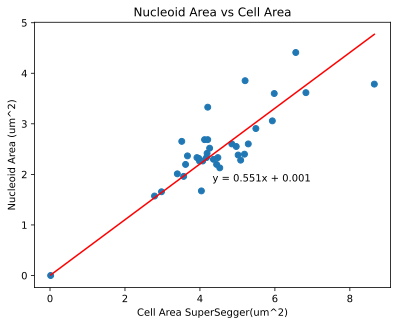

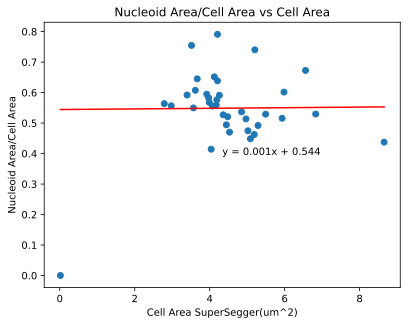

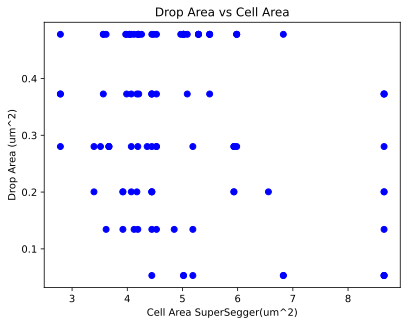

/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


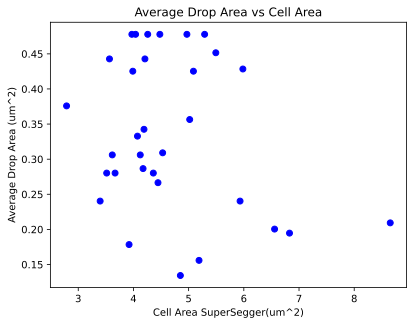

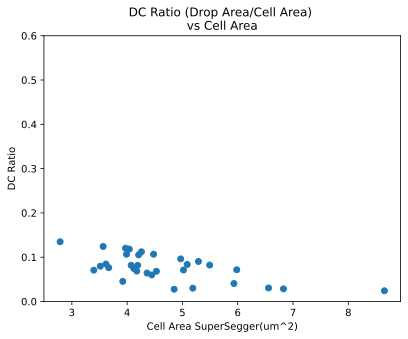

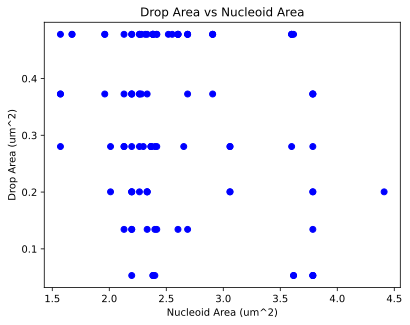

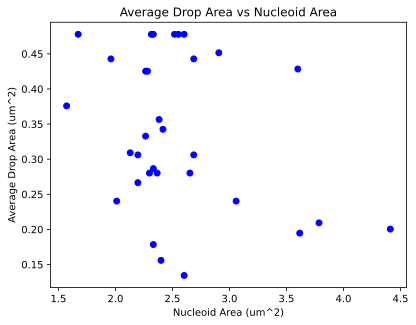

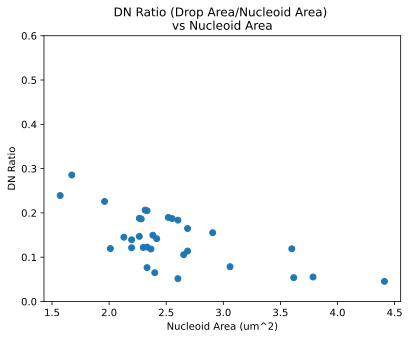

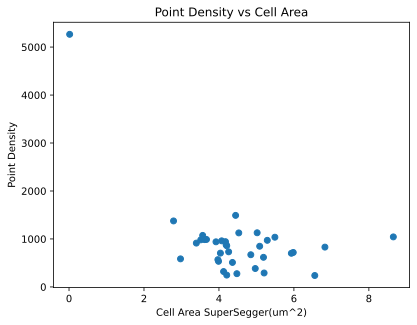

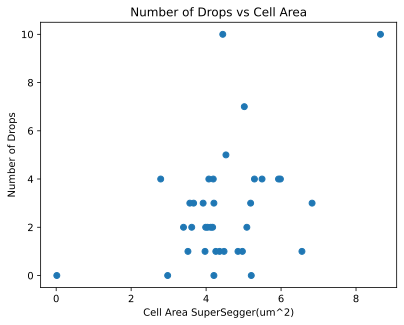

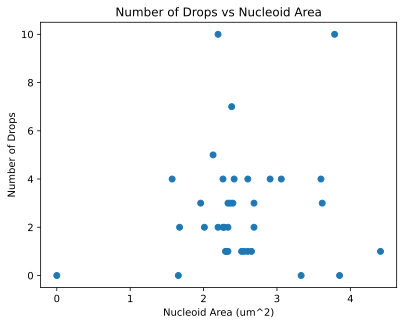

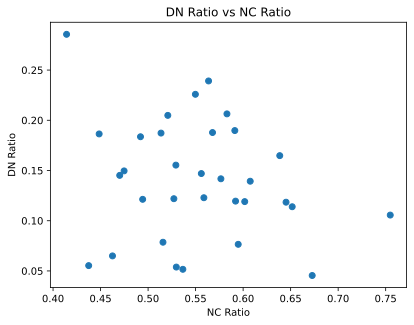

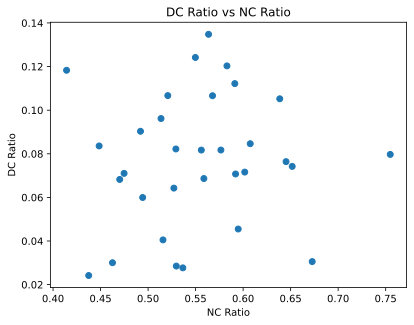

In [75]:
cell_areas = []
nuc_areas = []
drop_per_cell_area = []
point_density = []
for i,j in rp_ez.Movie.items():
    for k,l in j.Cells.items():
        cell_areas.append(l.cell_area[0]*0.0169)
        nuc_areas.append(l.nucleoid_area*0.0169)
        points_in_cell = 0.0
        for m,n in l.points_per_frame.items():
            points_in_cell+=len(n)
        point_density.append(float(points_in_cell)/(l.cell_area[0]*0.0169))

        drops_cell = []
        for m,n in l.Drop_Collection.items():
            drops_cell.append((np.pi*n[-1]**2)*0.0169)
        drop_per_cell_area.append(np.array(drops_cell))
        

NC_ratio = np.array(nuc_areas)/np.array(cell_areas)
def line_func(x,m,c):
    return m*x + c
#fit a line to NC_ratio = m*cell_area_sp + c only
line_NC = curve_fit(line_func,cell_areas,NC_ratio,bounds = (0,[1e-3,np.inf]))
line_cell_nuc = curve_fit(line_func,cell_areas,nuc_areas,bounds = (0,[np.inf,1e-3]))


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(cell_areas),np.array(nuc_areas))
#plot the fit line using lower and upper bound of cell area
ax.plot(np.linspace(min(cell_areas),max(cell_areas),100),line_func(np.linspace(min(cell_areas),max(cell_areas),100),*line_cell_nuc[0]),color="red")
#annotate the slope and intercept as y=mx+c
ax.annotate("y = "+str(round(line_cell_nuc[0][0],3))+"x + "+str(round(line_cell_nuc[0][1],3)),(0.5,0.4),xycoords="axes fraction")
ax.set_xlabel("Cell Area SuperSegger(um^2)")
ax.set_ylabel("Nucleoid Area (um^2)")
ax.set_title("Nucleoid Area vs Cell Area")
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(cell_areas),NC_ratio)
#plot the fit line using lower and upper bound of cell area
ax.plot(np.linspace(min(cell_areas),max(cell_areas),100),line_func(np.linspace(min(cell_areas),max(cell_areas),100),*line_NC[0]),color="red")
#annotate the slope and intercept as y=mx+c
ax.annotate("y = "+str(round(line_NC[0][0],3))+"x + "+str(round(line_NC[0][1],3)),(0.5,0.5),xycoords="axes fraction")
ax.set_xlabel("Cell Area SuperSegger(um^2)")
ax.set_ylabel("Nucleoid Area/Cell Area")
ax.set_title("Nucleoid Area/Cell Area vs Cell Area")
plt.show()




fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(cell_areas)):
    ax.scatter([cell_areas[i]]*len(drop_per_cell_area[i]),drop_per_cell_area[i],color="blue")
ax.set_xlabel("Cell Area SuperSegger(um^2)")
ax.set_ylabel("Drop Area (um^2)")
ax.set_title("Drop Area vs Cell Area")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(cell_areas)):
    ax.scatter(cell_areas[i],np.mean(np.array(drop_per_cell_area[i])),color="blue")
ax.set_xlabel("Cell Area SuperSegger(um^2)")
ax.set_ylabel("Average Drop Area (um^2)")
ax.set_title("Average Drop Area vs Cell Area")
plt.show()

mean_drop_per_cell_area = []
for i in range(len(drop_per_cell_area)):
    mean_drop_per_cell_area.append(np.mean(np.array(drop_per_cell_area[i])))
DC_ratio = np.array(mean_drop_per_cell_area)/np.array(cell_areas)
DN_ratio = np.array(mean_drop_per_cell_area)/np.array(nuc_areas)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(cell_areas),DC_ratio)
ax.set_xlabel("Cell Area SuperSegger(um^2)")
ax.set_ylabel("DC Ratio")
ax.set_title("DC Ratio (Drop Area/Cell Area) \nvs Cell Area")
ax.set_ylim(0,0.6)
plt.show()




#do the same but now using nuc_area
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(nuc_areas)):
    ax.scatter([nuc_areas[i]]*len(drop_per_cell_area[i]),drop_per_cell_area[i],color="blue")
ax.set_xlabel("Nucleoid Area (um^2)")
ax.set_ylabel("Drop Area (um^2)")
ax.set_title("Drop Area vs Nucleoid Area")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(nuc_areas)):
    ax.scatter(nuc_areas[i],np.mean(np.array(drop_per_cell_area[i])),color="blue")
ax.set_xlabel("Nucleoid Area (um^2)")
ax.set_ylabel("Average Drop Area (um^2)")
ax.set_title("Average Drop Area vs Nucleoid Area")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(nuc_areas),DN_ratio)
ax.set_xlabel("Nucleoid Area (um^2)")
ax.set_ylabel("DN Ratio")
ax.set_title("DN Ratio (Drop Area/Nucleoid Area) \nvs Nucleoid Area")
ax.set_ylim(0,0.6)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(cell_areas),np.array(point_density))
ax.set_xlabel("Cell Area SuperSegger(um^2)")
ax.set_ylabel("Point Density")
ax.set_title("Point Density vs Cell Area")
plt.show()


num_drops = []
for i in range(len(drop_per_cell_area)):
    num_drops.append(len(drop_per_cell_area[i]))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(cell_areas),np.array(num_drops))
ax.set_xlabel("Cell Area SuperSegger(um^2)")
ax.set_ylabel("Number of Drops")
ax.set_title("Number of Drops vs Cell Area")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(nuc_areas),np.array(num_drops))
ax.set_xlabel("Nucleoid Area (um^2)")
ax.set_ylabel("Number of Drops")
ax.set_title("Number of Drops vs Nucleoid Area")
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(NC_ratio),np.array(DN_ratio))
ax.set_xlabel("NC Ratio")
ax.set_ylabel("DN Ratio")
ax.set_title("DN Ratio vs NC Ratio")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.array(NC_ratio),np.array(DC_ratio))
ax.set_xlabel("NC Ratio")
ax.set_ylabel("DC Ratio")
ax.set_title("DC Ratio vs NC Ratio")
plt.show()

        

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_10076/1886878526.py:74: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])


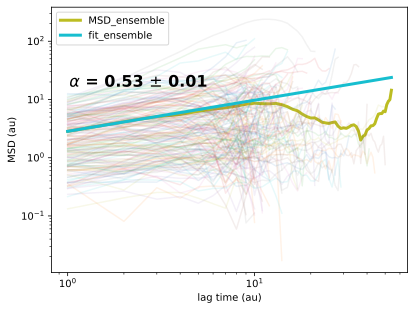

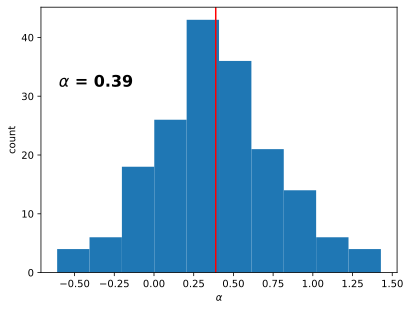

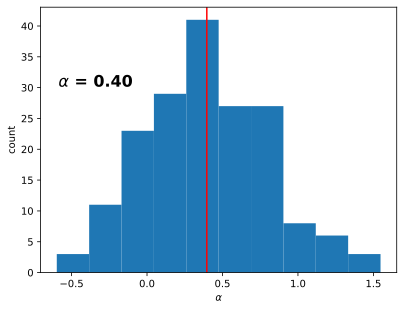

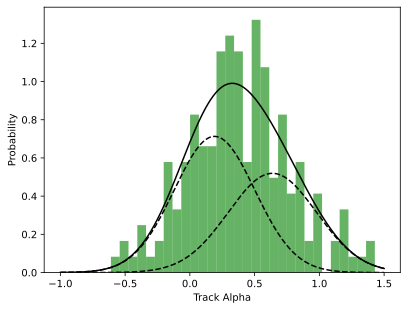

[[0.1902231 ]
 [0.63711362]]
[[[0.09682922]]

 [[0.11634619]]]


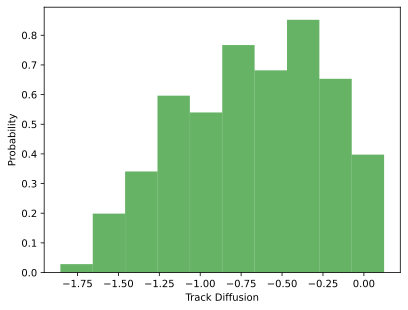

In [95]:
#convert tracks to dictionary
track_dict = rp_ez._convert_to_track_dict_bulk()
h=0.5
a = msd_calc(track_dict["OUT"],h=None,tau_lim=None,tick_space=2)

#do a GMM fit for the track alphas 
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
alphas = np.array(list(a["track_alpha"].values()))
alphas = alphas.reshape(-1,1)
gmm.fit(alphas)
labels = gmm.predict(alphas)
#plot the gaussian mixture model
plt.clf()
plt.hist(alphas, 30, density=True, alpha=0.6, color='g')
x = np.linspace(-1., 1.5, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]
plt.plot(x, pdf, '-k')
plt.plot(x, pdf_individual, '--k')
plt.xlabel("Track Alpha")
plt.ylabel("Probability")
plt.show()

print(gmm.means_)
print(gmm.covariances_)

diff_tracks_poly = con_pix_si(np.array(list(a["tavg_t1_msd"].values()))/2,which = 'msd')
plt.hist(np.log10(diff_tracks_poly), 10, density=True, alpha=0.6, color='g')
plt.xlabel("Track Diffusion")
plt.ylabel("Probability")
plt.show()



bulk msd rpoc

In [ ]:
msds = rp_ez._bulk_msd_plot()



In [ ]:
#plot the msds for "no_drop"
plt.clf()
#plt.hist(np.log10(np.array(msds["no_drop"])[:,0]),bins=10,label="no_drop",alpha=0.2)
#plot the msds for "IN"
plt.hist(np.log10(np.array(msds["in_drop"])[:,0]),bins=10,label="in_drop",alpha=0.2)
#plot the msds for "OUT"
plt.hist(np.log10(np.array(msds["ot_drop"])[:,0]),bins=10,label="out_drop",alpha=0.2)
#plot the msds for io_drop
plt.hist(np.log10(np.array(msds["io_drop"])[:,0]),bins=10,label="io_drop",alpha=0.2)
plt.legend()

plt.show()

In [114]:
def get_radius(dataset,plot=True,bins=5):
    radius = []
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            for m,n in l.Drop_Collection.items():
                radius.append(n[2])
    radius = np.array(radius)
    radius = radius[radius>0]
    radius_rp_ez = np.array(radius)*globals["olympus_pixel_size"]
    rad = []
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            for m,n in l.All_Drop_Collection.items():
                rad.append(n[2])
    rad = np.array(rad)
    rad = rad[rad>0]
    rad = rad*globals["olympus_pixel_size"]
    if plot:
        plt.hist(radius_rp_ez,alpha = 0.1,label = "viable",bins=bins)
        plt.hist(rad,alpha = 0.1, label = "All",bins=bins)
        plt.xlabel("Radius in um")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
    return [radius_rp_ez,rad]

In [ ]:
plt.clf()
viable_rp,all_rp = get_radius(rp_ez,bins=5)

{'0,0': 5.4925, '0,1': 5.019299999999999, '0,2': 4.8503, '0,3': 4.444699999999999, '1,0': 3.9208, '1,1': 4.1236, '1,2': 2.9743999999999997, '1,3': 3.5151999999999997, '1,4': 4.4784999999999995, '1,5': 3.3968999999999996, '1,6': 3.6165999999999996, '1,7': 4.5291999999999994, '2,0': 5.086899999999999, '2,1': 4.9685999999999995, '2,2': 3.5658999999999996, '2,3': 3.9715, '3,0': 4.0390999999999995, '3,1': 4.3602, '3,2': 5.9319, '3,3': 5.9826, '4,0': 8.6528, '4,1': 4.191199999999999, '4,2': 4.0729, '5,0': 5.1883, '5,1': 4.2588, '5,2': 4.1743, '5,3': 3.6672999999999996, '5,4': 2.7884999999999995, '5,5': 3.9883999999999995, '6,0': 4.2081, '6,1': 5.2052, '6,2': 6.557199999999999, '7,0': 0.0169, '7,1': 6.8275999999999994, '7,2': 5.2897, '7,3': 4.2081}
{'0,0,0,6': 0.37274642209827086, '0,0,0,7': 0.4778362426110075, '0,0,2,0': 0.4778362426110075, '0,0,4,1': 0.4778362426110075, '0,1,0,2': 0.4778362426110075, '0,1,0,3': 0.4778362426110075, '0,1,1,0': 0.0530929158456675, '0,1,1,1': 0.4778362426110075

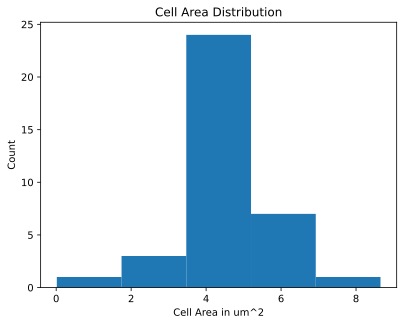

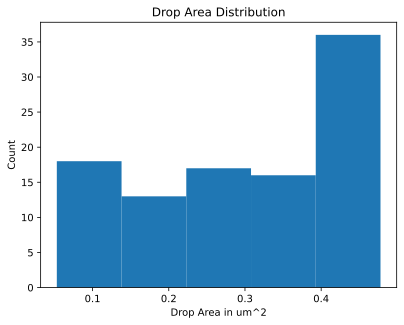

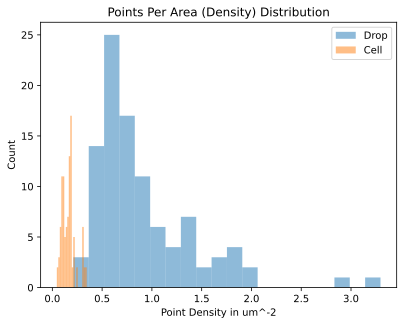

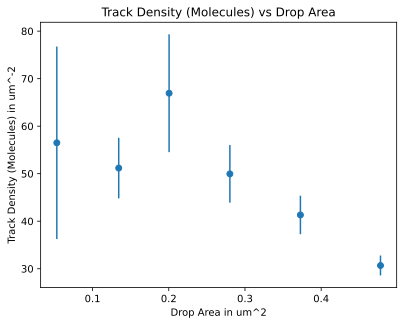

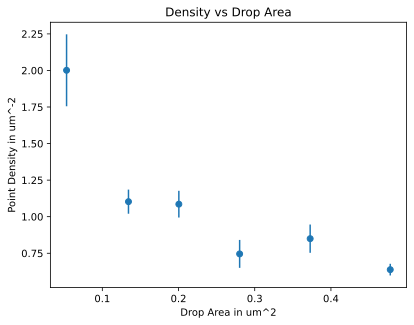

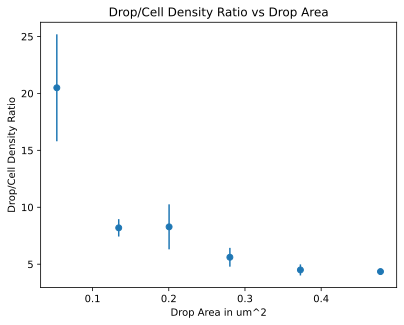

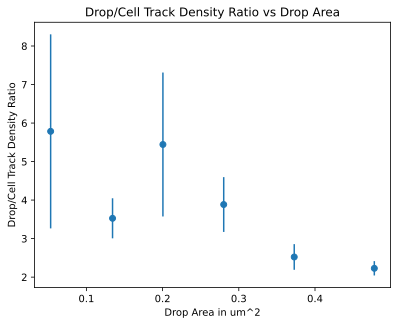

[1.9533131  8.26594201 0.62824158]
[[0.08494512 0.44328672 0.00753718]
 [0.44328672 4.6567508  0.1436364 ]
 [0.00753718 0.1436364  0.00674067]]


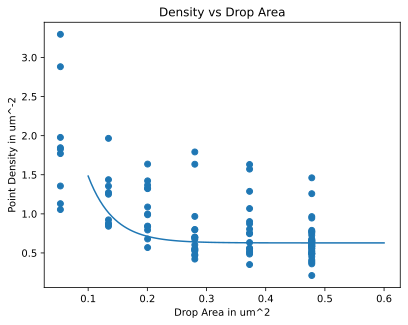

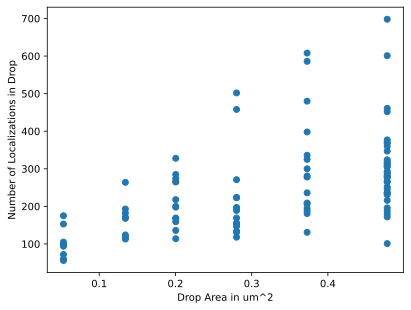

Mean density per drop: 908.5995574068074
Mean density per cell: 162.65747860143475
{'0,0,0,6': 188, '0,0,0,7': 285, '0,0,2,0': 188, '0,0,4,1': 314, '0,1,0,2': 180, '0,1,0,3': 461, '0,1,1,0': 60, '0,1,1,1': 172, '0,1,2,2': 265, '0,1,2,3': 72, '0,1,3,2': 305, '0,2,3,3': 264, '0,3,0,0': 601, '0,3,0,1': 193, '0,3,0,4': 169, '0,3,0,5': 271, '0,3,2,1': 278, '0,3,3,1': 336, '0,3,3,4': 97, '0,3,3,5': 236, '0,3,4,0': 274, '0,3,4,2': 198, '1,0,0,1': 285, '1,0,0,4': 218, '1,0,3,2': 124, '1,1,0,0': 171, '1,1,0,2': 360, '1,3,1,2': 169, '1,4,0,3': 377, '1,5,0,7': 156, '1,5,3,0': 328, '1,6,3,1': 118, '1,6,4,1': 235, '1,7,0,5': 118, '1,7,1,1': 276, '1,7,2,0': 131, '1,7,3,1': 113, '1,7,3,3': 209, '2,0,0,1': 370, '2,0,2,0': 181, '2,1,0,5': 101, '2,2,0,0': 608, '2,2,0,2': 246, '2,2,4,0': 292, '2,3,0,3': 266, '3,0,0,1': 319, '3,0,3,1': 279, '3,1,0,2': 196, '3,2,0,3': 114, '3,2,0,4': 200, '3,2,0,6': 153, '3,2,1,0': 197, '3,3,0,0': 216, '3,3,0,5': 231, '3,3,0,6': 195, '3,3,3,0': 292, '4,0,0,0': 325, '4,0,0,

<Figure size 640x480 with 0 Axes>

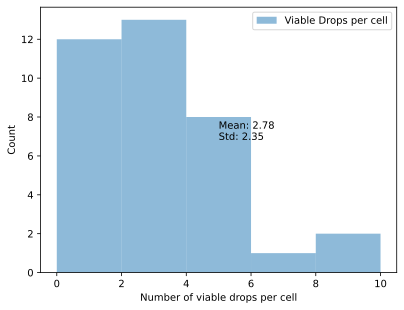

<Figure size 640x480 with 0 Axes>

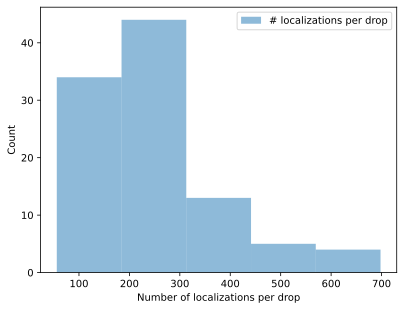

<Figure size 640x480 with 0 Axes>

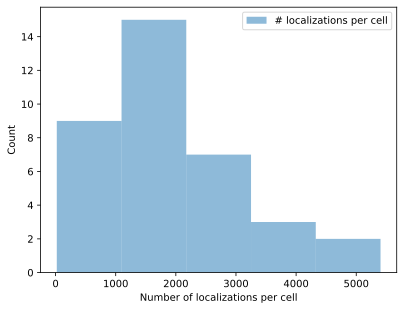

In [109]:
track_thresh = 0.9

def _avg_points_drop(dataset):
    drop_locs = {}
    total_locs = {}
    total_clusters = {}
    total_cell_locs = {}
    area_cell = {}
    area_drop = {}
    area_drop_cell_diff = {}
    total_tracks = {}
    drop_tracks = {}
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            sorted_tracks = rp_ez._convert_track_frame(np.array(l.raw_tracks),t_len_l=5,t_len_u = 100)
            total_clusters["{0},{1}".format(i,k)] = len(l.Drop_Collection)
            loc_count = 0
            for lll in sorted_tracks[1]:
                for llll in lll:
                    loc_count+=len(llll)

            total_cell_locs["{0},{1}".format(i,k)] = loc_count
            area_cell["{0},{1}".format(i,k)] = 0.0169*l.cell_area[0]
            for m,n in l.Drop_Collection.items():
                counter = 0
                total_localizations = 0
                total_tracks_t = 0
                drop_tracks_t = 0
                x,y = sorted_tracks[1],sorted_tracks[2]
                for tt in range(len(x[int(m[0])])):
                    occupancy = 0
                    total_tracks_t+=1
                    for ttt in range(len(x[int(m[0])][tt])):
                        total_localizations+=1
                        if point_inside_circle2D(n,[x[int(m[0])][tt][ttt],y[int(m[0])][tt][ttt]]):
                            counter+=1
                            occupancy+=1
                    if occupancy/len(x[int(m[0])][tt]) > track_thresh:
                        drop_tracks_t+=1

                drop_locs["{0},{1},{2}".format(i,k,m)] = counter
                total_locs["{0},{1},{2}".format(i,k,m)] = total_localizations
                total_tracks["{0},{1},{2}".format(i,k,m)] = total_tracks_t
                drop_tracks["{0},{1},{2}".format(i,k,m)] = drop_tracks_t
                area_drop["{0},{1},{2}".format(i,k,m)] = 0.0169*np.pi*n[2]**2
                area_drop_cell_diff["{0},{1},{2}".format(i,k,m)] = 0.0169*(l.cell_area[0])# - np.pi*n[2]**2)
            
    return drop_locs,total_locs,total_clusters,total_cell_locs,area_cell,area_drop,area_drop_cell_diff,total_tracks,drop_tracks

drop_localizations,total_localizations,total_clusters,total_cell_locs,area_cell,area_drop,area_drop_cell_diff,total_tracks,drop_tracks = _avg_points_drop(rp_ez)
print(area_cell)
print(area_drop)
#print the average area of a cell
print("Mean cell area: {}".format(np.mean(list(area_cell.values()))))
print("Mean drop area: {}".format(np.mean(list(area_drop.values()))))
#plot the area per cell
plt.clf()
plt.hist(np.array(list(area_cell.values())),bins=5)
plt.xlabel("Cell Area in um^2")
plt.ylabel("Count")
plt.title("Cell Area Distribution")
plt.show()

#plot the area per drop
plt.clf()
plt.hist(np.array(list(area_drop.values())),bins=5)
plt.xlabel("Drop Area in um^2")
plt.ylabel("Count")
plt.title("Drop Area Distribution")
plt.show()

#plot the density per drop and per cell on the same plot as a histogram
plt.clf()
plt.hist(np.array(list(drop_localizations.values()))/np.array(list(area_drop.values()))/1000,bins=20,alpha=0.5,label="Drop")
plt.hist(np.array(list(total_localizations.values()))/np.array(list(area_drop_cell_diff.values()))/1000,bins=20,alpha=0.5,label="Cell")
plt.xlabel("Point Density in um^-2")
plt.ylabel("Count")
plt.legend()
plt.title("Points Per Area (Density) Distribution")
plt.show()

track_density_drop = np.array(list(drop_tracks.values()))/np.array(list(area_drop.values()))
track_density_cell = np.array(list(total_tracks.values()))/np.array(list(area_drop_cell_diff.values()))
track_drop_cell_density_ratio = track_density_drop/track_density_cell




density_drop = np.array(list(drop_localizations.values()))/np.array(list(area_drop.values()))/1000
density_cell = np.array(list(total_localizations.values()))/np.array(list(area_drop_cell_diff.values()))/1000
drop_cell_density_ratio = density_drop/density_cell
drop_area = np.array(list(area_drop.values()))

unique_drop_area = {}
unique_density_ratio_area = {}
unique_track_density_ratio_area = {}
unique_track_density_area = {}
for i in range(len(drop_area)):
    if str(drop_area[i]) not in unique_drop_area:
        unique_drop_area[str(drop_area[i])] = []
    else:
        unique_drop_area[str(drop_area[i])].append(density_drop[i])
    
    if str(drop_area[i]) not in unique_density_ratio_area:
        unique_density_ratio_area[str(drop_area[i])] = []
    else:
        unique_density_ratio_area[str(drop_area[i])].append(drop_cell_density_ratio[i])
    
    if str(drop_area[i]) not in unique_track_density_ratio_area:
        unique_track_density_ratio_area[str(drop_area[i])] = []
    else:
        unique_track_density_ratio_area[str(drop_area[i])].append(track_drop_cell_density_ratio[i])
    
    if str(drop_area[i]) not in unique_track_density_area:
        unique_track_density_area[str(drop_area[i])] = []
    else:
        unique_track_density_area[str(drop_area[i])].append(track_density_drop[i])

#for each element in unique drop area find the mean of its values
unique_drop_area_list = []
unique_drop_area_mean = []
unique_drop_area_SE = []
#do the same for the density ratio
unique_density_ratio_area_mean = []
unique_density_ratio_area_SE = []
#do the same for the track density ratio
unique_track_density_ratio_area_mean = []
unique_track_density_ratio_area_SE = []
#do the same for the track density
unique_track_density_area_mean = []
unique_track_density_area_SE = []


for i,j in unique_track_density_ratio_area.items():
    unique_track_density_ratio_area_mean.append(np.mean(j))
    unique_track_density_ratio_area_SE.append(np.std(j)/np.sqrt(len(j)))


for i,j in unique_density_ratio_area.items():
    unique_density_ratio_area_mean.append(np.mean(j))
    unique_density_ratio_area_SE.append(np.std(j)/np.sqrt(len(j)))


for i,j in unique_drop_area.items():
    unique_drop_area_list.append(float(i))
    unique_drop_area_mean.append(np.mean(j))
    unique_drop_area_SE.append(np.std(j)/np.sqrt(len(j)))

for i,j in unique_track_density_area.items():
    unique_track_density_area_mean.append(np.mean(j))
    unique_track_density_area_SE.append(np.std(j)/np.sqrt(len(j)))

plt.clf()
plt.errorbar(unique_drop_area_list,unique_track_density_area_mean,yerr=unique_track_density_area_SE,fmt='o')
plt.xlabel("Drop Area in um^2")
plt.ylabel("Track Density (Molecules) in um^-2")
plt.title("Track Density (Molecules) vs Drop Area")
plt.show()


plt.clf()
plt.errorbar(unique_drop_area_list,unique_drop_area_mean,yerr=unique_drop_area_SE,fmt='o')
plt.xlabel("Drop Area in um^2")
plt.ylabel("Point Density in um^-2")
plt.title("Density vs Drop Area")
plt.show()

plt.clf()
plt.errorbar(unique_drop_area_list,unique_density_ratio_area_mean,yerr=unique_density_ratio_area_SE,fmt='o')
plt.xlabel("Drop Area in um^2")
plt.ylabel("Drop/Cell Density Ratio")
plt.title("Drop/Cell Density Ratio vs Drop Area")
plt.show()

plt.clf()
plt.errorbar(unique_drop_area_list,unique_track_density_ratio_area_mean,yerr=unique_track_density_ratio_area_SE,fmt='o')
plt.xlabel("Drop Area in um^2")
plt.ylabel("Drop/Cell Track Density Ratio")
plt.title("Drop/Cell Track Density Ratio vs Drop Area")
plt.show()



    

#plot the density_drop as a function of drop_area
#plot an exponential decay fit to the data

def exp_decay(x,a,b,c):
    return a*np.exp(-b*x) + c

popt,pcov = curve_fit(exp_decay,drop_area,density_drop)
print(popt)
print(pcov)


plt.clf()
plt.scatter(drop_area,density_drop)
plt.plot(np.linspace(0.1,0.6,100),exp_decay(np.linspace(0.1,1.5,100),*popt),label="Fit")
plt.xlabel("Drop Area in um^2")
plt.ylabel("Point Density in um^-2")
plt.title("Density vs Drop Area")
plt.show()

plt.scatter(drop_area,np.array(list(drop_localizations.values())))
plt.xlabel("Drop Area in um^2")
plt.ylabel("Number of Localizations in Drop")
plt.show()


#print the average density per drop
print("Mean density per drop: {}".format(np.mean(np.array(list(drop_localizations.values()))/np.array(list(area_drop.values())))))
#print the average density per cell
print("Mean density per cell: {}".format(np.mean(np.array(list(total_localizations.values()))/np.array(list(area_drop_cell_diff.values())))))


print(drop_localizations)
print(total_localizations)
print(total_clusters)
print(total_cell_locs)
avg_drop_localizations = np.mean(list(drop_localizations.values()))
std_drop_localizations = np.std(list(drop_localizations.values()))
print(avg_drop_localizations,std_drop_localizations,np.mean(list(total_localizations.values())),np.std(list(total_localizations.values())))  
print("Mean number of clusters per cell: {}".format(np.mean(list(total_clusters.values()))))   
#plot the distribution of localizations per drop
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(list(total_clusters.values()),alpha=0.5,label="Viable Drops per cell",bins=5)
ax.set_xlabel("Number of viable drops per cell")
ax.set_ylabel("Count")
#add a annotation with the mean and std
ax.annotate("Mean: {0:.2f}\nStd: {1:.2f}".format(np.mean(list(total_clusters.values())),np.std(list(total_clusters.values()))),xy=(0.5,0.5),xycoords="axes fraction")
ax.legend()
plt.show()
#plot the distribution of localizations per drop
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(list(drop_localizations.values()),alpha=0.5,label="# localizations per drop",bins=5)
ax.set_xlabel("Number of localizations per drop")
ax.set_ylabel("Count")
ax.legend()
plt.show()
#plot the total_localizations per cell 
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(list(total_cell_locs.values()),alpha=0.5,label="# localizations per cell",bins=5)
ax.set_xlabel("Number of localizations per cell")
ax.set_ylabel("Count")
ax.legend()
plt.show()
    



In [ ]:

#plt.imshow(rp_ez.Movie["0"].Cells["0"].cell_mask, cmap='gray', interpolation='none')
mask = rp_ez.Movie["0"].Cells["0"].cell_mask
cell = read_file(rp_ez._get_movie_path('0',1))
masked = cell*mask


In [ ]:
movie_ID = '1'
a = rp_ez.Movie[movie_ID].Movie_nucleoid
b = blob_detection(path = a,\
                    threshold=5e-2,
                    overlap=0.5,
                    min_sigma=1/np.sqrt(2),
                    max_sigma=3.5/np.sqrt(2),
                    num_sigma=500,
                    median = False,
                    verbose=True)
b._update_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":1,
                                    "centroid_range":0.01,
                                    "height_range":2})
c = b.detection(type='skimage')
aa = read_file(a)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(aa,cmap = 'Greys')
# for i in rp_ez.Movie['1'].Cells['1'].All_Drop_Collection.values():
#     cir = plt.Circle((i[0],i[1]),radius=i[2], fill = False)
#     ax.add_artist(cir)
for i in c:
    cir = plt.Circle((i[1],i[0]),radius=i[2]/2, fill = False)
    ax.add_artist(cir)
plt.show()
print(c)


In [ ]:
print(rp_ez.Movie[movie_ID].Movie_nucleoid)


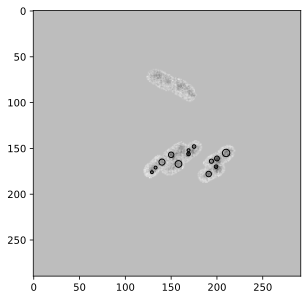

{'0,0': array([139.        ,  79.        ,   1.59059059]), '0,2': array([132.,  72.,   3.])}
{'0,0': {'Fitted': array([139.02395346,  78.8371827 ,   1.8439583 ,   1.59082458]), 'Scale': array([139.        ,  79.        ,   1.59059059]), 'Fit': <lmfit.minimizer.MinimizerResult object at 0x2a2180a90>}, '0,2': {'Fitted': array([132.23509743,  72.06407715,   2.57926951,   4.41421356]), 'Scale': array([132.,  72.,   3.]), 'Fit': <lmfit.minimizer.MinimizerResult object at 0x2a212c880>}}
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 9
    # data points      = 36
    # variables        = 6
    chi-square         = 196.715364
    reduced chi-square = 6.55717882
    Akaike info crit   = 73.1366002
    Bayesian info crit = 82.6377139
[[Variables]]
    height:      24.0276092 +/- 1.73370109 (7.22%) (init = 25)
    centroid_x:  78.8371827 +/- 0.09242557 (0.12%) (init = 79)
    centroid_y:  139.023953 +/- 0.07939099 (0.06%) (init = 139)
    sigma_x:     1.3038754

In [46]:
from scipy.ndimage import filters
#fig,ax = run_analysis_plotting.plot_img(rp_ez,1,movie_ID,1,int("0,2"[0]))
a =rp_ez._get_movie_path('1',3)
b = blob_detection(path = a,\
                    median= False,\
                    threshold= 5e-5, \
                    min_sigma= 1, \
                    max_sigma = 3.5, \
                    num_sigma= 500, \
                    overlap = 0)
c = b.detection(type = 'bp')
aa = read_file(a)
fig = plt.figure()
ax = fig.add_subplot()
#ax.imshow(filters.median_filter(aa,size =1),cmap = 'Greys')
ax.imshow(aa,cmap = 'Greys')
# for i in rp_ez.Movie['1'].Cells['7'].All_Drop_Collection.values():
#     cir = plt.Circle((i[0],i[1]),radius=i[2], fill = False)
#     ax.add_artist(cir)
for i in c:
    cir = plt.Circle((i[1],i[0]),radius=i[2], fill = False)
    ax.add_artist(cir)
plt.show()
print(rp_ez.Movie['1'].Cells['1'].All_Drop_Collection)
print(rp_ez.Movie['1'].Cells['1'].All_Drop_Verbose)
print(report_fit(rp_ez.Movie['1'].Cells['1'].All_Drop_Verbose['0,0']["Fit"]))

In [ ]:
samples = [5,7,10,15,20,30]
axis_x = 2
axis_y = 3
x,y,fig,ax=run_analysis_plotting.draw_item(rp_ez,(axis_x,axis_y),all_tracks=False,cell_ID = '0',movie_ID='1')
x_y = np.array([[a,b] for a,b in zip(x,y)])
for i in range(axis_x):
    for j in range(axis_y):
        clustering = OPTICS(min_samples=samples[i*axis_x + j]).fit(x_y)
        a = ax[i,j].scatter(x,y,s= 1,c = clustering.labels_)
fig.colorbar(a)
fig.tight_layout()
plt.show()

In [ ]:
for i in samples:
    clustering = OPTICS(min_samples=i).fit(x_y)
    a = plt.scatter(x,y,s= 1,c = clustering.labels_)
    plt.colorbar(a)
    plt.title("min_samples = {0}".format(i))
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
sim = simulate_foci.sim_foci(max_x = 200,
                            min_x = 0,
                            radius = 50,
                            center = [100,100],
                            total_points = 500,
                            density_dif = 5.0,
                            pdf = simulate_foci.tophat_function_2d)
sim_xy = sim._makePoints()
for i in samples:
    clustering = OPTICS(min_samples=i).fit(sim_xy)
    fig = plt.figure()
    ax = fig.add_subplot()
    a = ax.scatter(sim_xy[:,0],sim_xy[:,1],s= 2,c = clustering.labels_)
    plt.colorbar(a)
    cir = plt.Circle(sim.center,radius = sim.radius,fill = False)
    ax.set_title("min_samples = {0}".format(i))
    ax.add_artist(cir)

In [ ]:
#%matplotlib qt 
#train data on the best of above: samples = 30
clustering_fit = DBSCAN(min_samples=30,eps = 1.0).fit(sim_xy)
print(rp_ez.Movie['1'].Cells['1'].Drop_Collection)
print(rp_ez.Movie['1'].Cells['4'].Drop_Collection)
x,y,fig,ax=run_analysis_plotting.draw_item(rp_ez,cell_ID = ['1'],movie_ID='1',movie_frame_index = 0,all_tracks = 1)
x_y = np.array([[a,b] for a,b in zip(x,y)])
clustering = clustering_fit.fit_predict(x_y)
a = ax.scatter(x,y,s= 1,c = clustering)
fig.colorbar(a)
fig.tight_layout()
plt.show()
print(len(x))
fig = plt.figure()
ax = fig.add_subplot()
a = ax.scatter(x,y,s= 20,c = clustering,cmap = "Greys")
fig.colorbar(a)
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()

In [ ]:
clustering_fit = DBSCAN(min_samples=30,eps = 1.0).fit(sim_xy)
x,y,fig,ax=run_analysis_plotting.draw_item(rp_ez,cell_ID = ['1'],movie_ID='1',movie_frame_index = 0,all_tracks = 1)
x_y = np.array([[a,b] for a,b in zip(x,y)])
clustering = clustering_fit.fit_predict(x_y)
a = ax.scatter(x,y,s= 1,c = clustering)
fig.colorbar(a)
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()

non_cluster = np.where((np.asarray(clustering) >= 0))[0]
# fig = plt.figure()
# ax = fig.add_subplot()
# a = read_file(rp_ez.Movie['1'].Movie_nucleoid)
# ax.imshow(a,cmap = 'Greys')
# a = ax.scatter(np.asarray(x)[non_cluster],np.asarray(y)[non_cluster],s= 20,c = clustering[non_cluster],cmap = "Greys")
# fig.colorbar(a)
# ax.set_xlim((120,190))
# ax.set_ylim((55,100))
# plt.gca().invert_yaxis()
# fig.tight_layout()
# plt.show()


fig = plt.figure()
ax = fig.add_subplot()
a = read_file(rp_ez.Movie['1'].Movie_nucleoid)
ax.imshow(a,cmap = 'Greys')
a = ax.scatter(np.asarray(x)[non_cluster],np.asarray(y)[non_cluster],s= 20,c = clustering[non_cluster],cmap = "Greys")
fig.colorbar(a)
ax.set_xlim((170,240))
ax.set_ylim((140,200))
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()


fig = plt.figure()
ax = fig.add_subplot()
a = read_file(rp_ez.Movie['1'].Movie_nucleoid)
ax.imshow(a,cmap = 'Greys')
#a = ax.scatter(np.asarray(x)[non_cluster],np.asarray(y)[non_cluster],s= 20,c = clustering[non_cluster],cmap = "Greys")
#fig.colorbar(a)
ax.set_xlim((170,240))
ax.set_ylim((140,200))
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()

In [ ]:
#only take points in cluster one at a time
unique_clusters = np.unique(clustering)[np.unique(clustering) > -1]
cluster_xy = []
for i in range(len(unique_clusters)):
    indx_i = clustering == unique_clusters[i]
    indx_i = np.array(indx_i)
    x_indx = np.array(x)[indx_i]
    y_indx = np.array(y)[indx_i]
    #make pair 
    x_y_indx = np.array([[a,b] for a,b in zip(x_indx,y_indx)])
    cluster_xy.append(x_y_indx)

cluster_circles = []
for i in cluster_xy:
    circle = smallestenclosingcircle.make_circle(i)
    cluster_circles.append(circle)

fig = plt.figure()
ax = fig.add_subplot()
a = ax.scatter(x,y,s= 20,c = clustering,cmap = "Reds")

for i in cluster_circles:
    Drawing_uncolored_circle = create_circle_obj(i,fill = False)
    ax.add_artist(Drawing_uncolored_circle)


fig.colorbar(a)
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()
print(cluster_circles)

In [ ]:
from matplotlib.pyplot import plot

which_object = rp_ez
movie_ID = '0'
cell_ID = '3'
drop_ID = '0,0'
copies = 1
print(rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection)
drop = which_object.Movie[movie_ID].Cells[cell_ID].Drop_Collection[drop_ID]
cir = create_circle_obj(drop)
fig,ax = run_analysis_plotting.plot_img(rp_ez,copies,movie_ID,cell_ID,int(drop_ID[0]))

x_y = []

def plot_lines(dic,color,fig,a,color_first = None,color_last = None):
    len_tracks = []
    for i,j in dic.items():
        ax.plot(j.X,j.Y,color = color)
        len_tracks.append(len(j.X))
        if color_first != None:
            ax.plot(j.X[0],j.Y[0],color = color_first,markersize = 2,marker = 'o')
        if color_last != None:
            ax.plot(j.X[-1],j.Y[-1],color = color_last,markersize = 2,marker = 'o')
    return [len_tracks,fig,ax]
    
def plot_lines_bulk(movie_ID, cell_ID, drop_ID, fig, ax, plot_lines,**kwargs):
    if kwargs.get("IN",False) == True:
        len_intracks = plot_lines(rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IN_Trajectory_Collection,
                            'red',fig,ax,color_first='black',color_last='grey')[0]
    else:
        len_intracks = None
    if kwargs.get("Io",False) == True:
        len_iotracks = plot_lines(rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IO_Trajectory_Collection,
                            'orange',fig,ax,color_first='black',color_last='grey')[0]
    else:
        len_iotracks = None
    if kwargs.get("OT",False) == True:
        len_ottracks = plot_lines(rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].OUT_Trajectory_Collection,
                            'green',fig,ax,color_first='black',color_last='grey')[0]
    else:
        len_ottracks = None                            
    return len_intracks,len_iotracks,len_ottracks

len_intracks, len_iotracks, len_ottracks = plot_lines_bulk(movie_ID, cell_ID, drop_ID, fig, ax, plot_lines, IN = False, IO = False, OT = False)

#use bounding box of the cell to define the limits of viewing
bounding_box = which_object.Movie[movie_ID].Cells[cell_ID].bounding_box
extended_view = 20
ax.set_xlim((np.min(np.asarray(bounding_box[:,0]))-extended_view,np.max(np.asarray(bounding_box[:,0]))+extended_view))
ax.set_ylim((np.min(np.asarray(bounding_box[:,1]))-extended_view,np.max(np.asarray(bounding_box[:,1]))+extended_view))
ax.add_artist(cir)
for i,j in which_object.Movie[movie_ID].Cells[cell_ID].All_Drop_Collection.items():
    print(j)
    cir = create_circle_obj(j)
    ax.add_artist(cir)
ax.set_title("Track Info: IN = {0}, IO = {1}, OT = {2}".format(len_intracks,len_iotracks,len_ottracks))
plt.gca().invert_yaxis()
plt.show()
print(which_object.Movie[movie_ID].Cells[cell_ID].cell_area, which_object.Movie[movie_ID].Cells[cell_ID].cell_axis_lengths)
print(bounding_box)


In [ ]:
from matplotlib.pyplot import plot

which_object = rp_ez
movie_ID = '1'
cell_ID = '0'
drop_ID = '0,1'
copies = 1
print(rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection)
drop = which_object.Movie[movie_ID].Cells[cell_ID].Drop_Collection[drop_ID]
cir = create_circle_obj(drop)
fig,ax = run_analysis_plotting.plot_img(rp_ez,copies,movie_ID,cell_ID,int(drop_ID[0]))

x_y = []

def plot_lines(dic,color,fig,a,color_first = None,color_last = None):
    len_tracks = []
    for i,j in dic.items():
        ax.plot(j.X,j.Y,color = color)
        len_tracks.append(len(j.X))
        if color_first != None:
            ax.plot(j.X[0],j.Y[0],color = color_first,markersize = 2,marker = 'o')
        if color_last != None:
            ax.plot(j.X[-1],j.Y[-1],color = color_last,markersize = 2,marker = 'o')
    return [len_tracks,fig,ax]

len_intracks, len_iotracks, len_ottracks = plot_lines_bulk(movie_ID, cell_ID, drop_ID, fig, ax, plot_lines, IN = True, IO = False, OT = False)

#use bounding box of the cell to define the limits of viewing
bounding_box = which_object.Movie[movie_ID].Cells[cell_ID].bounding_box
extended_view = 10
ax.set_xlim((np.min(np.asarray(bounding_box[:,0]))-extended_view,np.max(np.asarray(bounding_box[:,0]))+extended_view))
ax.set_ylim((np.min(np.asarray(bounding_box[:,1]))-extended_view,np.max(np.asarray(bounding_box[:,1]))+extended_view))
ax.add_artist(cir)
ax.set_title("Track Info: IN = {0}, IO = {1}, OT = {2}".format(len_intracks,len_iotracks,len_ottracks))

plt.gca().invert_yaxis()
plt.show()
print(which_object.Movie[movie_ID].Cells[cell_ID].cell_area, which_object.Movie[movie_ID].Cells[cell_ID].cell_axis_lengths)
print(bounding_box)

def get_track_Tmsd(movie_ID, cell_ID, drop_ID):
    for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IN_Trajectory_Collection.items():
        print("IN: ", j.MSD_total_um, " Distance from out ", j.distance_from_drop)
    for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IO_Trajectory_Collection.items():
        print("IO: ", j.MSD_total_um, " Distance from out ", j.distance_from_drop)
    for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].OUT_Trajectory_Collection.items():
        print("OT: ", j.MSD_total_um, " Distance from out ", j.distance_from_drop)

get_track_Tmsd(movie_ID, cell_ID, drop_ID)

In [ ]:
plt.clf()
viable_rp,all_rp = get_radius(rp_ez)

In [ ]:
%matplotlib widget
rp_ez_ba = boundary_analysis(dataset = rp_ez.Movie)
rp_ez_aa = rp_ez_ba.directional_displacement_bulk(IN = True,IO = True, OT = True)
a = rp_ez_ba.plot_directional_displacements(dir_displacements = rp_ez_aa[0],dist_center = rp_ez_aa[1],angles = rp_ez_aa[2])
def adjust_axis(a,lim = 1.5):
    a[2].set_xlim((-lim,lim))
    a[2].set_ylim((-lim,lim))
    a[2].set_aspect(1, adjustable='box')
    plt.show()
adjust_axis(a,lim = 3)

def plot_pairCorrelation(aa,**kwargs):
    x,y = rt_to_xy(np.array(aa[1]),aa[2])
    g_r, radii, interior_points = centered_pairCorrelation_2D(x = x,
                                                        y = y,
                                                        center = kwargs.get('center',[0,0]),
                                                        rMax = kwargs.get('rMax',1.1),
                                                        dr = kwargs.get('dr',0.1))
    if kwargs.get("fig", None) == None:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.plot(radii,g_r)
    else:
        kwargs.get("ax").plot(radii,g_r)
    return [g_r, radii, interior_points,fig,ax]


In [ ]:
angles = []
centers = []
disps = []
for i,j in rp_ez.Movie.items():
    for k,l in j.Cells.items():
        sorted_tracks = rp_ez._convert_track_frame(track_set=np.array(l.raw_tracks),t_len_l = 1)
        drops = l._convert_viableDrop_list()
        for sf in range(len(sorted_tracks[0])):
            x = sorted_tracks[1][sf]
            y = sorted_tracks[2][sf]
            drop = drops[sf]
            if len(drop) > 0:
                angle,center,disp = boundary_analysis._directional_variableTracks(x,y,drop)
                angles+=angle
                centers+=center
                disps+=disp



In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*rt_to_xy(np.array(rp_ez_aa[1]),rp_ez_aa[2]),s = 0.1)
cir = plt.Circle((0,0),1,fill = False)
ax.add_artist(cir)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()


In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*rt_to_xy(np.array(centers),angles),s = 0.1)
cir = plt.Circle((0,0),1,fill = False)
ax.add_artist(cir)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()

In [ ]:
#simulate drops of different radius 
def sim_drop(radius = 1,center = [100,100],**kwargs):
    sim = simulate_foci.sim_foci(max_x = kwargs.get("max_x",400),
                            min_x = 0,
                            radius = radius,
                            center = center,
                            total_points = kwargs.get("points",1000),
                            density_dif = kwargs.get("density",50.0),
                            pdf = simulate_foci.tophat_function_2d)
    sim_xy = sim._makePoints()
    return sim_xy
radi = np.arange(10,50,3)
centers = np.random.randint(50,150,size = (2,len(radi)))

mapped = []
for i in range(len(radi)):
    xy = sim_drop(radius=radi[i],center=centers[:,i])
    mapped.append([xy[:,0],xy[:,1],[centers[:,i][0],centers[:,i][1],radi[i]]])




angle,center,disp = boundary_analysis._directional_displacement_utility(mapped)
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*rt_to_xy(np.array(center),angle),s = 0.1)
cir = plt.Circle((0,0),1,fill = False)
ax.add_artist(cir)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()

In [ ]:
for i in range(len(mapped)):
    fig = plt.figure()
    ax = fig.add_subplot()
    a = ax.scatter(mapped[i][0],mapped[i][1],s= 2)
    cir = plt.Circle((mapped[i][2][0],mapped[i][2][1]),mapped[i][2][2],fill = False)
    ax.add_artist(cir)
    plt.show()

In [ ]:
movie_ID = '1'
cell_ID = '1'
frame = 0

seg_frame = rp_ez._get_movie_path(movie_ID=movie_ID,frame=frame)
gfp_img = rp_ez._get_nucleoid_path(movie_ID=movie_ID,cell_ID=cell_ID,full_path=False)
shape = np.shape(gfp_img)
x,y = np.meshgrid(np.arange(0,shape[0],1),np.arange(0,shape[1],1),indexing = 'ij')

print(rp_ez.Movie[movie_ID].Cells[cell_ID].bounding_box)
print(rp_ez.Movie[movie_ID].Cells[cell_ID].r_offset)
print(rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection)


def rescale_range(x,min_x,max_x,a,b):
    '''https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range'''
    return ((b-a)*(x - min_x)/(max_x - min_x)) + a

def _gaussian_mesh_helper(mesh_2d,initial_xy,sub_arr = [3,3]):
    ''' 
    takes a 2d_mesh (image data) and a bounding box to return a list of (x,y,z) in that bounding box
    box is implimented from the center point of the pixel.
    '''
    #make x,y,z list from mesh data
    #find dims
    sub_arr = np.array(sub_arr)
    initial_xy = np.array(initial_xy)
    minx,miny = initial_xy - sub_arr
    maxx,maxy = initial_xy + sub_arr
    minx,miny = int(minx),int(miny)
    maxx,maxy =int(maxx),int(maxy)
    centers = [rescale_range(initial_xy[0],minx,maxx,0,-2*sub_arr[1]+1),rescale_range(initial_xy[1],miny,maxy,0,-2*sub_arr[0]+1)]
    x,y = np.meshgrid(np.arange(minx,maxx,1),np.arange(miny,maxy,1))
    mesh_view = mesh_2d[minx:maxx,miny:maxy]
    
    return [x-maxx+1,y-maxy+1,mesh_view,centers]

xk,yk,zk,centers = _gaussian_mesh_helper(gfp_img,rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection['0,1'][:-1],sub_arr=[10,10])
x_cent = centers[0]
y_cent = centers[1]
# plt.clf()
# plt.imshow(zk)
# plt.show()
import lmfit
from lmfit import Parameters, minimize, report_fit
import tensorflow_probability as tfp
import tensorflow as tf

def sim_foci_pdf(max_x,radius,center,density_dif,points,sigma):
    min_x = 0
    max_x = max_x
    x1,y1 = tf.cast(tf.linspace(min_x,max_x,max_x),tf.float64), tf.cast(tf.linspace(min_x,max_x,max_x),tf.float64)
    a = sim_drop(radius=radius,center=center,density_dif = density_dif,max_x = max_x, points = points)
    x = a[:,0]
    y = a[:,1]
    sigma = np.array([sigma,sigma],dtype = type(a[0][0]))
    z = 0
    for i in range(len(a)):
        z += np.array(simulate_foci.get_gaussian(a[i], sigma,domain = [x1,x1]))
    return x1,y1,z

x1, y1, z = sim_foci_pdf(max_x=200,radius=2.5,center=[100,100],density_dif=100.,points=1000,sigma=1)

def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y, offset):
    return np.exp(-(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)/2.0) + offset

def gaus_constrained(x,y,sig_x,offset,kwargs = {}):
    return gaussian2D(x, y, cen_x = kwargs.get("cen_x",100), cen_y = kwargs.get("cen_y",100), sig_x = sig_x, sig_y = kwargs.get("sig_y",sig_x),offset = offset)


def residuals(p, x, y, z,**kwargs):
    height = p["height"].value
    #cen_x = p["centroid_x"].value
    #cen_y = p["centroid_y"].value
    sigma_x = p["sigma_x"].value
    #sigma_y = p["sigma_y"].value
    offset = p["background"].value
    return (z - height*gaus_constrained(x,y,sigma_x,offset,kwargs=kwargs))#gaussian2D(x,y, cen_x = cen_x, cen_y = cen_y, sig_x = sigma_x, sig_y = sigma_y, offset = offset))

def initalize_2dgaus(**kwargs):
    initial = Parameters()
    for i,j in kwargs.items():
        initial.add(i,value = j)
    # initial.add("height",value=.3)
    # #initial.add("centroid_x",value=100.)
    # #initial.add("centroid_y",value=100.)
    # initial.add("sigma_x",value=20.)
    # #initial.add("sigma_y",value=20.)
    # initial.add("background",value=0.015)
    return initial

initial = initalize_2dgaus(height = 0.3,sigma_x = 20.,background = 0.015)

xx,yy = np.meshgrid(x1,y1,indexing="xy")
fit = minimize(residuals, initial, args=(yy, xx, z), kws = {"cen_x":100,"cen_y":100})
print(report_fit(fit))
#z1 = fit.params["height"]*gaussian2D(xx,yy, cen_x = fit.params["centroid_x"], cen_y = fit.params["centroid_y"], sig_x = fit.params["sigma_x"], sig_y = fit.params["sigma_y"], offset = fit.params["background"])
z1 = fit.params["height"]*gaus_constrained(xx,yy,fit.params["sigma_x"],fit.params["background"])
# plt.clf() 
# #Change the Size of Graph using Figsize
# fig = plt.figure(figsize=(10,10))
 

# #Generating a 3D sine wave
# ax = plt.axes(projection='3d')

# x,y = np.meshgrid(x1,y1)
# ax.plot_wireframe(x,y,z)
# ax.plot_wireframe(x,y,z1,color = "green")
# #plt.imshow(gfp_img,cmap = "Greys")
# plt.show()
initial = initalize_2dgaus(height = 10000,sigma_x = 2.,background = 100)
fit = minimize(residuals, initial, args=(yk, xk, zk), kws = {"cen_x":x_cent,"cen_y":y_cent})
print(report_fit(fit))
z1 = fit.params["height"]*gaus_constrained(xk,yk,fit.params["sigma_x"],fit.params["background"],kwargs = {"cen_x":x_cent,"cen_y":y_cent})
plt.clf() 

#Change the Size of Graph using Figsize
fig = plt.figure(figsize=(10,10))
 

#Generating a 3D sine wave
ax = plt.axes(projection='3d')

ax.plot_wireframe(xk,yk,zk)
ax.scatter3D(x_cent,y_cent,10000)
ax.plot_wireframe(xk,yk,z1,color = "green")
#plt.imshow(gfp_img,cmap = "Greys")
plt.show()

In [ ]:
rp_ez.Movie['0'].Cells['0'].Trajectory_Collection

In [ ]:
a = rp_ez_ba.directional_displacement(rp_ez.Movie['1'].Cells['0'].Trajectory_Collection['0,1'].IN_Trajectory_Collection,rp_ez.Movie['1'].Cells['0'])
b = rp_ez_ba.plot_directional_displacements(dir_displacements = a[2],dist_center = a[1],angles = a[0])
adjust_axis(b)
print(len(a[0]))

LACI data

In [110]:
ll_ez= run_analysis("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/new_days/20190527/ll_ez","laco_laci_ez")
ll_ez.read_parameters(minimum_percent_per_drop_in = 0.9, 
                    t_len_u = 100, 
                    t_len_l = 1, 
                    minimum_tracks_per_drop = 10)
 
ll_ez.get_blob_parameters(threshold=1e-4,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=10/np.sqrt(2),
                        num_sigma=500,median = False)

ll_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":2,
                                    "centroid_range":0.5,
                                    "height_range":2})
ll_ez.run_flow()

In [ ]:
ll_ez1= run_analysis("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/20200215/ll_m9","ll_m9")
ll_ez1.read_parameters(minimum_percent_per_drop_in = 0.9, 
                    t_len_u = 100, 
                    t_len_l=10, 
                    minimum_tracks_per_drop = 3)

ll_ez1.get_blob_parameters(threshold=1e-4,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=6/np.sqrt(2),
                        num_sigma=500,median = False)

ll_ez1.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":2,
                                    "centroid_range":0.5,
                                    "height_range":2})
ll_ez1.run_flow()

In [13]:
ll_ez2= run_analysis("/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/17/ll_ez","ll_ez")
ll_ez2.read_parameters(minimum_percent_per_drop_in = 0.9, 
                    t_len_u = 100, 
                    t_len_l=10, 
                    minimum_tracks_per_drop = 3)

ll_ez2.get_blob_parameters(threshold=1e-3,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=3/np.sqrt(2),
                        num_sigma=500,median = False)

ll_ez2.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":2,
                                    "centroid_range":0.5,
                                    "height_range":2})
ll_ez2.run_flow()

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_10076/1886878526.py:74: RuntimeWarning: invalid value encountered in sqrt
  slope_error = np.sqrt(fit_ens[1])


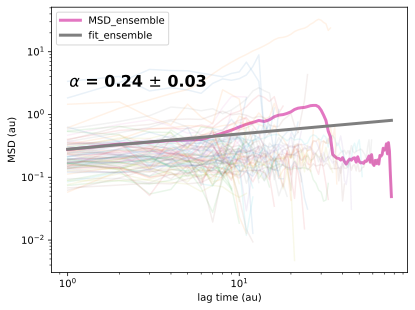

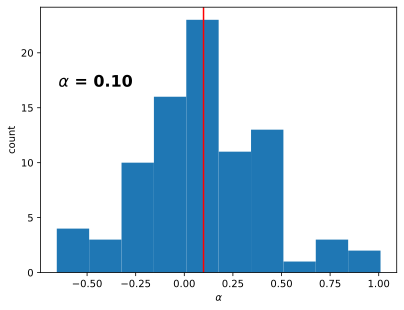

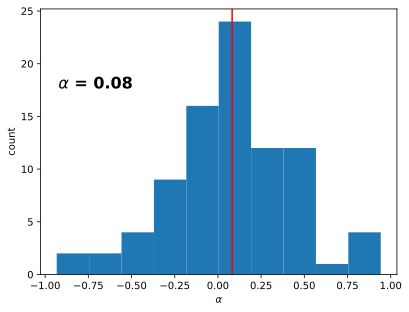

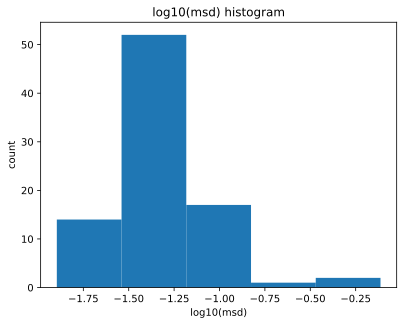

mean msd:  0.06369593219379145


In [111]:
#convert tracks to dictionary
track_dict = ll_ez._convert_to_track_dict_bulk()
h=0.5
a = msd_calc(track_dict["ALL"],h=None,tau_lim=None,tick_space=2,msd_fit_lim=3)
msds = np.array(list(a["track_diffusion"].values()))
#plot the log10 of the msds as a histogram
fig,ax = plt.subplots()
ax.hist(np.log10(con_pix_si(msds,which = 'msd')),bins=5)
ax.set_xlabel("log10(msd)")
ax.set_ylabel("count")
ax.set_title("log10(msd) histogram")
plt.show()
print("mean msd: ",np.mean(con_pix_si(msds,which = 'msd')))

In [ ]:
#convert tracks to dictionary
track_dict = ll_ez1._convert_to_track_dict_bulk()
h=0.5
a = msd_calc(track_dict["IN"],h=None,tau_lim=35,tick_space=2)

In [ ]:
#convert tracks to dictionary
track_dict = ll_ez2._convert_to_track_dict_bulk()
h=0.5
a = msd_calc(track_dict["OUT"],h=None,tau_lim=50,tick_space=2)

In [ ]:
msd2 = ll_ez2._bulk_msd_plot()

In [112]:
drop_localizations,total_localizations,total_clusters,total_cell_locs,area_cell,area_drop,area_drop_cell_diff = _avg_points_drop(ll_ez)
print(area_cell)
print(area_drop)
#print the average area of a cell
print("Mean cell area: {}".format(np.mean(list(area_cell.values()))))
print("Mean drop area: {}".format(np.mean(list(area_drop.values()))))
#plot the area per cell
plt.clf()
plt.hist(np.array(list(area_cell.values())),bins=5)
plt.xlabel("Cell Area in um^2")
plt.ylabel("Count")
plt.title("Cell Area Distribution")
plt.show()

#plot the area per drop
plt.clf()
plt.hist(np.array(list(area_drop.values())),bins=5)
plt.xlabel("Drop Area in um^2")
plt.ylabel("Count")
plt.title("Drop Area Distribution")
plt.show()

#plot the density per drop and per cell on the same plot as a histogram
plt.clf()
plt.hist(np.array(list(drop_localizations.values()))/np.array(list(area_drop.values()))/1000,bins=5,alpha=0.5,label="Drop")
plt.hist(np.array(list(total_localizations.values()))/np.array(list(area_drop_cell_diff.values()))/1000,bins=5,alpha=0.5,label="Cell")
plt.xlabel("Point Density in um^-2")
plt.ylabel("Count")
plt.legend()
plt.title("Points Per Area (Density) Distribution")
plt.show()

density_drop = np.array(list(drop_localizations.values()))/np.array(list(area_drop.values()))/1000
drop_area = np.array(list(area_drop.values()))


#plot the density_drop as a function of drop_area
#plot an exponential decay fit to the data

def exp_decay(x,a,b,c):
    return a*np.exp(-b*x) + c

popt,pcov = curve_fit(exp_decay,drop_area,density_drop)
print(popt)
print(pcov)


plt.clf()
plt.scatter(drop_area,density_drop)
plt.plot(np.linspace(0.1,1.5,100),exp_decay(np.linspace(0.1,1.5,100),*popt),label="Fit")
plt.xlabel("Drop Area in um^2")
plt.ylabel("Point Density in um^-2")
plt.title("Density vs Drop Area")
plt.show()

plt.scatter(drop_area,np.array(list(drop_localizations.values())))
plt.xlabel("Drop Area in um^2")
plt.ylabel("Number of Localizations in Drop")
plt.show()


#print the average density per drop
print("Mean density per drop: {}".format(np.mean(np.array(list(drop_localizations.values()))/np.array(list(area_drop.values())))))
#print the average density per cell
print("Mean density per cell: {}".format(np.mean(np.array(list(total_localizations.values()))/np.array(list(area_drop_cell_diff.values())))))


print(drop_localizations)
print(total_localizations)
print(total_clusters)
print(total_cell_locs)
avg_drop_localizations = np.mean(list(drop_localizations.values()))
std_drop_localizations = np.std(list(drop_localizations.values()))
print(avg_drop_localizations,std_drop_localizations,np.mean(list(total_localizations.values())),np.std(list(total_localizations.values())))  
print("Mean number of clusters per cell: {}".format(np.mean(list(total_clusters.values()))))   
#plot the distribution of localizations per drop
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(list(total_clusters.values()),alpha=0.5,label="Viable Drops per cell",bins=5)
ax.set_xlabel("Number of viable drops per cell")
ax.set_ylabel("Count")
#add a annotation with the mean and std
ax.annotate("Mean: {0:.2f}\nStd: {1:.2f}".format(np.mean(list(total_clusters.values())),np.std(list(total_clusters.values()))),xy=(0.5,0.5),xycoords="axes fraction")
ax.legend()
plt.show()
#plot the distribution of localizations per drop
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(list(drop_localizations.values()),alpha=0.5,label="# localizations per drop",bins=5)
ax.set_xlabel("Number of localizations per drop")
ax.set_ylabel("Count")
ax.legend()
plt.show()
#plot the total_localizations per cell 
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(list(total_cell_locs.values()),alpha=0.5,label="# localizations per cell",bins=5)
ax.set_xlabel("Number of localizations per cell")
ax.set_ylabel("Count")
ax.legend()
plt.show()
    
 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

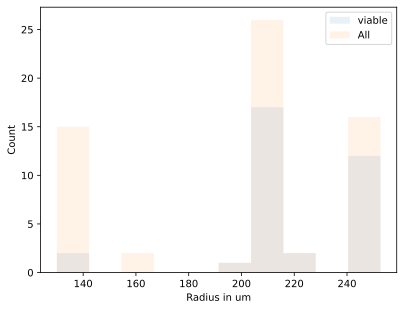

[array([206.59318637, 130.        , 130.        , 193.82765531,
       252.70541082, 252.70541082, 206.59318637, 226.13226453,
       206.59318637, 227.43486974, 206.59318637, 252.70541082,
       206.59318637, 252.70541082, 206.59318637, 252.70541082,
       206.59318637, 252.70541082, 206.59318637, 206.59318637,
       206.59318637, 252.70541082, 252.70541082, 206.59318637,
       252.70541082, 206.59318637, 206.59318637, 252.70541082,
       206.59318637, 252.70541082, 206.59318637, 206.59318637,
       252.70541082, 206.59318637]), array([206.59318637, 252.70541082, 130.        , 206.59318637,
       206.59318637, 206.59318637, 130.        , 206.59318637,
       193.82765531, 252.70541082, 252.70541082, 130.        ,
       130.        , 130.        , 206.59318637, 130.        ,
       130.        , 226.13226453, 206.59318637, 160.74148297,
       227.43486974, 160.74148297, 206.59318637, 252.70541082,
       206.59318637, 252.70541082, 206.59318637, 252.70541082,
       206.593186

In [115]:
plt.clf()
viable_ll=get_radius(ll_ez,bins = 10)
print(viable_ll)

In [ ]:
movie_ID = '5'
a = ll_ez.Movie[movie_ID].Movie_nucleoid
b = blob_detection(path = a,\
                    median= False,\
                    threshold= 0.015, \
                    min_sigma= 1, \
                    max_sigma = 2, \
                    num_sigma= 200, \
                    overlap = 0)
c = b.detection()
aa = read_file(a)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(aa,cmap = 'Greys')
for i in c:
    cir = plt.Circle((i[1],i[0]),radius=i[2], fill = False)
    ax.add_artist(cir)
plt.show()

In [ ]:

ll_ez_ba = boundary_analysis(dataset = ll_ez.Movie)
ll_ez_aa = ll_ez_ba.directional_displacement_bulk(IN = True,IO = True, OT = True)
b = ll_ez_ba.plot_directional_displacements(dir_displacements = ll_ez_aa[0],dist_center = ll_ez_aa[1],angles = ll_ez_aa[2])

adjust_axis(b)

# radius = []
# for i,j in ll_ez.Movie.items():
#     for k,l in j.Cells.items():
#         for m,n in l.Drop_Collection.items():
#             radius.append(n[2])
# radius_ll_ez = np.array(radius)*0.13
# plt.hist(radius_ll_ez,alpha = 0.1,label = "viable")
# plt.hist(np.array(ll_ez.radius)[:,2]*0.13,alpha = 0.1, label = "All")
# plt.xlabel("Radius in um")
# plt.ylabel("Count")
# plt.legend()
# plt.show()


# plt.hist(radius_ll_ez,alpha = 0.1,label = "ll")
# plt.hist(radius_rp_ez,alpha = 0.1,label = "rp")
# plt.legend()
# plt.show()
# plt.plot(ll_ez_aa[0],ll_ez_aa[2],'b.')
# plt.show()
print(np.sum(np.asarray(rp_ez_aa[1])>5))
a = plot_pairCorrelation(ll_ez_aa, dr = 0.05, rMax = 1.)
b = plot_pairCorrelation(rp_ez_aa, ax = a[4], dr = 0.05, rMax = 1.)
plt.show()
plt.plot(a[1],a[0],label = "ll_ez")
plt.plot(b[1],b[0],label = "rp_ez")
plt.legend()
plt.xlabel("radius")
plt.ylabel("g(r)")
plt.hlines(y = 1, xmin = 0, xmax = 1.5)


rMax = 1
dr = 0.05
edges = np.arange(0,rMax,dr)
resl,binsl = np.histogram(ll_ez_aa[1],bins = edges)
resr,binsr = np.histogram(rp_ez_aa[1],bins = edges)
num_radiusl = len(np.where(np.asarray(ll_ez_aa[1]) <= rMax)[0])
num_radiusr = len(np.where(np.asarray(rp_ez_aa[1]) <= rMax)[0])
space_density = np.zeros(len(edges)-1)
radius = np.zeros(len(edges)-1)
for i in range(len(edges)-1):
    space_density[i] = np.pi*(edges[i+1]**2 - edges[i]**2)
    radius[i] = (edges[i+1] - edges[i])/2
# plt.clf()
# plt.plot(binsl[:-1],resl)
# plt.plot(binsr[:-1],resr)
# plt.show()
# plt.plot(radius,((resl/num_radiusl)/(np.pi*rMax*rMax)) / space_density)
# plt.plot(radius,((resr/num_radiusr)/(np.pi*rMax*rMax)) / space_density)


In [ ]:
which = ll_ez
y_collection = []
x_collection = []
in_msd = []
io_msd = []
radius_col = []

#cm of track to boundary vs diff
cm_boundary = []
cm_diff = []
track_recidency_in_drop = []
cm_error = []
end_to_end = []
radius_gyration = []

IO_inside_start = []
IO_inside_start_dist = []
IO_outside_start = []
IO_outside_start_dist = []
#number of tracks that start inside and end inside
tracks_in_in = 0
len_ii = []
tracks_out_out = 0
len_oo = []
tracks_in_out = 0
len_io = []
tracks_out_in = 0
len_oi = []
directional_displacement = []
dist_center = []
long_axis_angle = []

#take notice of tracks which have displacements away from the condensate (in/out only) of >0.2 um
track_xy = []
track_drop = []
track_movie = []
track_cell = []
track_cell_e1_e2 = []
displacement_aligned_long = []
track_drop_loc = []
track_id = []
angles = []
for k,v in which.Movie.items():
   for o,oo in which.Movie[k].Cells.items():
      for kk,vv in which.Movie[k].Cells[o].Trajectory_Collection.items():
          
          for kkk,vvv in which.Movie[k].Cells[o].Trajectory_Collection[kk].IN_Trajectory_Collection.items():
              track = which.Movie[k].Cells[o].Trajectory_Collection[kk].IN_Trajectory_Collection[kkk]
              x_val = track.X
              y_val = track.Y
              drop_data = which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier]

              diff_dist_temp = con_pix_si(dif_dis(x_val,y_val),which = 'um')
              drop_center_dist = (dist(x_val,y_val,drop_data[0],drop_data[1]))-drop_data[2]
              angles += list(angle_dist(x_val,y_val,drop_data[0],drop_data[1]))

              #direction of the trajectory
              #r2 -r1 > 0 moving out, r2 - r1 < 0 moving in
              directional = con_pix_si(np.diff(dist(x_val,y_val,drop_data[0],drop_data[1])),which = 'um')
              directional_displacement+=list(directional)
              dist_center+=list(drop_center_dist)[:-1]

              radius_col.append(drop_data[2])
              y_collection+=list(diff_dist_temp)
              x_collection+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))

              in_msd.append(track.MSD_total_um)

              #center of mass of track relative to boundary vs. diffusion of track
              cm = cm_normal(x_val,y_val)
              cm_dist_boundary = dist(cm[0],cm[1],drop_data[0],drop_data[1]) - drop_data[2]
              cm_boundary.append(con_pix_si(cm_dist_boundary,which = 'um'))
              cm_diff.append(track.MSD_total_um)
              cm_error.append(np.sqrt(np.std(x_val)**2 + np.std(y_val)**2)/np.sqrt(len(x_val)))
              track_recidency_in_drop.append(np.sum(drop_center_dist<0.0)/len(x_val))
              #end ot end distance of trajectory:
              end_to_end.append(end_distance(x_val,y_val))

              #radius of gyration
              radius_gyration.append(radius_of_gyration(x_val,y_val))



              #how aligned is the displacement vector for each displacement to each axis of the cell. 
              #differences in x,y
              dif_x = np.diff(x_val)
              dif_y = np.diff(y_val)
              long_axis_vec = which.Movie[k].Cells[o].cell_long_axis
              angle_xy = []
              for i in range(len(dif_x)):
                  termer = np.arccos(np.dot(long_axis_vec.T[0],[dif_x[i],dif_y[i]])/(np.linalg.norm(long_axis_vec.T[0])*np.linalg.norm([dif_x[i],dif_y[i]])))*180/np.pi
                  angle_xy.append(termer)
              long_axis_angle+=angle_xy


          for kkk,vvv in which.Movie[k].Cells[o].Trajectory_Collection[kk].IO_Trajectory_Collection.items():
              track = which.Movie[k].Cells[o].Trajectory_Collection[kk].IO_Trajectory_Collection[kkk]
              x_val = track.X
              y_val = track.Y
              drop_data = which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier]
                  
              diff_dist_temp = con_pix_si(dif_dis(x_val,y_val),which = 'um')
              drop_center_dist = (dist(x_val,y_val,drop_data[0],drop_data[1]) - drop_data[2])/drop_data[2]
              angles += list(angle_dist(x_val,y_val,drop_data[0],drop_data[1])[:-1])
              #direction of the trajectory
              #r2 -r1 > 0 moving out, r2 - r1 < 0 moving in
              directional = con_pix_si(np.diff(dist(x_val,y_val,drop_data[0],drop_data[1])),which = 'um')
              directional_displacement+=list(directional)
              dist_center+=list(drop_center_dist[:-1])

              radius_col.append(drop_data[2])
              y_collection+=list(diff_dist_temp)
              x_collection+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
              io_msd.append(track.MSD_total_um)

              #center of mass of track relative to boundary vs. diffusion of track
              cm = cm_normal(x_val,y_val)
              cm_dist_boundary = dist(cm[0],cm[1],drop_data[0],drop_data[1]) - drop_data[2]
              cm_boundary.append(con_pix_si(cm_dist_boundary,which = 'um'))
              cm_diff.append(track.MSD_total_um)
              cm_error.append(np.sqrt(np.std(x_val)**2 + np.std(y_val)**2))
              track_recidency_in_drop.append(np.sum(drop_center_dist<0.0)/len(x_val))
              #end ot end distance of trajectory:
              end_to_end.append(end_distance(x_val,y_val))

              #radius of gyration
              radius_gyration.append(radius_of_gyration(x_val,y_val))

              #how aligned is the displacement vector for each displacement to each axis of the cell. 
              #differences in x,y
              dif_x = np.diff(x_val)
              dif_y = np.diff(y_val)
              long_axis_vec = which.Movie[k].Cells[o].cell_long_axis
              angle_xy = []
              for i in range(len(dif_x)):
                  termer = np.arccos(np.dot(long_axis_vec.T[0],[dif_x[i],dif_y[i]])/(np.linalg.norm(long_axis_vec.T[0])*np.linalg.norm([dif_x[i],dif_y[i]])))*180/np.pi
                  angle_xy.append(termer)
              long_axis_angle+=angle_xy
              #check the tracks which have displacements way outside the condensate and ask how are they oriented relative to the cell axis and where the condensate is
              if np.sum(np.array(con_pix_si(drop_center_dist[:-1], which = 'um'))>-0.4) != 0:
                  track_xy.append([x_val,y_val])
                  track_drop.append(which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier])
                  track_drop_loc.append(track.Drop_Identifier)
                  track_id.append(kkk)
                  track_movie.append(k)
                  track_cell.append(o)
                  track_cell_e1_e2.append([which.Movie[k].Cells[o].cell_long_axis,which.Movie[k].Cells[o].cell_short_axis])
                  #how aligned is the displacement vector for each displacement to each axis of the cell. 
                  #differences in x,y
                  dif_x = np.diff(x_val)
                  dif_y = np.diff(y_val)
                  long_axis_vec = which.Movie[k].Cells[o].cell_long_axis
                  angle_xy = []
                  for i in range(len(dif_x)):
                      termer = np.arccos(np.dot(long_axis_vec.T[0],[dif_x[i],dif_y[i]])/(np.linalg.norm(long_axis_vec.T[0])*np.linalg.norm([dif_x[i],dif_y[i]])))*180/np.pi
                      angle_xy.append(termer)



              #for IO trajectories that start in the inside of condensates how do they behave?
              distances_center = dist(x_val,y_val,drop_data[0],drop_data[1]) 
              index_radius = distances_center<drop_data[2]
              # index_index = 0
              # for i in range(len(index_radius)):
              #     if i==0:
              #         index_index = index_radius[i]
              #     else:


              if (index_radius[0] == True) and (index_radius[-1] == True):
                  IO_inside_start+=list(diff_dist_temp)
                  IO_inside_start_dist+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
                  tracks_in_in+=1
                  len_ii.append(len(index_radius))
              elif (index_radius[0] == False) and (index_radius[-1] == False):
                  IO_outside_start+=list(diff_dist_temp)
                  IO_outside_start_dist+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
                  tracks_out_out+=1
                  len_oo.append(len(index_radius))
              if (index_radius[0] == False) and (index_radius[-1] == True):
                  tracks_out_in+=1
                  len_oi.append(len(index_radius))
              if (index_radius[0] == True) and (index_radius[-1] == False):
                  tracks_in_out+=1
                  len_io.append(len(index_radius))

          # for kkk,vvv in which.Movie[k].Cells[o].Trajectory_Collection[kk].OUT_Trajectory_Collection.items():
          #     track = which.Movie[k].Cells[o].Trajectory_Collection[kk].OUT_Trajectory_Collection[kkk]
          #     x_val = track.X
          #     y_val = track.Y
          #     drop_data = which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier]
                  
          #     diff_dist_temp = con_pix_si(dif_dis(x_val,y_val),which = 'um')
          #     drop_center_dist = dist(x_val,y_val,drop_data[0],drop_data[1]) - drop_data[2]

          #     #direction of the trajectory
          #     #r2 -r1 > 0 moving out, r2 - r1 < 0 moving in
          #     directional = con_pix_si(np.diff(dist(x_val,y_val,drop_data[0],drop_data[1])),which = 'um')
          #     directional_displacement+=list(directional)
          #     dist_center+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))

          #     radius_col.append(drop_data[2])
          #     y_collection+=list(diff_dist_temp)
          #     x_collection+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
          #     io_msd.append(track.MSD_total_um)

          #     #center of mass of track relative to boundary vs. diffusion of track
          #     cm = cm_normal(x_val,y_val)
          #     cm_dist_boundary = dist(cm[0],cm[1],drop_data[0],drop_data[1]) - drop_data[2]
          #     cm_boundary.append(con_pix_si(cm_dist_boundary,which = 'um'))
          #     cm_diff.append(track.MSD_total_um)
          #     cm_error.append(np.sqrt(np.std(x_val)**2 + np.std(y_val)**2))
          #     track_recidency_in_drop.append(np.sum(drop_center_dist<0.0)/len(x_val))
          #     #end ot end distance of trajectory:
          #     end_to_end.append(end_distance(x_val,y_val))

          #     #radius of gyration
          #     radius_gyration.append(radius_of_gyration(x_val,y_val))


#plotting tracks on cells


#get the '2' movie:
movie_selc = '7'

ind_m = np.array(track_movie) == movie_selc
cells_m = np.array(track_cell)[ind_m]
drops_m = np.array(track_drop)[ind_m]
tracks_m = np.array(track_xy)[ind_m]
drop_loc_m = np.array(track_drop_loc)[ind_m]
track_idm = np.array(track_id)[ind_m]



cmap_all=plt.get_cmap('gray')


'''
for i in range(len(tracks_m)):
    img = mpimg.imread(which.Movie[movie_selc].Movie_location[int(drop_loc_m[i][0])])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    pimg = ax.imshow(img,cmap=cmap_all)
    ax.plot(tracks_m[i][0],tracks_m[i][1],'-') 
    cir = Circle([drops_m[i][0],drops_m[i][1]], radius =drops_m[i][2], fill = False, color = 'red')
    ax.add_artist(cir)
    for k,l in which.Movie[movie_selc].Cells[cells_m[i]].Drop_Collection.items():

        print(drops_m[i])
        if k[0] == track_idm[i][0]:
            cir = Circle([l[0],l[1]], radius =l[2], fill = False, color = "black")
            ax.add_artist(cir)
    plt.xlim((50,120))
    plt.ylim((180,240))
    plt.show()
'''
for i in range(len(tracks_m)):
    if i == 0:
      img = mpimg.imread(which.Movie[movie_selc].Movie_location[int(drop_loc_m[i][0])])
      fig = plt.figure()
      ax = plt.axes(projection='3d')
      nx,ny = np.shape(img)
      x = range(nx)
      y = range(ny)
      X, Y = np.meshgrid(x, y)
      ax.plot_surface(X[50:120,190:240], Y[50:120,190:240], img[190:240,50:120].T, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
      cir = Circle([drops_m[i][1],drops_m[i][0]], radius =drops_m[i][2], fill = False, color = 'red')
      ax.add_patch(cir)
      art3d.pathpatch_2d_to_3d(cir, z=200)
      plt.show()
















#directional_displacement
x = np.array(dist_center)
y = np.array(directional_displacement)
xy = np.vstack([dist_center,directional_displacement])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]


# angles = np.array(angles)

# def rt_to_xy(r,theta):
#     y = r*np.sin(theta)
#     x = r*np.cos(theta)
#     return np.array([x,y])

# fig = plt.figure()
# ax = fig.add_subplot()
# ax.scatter(*rt_to_xy(x,angles),c = long_axis_angle,s = 0.1)
# cir = plt.Circle( (0,0) ,1,fill = False )
# ax.plot(0,0,'bo',markersize = 2)
# plt.colorbar()
# ax.add_artist(cir)
# plt.show()



from scipy.stats import binned_statistic_2d
a,b,c,d = binned_statistic_2d(x,y,None,'count',bins = 50, expand_binnumbers = True)

weights2 = np.ones_like(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]) / (len(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]))
weights1 = np.ones_like(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]) / (len(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]))
plt.hist(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)],alpha = 0.3,label = "Boundary",weights=weights1)
plt.hist(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)],alpha = 0.3,label = "Droplet Phase",weights=weights2)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()
plt.hist(abs(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]),alpha = 0.3,label = "Boundary",weights=weights1)
plt.hist(abs(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]),alpha = 0.3,label = "Droplet Phase",weights=weights2)
plt.show()

weights1 = np.ones_like(y[(d[0]==2) | (d[0]==3) | (d[0]==4)]) / (len(y[(d[0]==2) | (d[0]==3) | (d[0]==4)]))
weights2 = np.ones_like(y[(d[0]==5) | (d[0]==6) | (d[0]==7)]) / (len(y[(d[0]==5) | (d[0]==6) | (d[0]==7)]))
plt.hist(y[(d[0]==2) | (d[0]==3) | (d[0]==4)],alpha = 0.3,label = "Boundary",weights=weights1)
plt.hist(y[(d[0]==5) | (d[0]==6) | (d[0]==7)],alpha = 0.3,label = "Droplet Phase",weights=weights2)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()
# plt.hist(abs(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]),alpha = 0.3,label = "Boundary",weights=weights1)
# plt.hist(abs(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]),alpha = 0.3,label = "Droplet Phase",weights=weights2)
# plt.show()


weights1 = np.ones_like(y[(d[0]==16) | (d[0]==17) | (d[0]==18)]) / (len(y[(d[0]==16) | (d[0]==17) | (d[0]==18)]))
weights2 = np.ones_like(y[(d[0]==19) | (d[0]==20) | (d[0]==21)]) / (len(y[(d[0]==19) | (d[0]==20) | (d[0]==21)]))
plt.hist(y[(d[0]==16) | (d[0]==17) | (d[0]==18)],alpha = 0.3,label = "Outside Boundary",weights=weights1)
plt.hist(y[(d[0]==19) | (d[0]==20) | (d[0]==21)],alpha = 0.3,label = "Non-Droplet/Boundary Phase",weights=weights2)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()
weights3 = np.ones_like(y[(d[0]==1)]) / (len(y[(d[0]==1)]))
plt.hist(y[(d[0]==1)],alpha = 1,label = "Center of Condensate",weights=weights3)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()







n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = z, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.globals[pixel_size],linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()


n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = long_axis_angle, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.globals[pixel_size],linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()





#IO_Crossing inside
x = np.array(IO_inside_start_dist)
y = np.array(IO_inside_start)
xy = np.vstack([IO_inside_start_dist,IO_inside_start])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]



n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = z, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.globals[pixel_size],linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()


#IO_Crossing outside
x = np.array(IO_outside_start_dist)
y = np.array(IO_outside_start)
xy = np.vstack([IO_outside_start_dist,IO_outside_start])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]



n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = z, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.globals[pixel_size],linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()





In [ ]:
movie_ID = '0'
cell_ID = '0'
total_sorted_tracks = 0
for i in range(len(rp_ez.Movie[movie_ID].Cells[cell_ID].sorted_tracks_frame[0])):
    total_sorted_tracks += len(rp_ez.Movie[movie_ID].Cells[cell_ID].sorted_tracks_frame[0][i])
total_sorted_tracks
total_seg = 0
for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection.items():
    total_seg += len(j.IN_Trajectory_Collection)
    total_seg += len(j.IO_Trajectory_Collection)
    total_seg += len(j.OUT_Trajectory_Collection)
a = len(rp_ez.Movie[movie_ID].Cells[cell_ID].No_Drops_Trajectory_Collection)
print(a)
print(total_seg)
print(total_sorted_tracks)
print(total_seg+a)